# IMPORT

In this notebook I did not normalized images before evolving, just when predicting

In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
import pickle
import time
from skimage.measure import compare_ssim
import tensorflow as tf
from keras.models import Model,load_model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation
from keras.utils import to_categorical
import keras
import random

Using TensorFlow backend.


In [2]:
#Set seeds
random.seed(1)
np.random.seed(1)

# GLOBAL VARS

In [3]:
INDIVIDUALS = 50
P_CROSS = 0.6
P_MUTATION = 0.01
CIFAR_IMG= 32

# THE DATA

In [4]:
from keras.datasets import cifar10

# The data, split between train and test sets:
(x_train_C, y_train_C), (x_test_C, y_test_C) = cifar10.load_data()
print('x_train shape:', x_train_C.shape)
print(x_train_C.shape[0], 'train samples')
print(x_test_C.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
num_classes=10
epochs=10
img_shape=32 
y_train_C = to_categorical(y_train_C, num_classes)
y_test_C = to_categorical(y_test_C, num_classes)


input_shape=(32,32,1)

x_train_C = x_train_C.astype('float32')
x_test_C = x_test_C.astype('float32')
x_train_C /= 255
x_test_C /= 255


print('x_train shape:', x_train_C.shape)
print('Number of images in x_train', x_train_C.shape[0])
print('Number of images in x_test', x_test_C.shape[0])
print('y_train shape:', y_train_C.shape)
print("input shape: ",input_shape)


# CONVERT TO GRAY SCALE

import matplotlib.pyplot as plt
import numpy as np

def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

x_train_C = grayscale(x_train_C)
x_test_C = grayscale(x_test_C)

# now we have only one channel in the images
img_channels = 1



x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
x_train shape: (50000, 32, 32, 3)
Number of images in x_train 50000
Number of images in x_test 10000
y_train shape: (50000, 10)
input shape:  (32, 32, 1)


# READ PICKLE FILES

In [5]:
with open('../../Subsets/subset_cifar', 'rb') as f:
    original = pickle.load(f)
    adversarial= pickle.load(f)
    original_y = pickle.load(f)
    adversarial_y = pickle.load(f)

In [6]:
print(f"Original shape {original.shape}")
print(f"Adversarial shape {adversarial.shape}")
print(f"Original labels shape {original_y.shape}")
print(f"Adversarial labels shape {adversarial_y.shape}")

Original shape (914, 32, 32, 1)
Adversarial shape (133, 32, 32, 1)
Original labels shape (914, 1)
Adversarial labels shape (133, 1)


# LOAD THE MODEL

3. CNN v2

This network is made for CIFAR 10. The network is taken from [this blog]( https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/) . In this version below I didn't use some things used in the blog e.g. z-score and data augmentation.


This network has training accuracy: 0.8940 , validation accuracy: 0.8245.

**NOTE:** Training really slow, try to avoid it.

In [7]:
# Network 3 
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np

input_shape = (CIFAR_IMG,CIFAR_IMG,1)
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=input_shape))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
 
model.summary()


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


'''
history = model.fit(x=x_train_C,y=y_train_C, epochs=150, batch_size=64, validation_data=[x_test_C,y_test_C])

score= model.evaluate(x_test_C, y_test_C,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model.save_weights("CNN_CIFAR10_net3.h5")
files.download('CNN_CIFAR10_net3.h5')
'''

model = load_model("../../Models/CNN_CIFAR10_net3.h5")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)       

In [8]:
model

# GENETIC ALGORITHM FUNCTIONS

In [9]:

def computing_SSIM(individual,target):
    return compare_ssim(individual.reshape(CIFAR_IMG,CIFAR_IMG), target.reshape(CIFAR_IMG,CIFAR_IMG))

def calculate_fitness(model,ind,target_image,label,l1=0.2, l2=0.8, N=50, num_classes=10):
  # predict the population
  predictions=model.predict(ind.reshape(1,CIFAR_IMG,CIFAR_IMG,1) / 255.0)  
  # po is the ground truth prediction, so for label = 0, it will be prediciton[0]
  predictions=predictions[0]
  po=predictions[label]
  # set that value to 0
  predictions[label]=0
  # take next highest one
  pd = np.max(predictions)
  diff=pd-po
  return l1*computing_SSIM(ind.reshape(CIFAR_IMG,CIFAR_IMG),target_image.reshape(CIFAR_IMG,CIFAR_IMG)) +l2*(diff)
  


def pop_fitness(model,pop,target,label):
    return [calculate_fitness(model, p, target, label) for p in pop]

def flatten(imgs):
    # flatten all images in np array or list
    return np.array([im.flatten() for im in imgs])

def gaussian_noise():
    # draw one sample of noise from zero mean 1 variance Gaussian
    return np.random.normal(0, 10)

def p_noise(x):
  if 0.01 > np.random.uniform():
    return x + gaussian_noise()
  else:
    return x
    
def add_noise(image):
    noise_v=np.vectorize(p_noise)
    return noise_v(image) #np.array([x + gaussian_noise() if P_MUTATION > np.random.uniform(0.0, 1.0) else x+0 for x in image])

def k_crossover(im1, im2, k=2):
    c1, c2 = [], []
    # get k crossover points
    points = sorted([np.random.randint(0, CIFAR_IMG*CIFAR_IMG-1, 1) for p in range(k)])
    points = sorted([np.random.randint(0,CIFAR_IMG*CIFAR_IMG-1,1) for p in range(k)])
    im_1_split = np.split(im1, [int(p) for p in points])
    im_2_split = np.split(im2, [int(p) for p in points])
    
    # alternate between lists to realise crossover (theres got to be a more clever way to do this)
    for i in range(k+1):
        if i % 2 == 0:
            c1.append(im_1_split[i])
            c2.append(im_2_split[i])
        else:
            c1.append(im_2_split[i])
            c2.append(im_1_split[i])
    return np.concatenate(c1, axis=0), np.concatenate(c2, axis=0)

def tournament(pop, model, ground_truth, target, k=3):

    indices = np.random.choice(range(len(pop)), k, replace=False) #we get 3 indxes [2 34 46]    
    individuals = pop.take(indices,axis=0)
    scores = pop_fitness(model,np.expand_dims(individuals.reshape(individuals.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3), ground_truth.reshape(CIFAR_IMG,CIFAR_IMG), target)
    index_max = np.argmax(scores)
    winner = individuals[index_max]
    return winner


def check_adv_termination(ind, label,ground_truth, model):
  # individual - the best one from the generation
  # label - class we want
  # ground_truth - the image (32,32)
  # model we are using 
  dist = 1-compare_ssim(ind.reshape(CIFAR_IMG,CIFAR_IMG),ground_truth.reshape(CIFAR_IMG,CIFAR_IMG))
  predictions= model.predict(ind.reshape(1,CIFAR_IMG,CIFAR_IMG,1)/255.0)
  predicted_label= np.argmax(predictions[0])
  if label != predicted_label and dist < 0.001:
    print("FOUND ADVERSARIAL")
    print(f"Fitness of the adversarial {calculate_fitness(model,ind,ground_truth,label)}")
    return ind
  return []

def init_pop_from_sample(n,img,label):
    x = np.array([add_noise(img) for i in range(n)])
    return x.reshape(n, CIFAR_IMG*CIFAR_IMG)



Functions from the past, just didn't want to erase them yet

In [10]:
'''
def check_adverserial(pop, model, fitness, target,ground_truth):
    #print(f"this is adversarial function")
    preds=model.predict(pop.reshape(pop.shape[0],28,28,1))
    #print(f"These are predictions made here {preds}")
    for ind, pr in zip(pop,preds): 
      #print(f"prediction for an individual {pr}")
      preds=np.argmax(pr)
      #print(f"getting the index of highest value in predictions {preds}")
      #setting the value to 0
      pr[0]=0
      #print(f"this is our target {target}")
      #print(f"this is out ground_truth {ground_truth.shape}")
      fitness=computing_SSIM(ind.reshape(28,28),ground_truth.reshape(28,28))
      #print(f"these are the fitness values {fitness}")
      next_highest = np.argmax(pr)
      #print(f"getting the next highest value {next_highest}")
      if next_highest != target and fitness > 0.98:
          return ind, True
      return None, False

def init_pop(n, num, data, labels):
    indices = np.where(labels==num)[0]
    n_indices = np.random.choice(indices, n, replace=True)
    sample = np.take(data, n_indices, axis=0)
    return sample, np.full((n), num, dtype=int) # return sample+array of labels


Cyrils model

def save_trained_model(model, filename='SVC_model.sav'):
    pickle.dump(model, open(filename, 'wb'))
    
def load_trained_model(filename='SVC_model.sav'):
    return pickle.load(open(filename, 'rb'))

'''

'\ndef check_adverserial(pop, model, fitness, target,ground_truth):\n    #print(f"this is adversarial function")\n    preds=model.predict(pop.reshape(pop.shape[0],28,28,1))\n    #print(f"These are predictions made here {preds}")\n    for ind, pr in zip(pop,preds): \n      #print(f"prediction for an individual {pr}")\n      preds=np.argmax(pr)\n      #print(f"getting the index of highest value in predictions {preds}")\n      #setting the value to 0\n      pr[0]=0\n      #print(f"this is our target {target}")\n      #print(f"this is out ground_truth {ground_truth.shape}")\n      fitness=computing_SSIM(ind.reshape(28,28),ground_truth.reshape(28,28))\n      #print(f"these are the fitness values {fitness}")\n      next_highest = np.argmax(pr)\n      #print(f"getting the next highest value {next_highest}")\n      if next_highest != target and fitness > 0.98:\n          return ind, True\n      return None, False\n\ndef init_pop(n, num, data, labels):\n    indices = np.where(labels==num)[0]\n 

In [11]:
''' my part of the code ''' 
''' I know it is ugly, I will fix it . this is the intial version'''
# from Goorge Clooney paper
def quadrant_crossover(parent_1,parent_2):

  # reshape parents
  parent_1,parent_2= parent_1.reshape((CIFAR_IMG,CIFAR_IMG)), parent_2.reshape((CIFAR_IMG,CIFAR_IMG))
  # quadrants for both parents
  p1,p2,p3,p4,q1,q2,q3,q4 = [],[],[],[],[],[],[],[]
  child1, child2 = [],[]
  # getting random (x,y) point in 2D matrix
  x,y = np.random.randint(0,CIFAR_IMG-1), np.random.randint(0,CIFAR_IMG-1)  

  # choose which quadrant we want to crossover
  N = np.random.randint(0,3)
  #make quadrants
  for i in range(CIFAR_IMG):
    if (i<=x):
      p1.append(parent_1[i][:y+1])
      p2.append(parent_1[i][y+1:])
      q1.append(parent_2[i][:y+1])
      q2.append(parent_2[i][y+1:])
    else:
      p3.append(parent_1[i][:y+1])
      p4.append(parent_1[i][y+1:])
      q3.append(parent_2[i][:y+1])
      q4.append(parent_2[i][y+1:])

  if (N==0):
    ch1 = connect_quadrants(p1,q2,q3,q4)
    ch2 = connect_quadrants(q1,p2,p3,p4)
  elif (N==1):
    ch1 = connect_quadrants(q1,p2,q3,q4)
    ch2 = connect_quadrants(p1,q2,p3,p4)
  elif (N==2):
    ch1 = connect_quadrants(q1,q2,p3,q4)
    ch2 = connect_quadrants(p1,p2,q3,p4)
  else:
    ch1 = connect_quadrants(q1,q2,q3,p4)
    ch2 = connect_quadrants(p1,p2,p3,q4)

  return ch1,ch2

def connect_quadrants(q1,q2,q3,q4):
  left = np.concatenate((q1,q3))
  right = np.concatenate((q2,q4))
  image = np.concatenate((left,right),axis=1)
  return image.flatten()


def multi_crossover(parent1,parent2,target):
  pop= []
  # 2-k crossover
  pop.append(k_crossover(parent1, parent2))
  # Gorge Clooney crossover
  pop.append(quadrant_crossover(parent1,parent2))
  # uniform crossover
  pop.append(k_crossover(parent1, parent2,1))
  # SSIM similarity 
  flattened_list = [y for x in pop for y in x] # need to flatten the list because pop is list of lists, cause every crossover function returns 2 obj
  ssim = [computing_SSIM(ind,target) for ind in flattened_list ]
  # taking the index of largest two score
  id1=np.argmax(ssim)
  ssim[id1]=0
  id2 = np.argmax(ssim)
  #returning parents
  return flattened_list[id1],flattened_list[id2]
  


In [12]:
def return_best_individual(pop,fitness):
  index = np.argmax(fitness)
  best = pop[index]
  return best, np.max(fitness)

In [13]:
def choose_better_child(ch1, ch2,ground_truth,label,model):
  # I named it better child, but we choose by this parents as well
  ch1_f = calculate_fitness(model,ch1.reshape(CIFAR_IMG,CIFAR_IMG),ground_truth.reshape(CIFAR_IMG,CIFAR_IMG),label)
  ch2_f = calculate_fitness(model,ch2.reshape(CIFAR_IMG,CIFAR_IMG),ground_truth.reshape(CIFAR_IMG,CIFAR_IMG),label)
  # change this into ternary operator
  if ch1_f>ch2_f:
    return ch1
  else:
    return ch2              


# THE MAIN LOOP

In [14]:
'''
This not necessary when using subset 
'''
'''
X = flatten(x_train)
X_t = flatten(x_test)
print(f"X train shape {X.shape}")
print(f"X test shape {X_t.shape}")
print(f"y train shape {y.shape}")
print(f"y test shape {y_t.shape}")
'''

'\nX = flatten(x_train)\nX_t = flatten(x_test)\nprint(f"X train shape {X.shape}")\nprint(f"X test shape {X_t.shape}")\nprint(f"y train shape {y.shape}")\nprint(f"y test shape {y_t.shape}")\n'

Initial fitness: 
 [-0.6003421846829813, -0.6014233009400011, -0.6021710252132082, -0.6010787395273278, -0.6017296644445892, -0.6006246064342724, -0.6016371008769117, -0.6015986491587476, -0.6013498892158472, -0.5999955458140832, -0.601020590562576, -0.6017574466266108, -0.602747413741685, -0.6017573611414601, -0.6005499628970601, -0.6009253942964956, -0.6012076525904644, -0.6017729240012388, -0.601591565086971, -0.6002356500571928, -0.6020833207438715, -0.6014473382482549, -0.6047364836056387, -0.6036656071764964, -0.6028087296464472, -0.6002553189157103, -0.6011277407964598, -0.600873706128894, -0.6002998612753933, -0.5999804860611871, -0.6004737955634604, -0.6011875444301396, -0.6008069189157474, -0.6019352034546327, -0.6000528284646404, -0.6013990531717441, -0.600529128618289, -0.6021990828935389, -0.5999799240095858, -0.6013059022818715, -0.6010262546795597, -0.6028610166065058, -0.6013173335334538, -0.6016748774691136, -0.6015680422549939, -0.6016282783645052, -0.6015389422224486

C:\Users\Lora\Anaconda3\lib\site-packages\skimage\measure\_structural_similarity.py:155: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


Generation 0
Max fitness value -0.5999799240095858
Generation 10
Max fitness value -0.5975544266066848
Generation 20
Max fitness value 0.8035845805122624
Generation 30
Max fitness value 0.9730822587867253
Generation 40
Max fitness value 0.9796775695399013
Generation 50
Max fitness value 0.9800824014942456
Generation 60
Max fitness value 0.9800824014942456
Generation 70
Max fitness value 0.9802397779135428
Generation 80
Max fitness value 0.980563178750882
Generation 90
Max fitness value 0.981147324887329
Generation 100
Max fitness value 0.981147324887329
Generation 110
Max fitness value 0.981147324887329
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


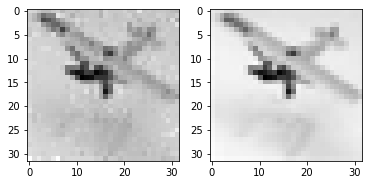

True label: 0
predicted label: 4
Time:  708.4002566337585  seconds
Initial fitness: 
 [-0.4938416263823615, -0.5325315637348828, -0.5367550071193384, -0.531574628915903, -0.3895876716066853, -0.4553875940278828, -0.40433717921088785, -0.4957948129444324, -0.5233572395038177, -0.5079516484831543, -0.5122379548119478, -0.5608146929312947, -0.576202031070673, -0.5090584890957742, -0.49865610670685356, -0.5556358732277006, -0.545480362764391, -0.5114815086366943, -0.4886188596891395, -0.5101455210417077, -0.5085865584252353, -0.5288446041361446, -0.5271539679724875, -0.5064189673680843, -0.4940737856342785, -0.4902701132514354, -0.5160624515052972, -0.39673442781458634, -0.49325027918028475, -0.45249534447739276, -0.5009538313127551, -0.48846339357870383, -0.5103901297094621, -0.4793295345004843, -0.49521020484706546, -0.4215721264684633, -0.4933140315282124, -0.5231271775652244, -0.4524482498004315, -0.4963256048193178, -0.4792037748299871, -0.45010998076313774, -0.5119600149510789, -0.46

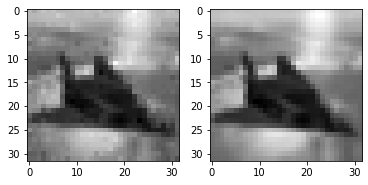

True label: 0
predicted label: 8
Time:  527.0391044616699  seconds
Initial fitness: 
 [-0.09948407472372844, -0.3949286471532677, -0.4310656480086471, -0.27122628287101186, -0.4007963768535498, -0.35466123387387005, -0.4529491578120932, -0.23485260473147002, -0.45165321385603907, -0.2625009726083864, -0.230769412524677, -0.33367838225972857, -0.26079774598652494, -0.22847663366447973, -0.22339432815568416, -0.36280032010850594, -0.3651607744192691, -0.27459737965272996, -0.3804151095970014, -0.16305659535047234, -0.2966756897085152, -0.3486751537945867, -0.27643003298006313, -0.2985312219143713, -0.35982663965871275, -0.45335358919429636, -0.47157071641110176, -0.40502814736162485, -0.25459911129401136, -0.37989510786664105, -0.14813260006453463, -0.3597714276784724, -0.055392623076538416, -0.4108821156497233, -0.48827793569780825, -0.33255654885763863, -0.416178297864798, -0.3234921785304626, -0.3816840805819172, -0.3623963223307626, -0.19239168052467245, -0.10771239165732735, -0.2688

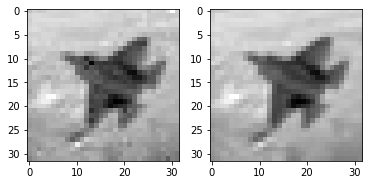

True label: 0
predicted label: 2
Time:  479.37023067474365  seconds
Initial fitness: 
 [-0.592511802677983, -0.5925862001629651, -0.5937546351141199, -0.5945840353100647, -0.5912557112174182, -0.5938770928959123, -0.590358887008392, -0.5930330418283657, -0.5929959086847987, -0.5949584391790643, -0.5947238455581638, -0.5955910067323061, -0.5948878958484589, -0.5929463894761856, -0.5941807835352801, -0.5954348038621705, -0.5914167741693526, -0.5938184841698949, -0.5943270727903196, -0.5947277211771836, -0.5928724770791262, -0.5949176946066448, -0.5888724363691579, -0.5936009828856357, -0.5938824761881192, -0.5953594977869947, -0.5898206505353096, -0.5952719952599373, -0.5935113122300918, -0.5952190413689089, -0.5915020683154554, -0.5925189434346153, -0.587842853126762, -0.595131688389775, -0.5919886549131781, -0.5937590326747891, -0.5978655457404419, -0.5950585270919555, -0.5949727831467044, -0.5948702596745056, -0.598090638611504, -0.5934053122850415, -0.5934359858539564, -0.59607401429

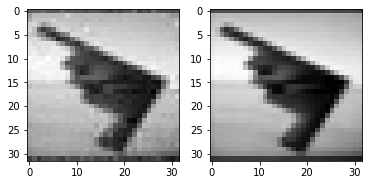

True label: 0
predicted label: 2
Time:  788.377238035202  seconds
Initial fitness: 
 [-0.5580750963033657, -0.5551162745514229, -0.5369283863192813, -0.49847034249604394, -0.5441058125129977, -0.5198947825921991, -0.47722122602114414, -0.5525508124847939, -0.5156329979653556, -0.5422155638707785, -0.5450727737159285, -0.5292570028467473, -0.5433404154656036, -0.5502259552990856, -0.5366220938376904, -0.5454595225084521, -0.5033139879591941, -0.5473356462303538, -0.5497013662396997, -0.552161697362934, -0.5223768696037965, -0.5328055495430379, -0.42848675876837117, -0.5135690845590081, -0.5696047101617576, -0.45542021809845307, -0.5494799197327459, -0.5104008850195505, -0.5492079020047071, -0.5621019680167945, -0.560890412268155, -0.565202398769059, -0.5360037546888673, -0.5601973594927555, -0.4568320275141744, -0.5309295340340188, -0.5707299886875823, -0.5454984116443479, -0.5458752858293078, -0.5098561720797518, -0.48828843876781913, -0.5379632608599435, -0.5250472849717481, -0.530886

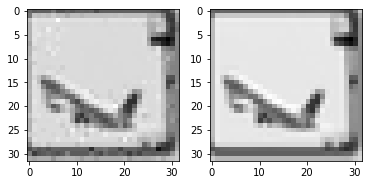

True label: 0
predicted label: 2
Time:  291.80294609069824  seconds
Initial fitness: 
 [-0.6055099310704579, -0.594181171365469, -0.5983397578333819, -0.5941927167516939, -0.6052147056600088, -0.6156947452217183, -0.6047176179981486, -0.5978630944808252, -0.6038964527662867, -0.6005629605656828, -0.6080943308779398, -0.5999046713901192, -0.6126717245367898, -0.5937280681164259, -0.5996014658641102, -0.5986177143518758, -0.5963798417533572, -0.6222517765826869, -0.6055162161513461, -0.603338033629708, -0.6057906956523709, -0.5972822621226627, -0.6027272717856809, -0.5924763957857515, -0.5919887368402703, -0.5977490025216361, -0.6273189842622648, -0.596094280350007, -0.5949876190220807, -0.6014561734502615, -0.6113533999230679, -0.6038439537299712, -0.6072703007752016, -0.6001851228229462, -0.6015864503072554, -0.613167526258182, -0.6053142593874236, -0.6043594838978015, -0.5976383202137721, -0.6042547858110796, -0.6062886411331763, -0.5976777991233465, -0.5899486011068011, -0.6163467666

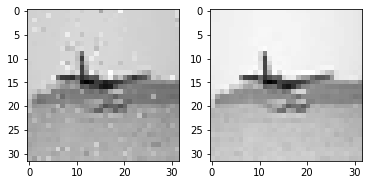

True label: 0
predicted label: 8
Time:  236.2077980041504  seconds
Initial fitness: 
 [-0.6033567820588526, -0.6028701072634164, -0.6009194342432966, -0.6123785155449651, -0.6002401560448243, -0.6013518473371658, -0.6031100070242453, -0.6049641830849299, -0.6036148188504453, -0.600252202693994, -0.6052416766164666, -0.6013942886015247, -0.6022502084665539, -0.6031707364948644, -0.6034031973726649, -0.6029834720498678, -0.6064796107539223, -0.600345931342439, -0.599851587486967, -0.6010670964981621, -0.6057321739214574, -0.6063035725559357, -0.6012442053132364, -0.6029038315206139, -0.6052650916139872, -0.6028426988078364, -0.6011954411036919, -0.6042533414948246, -0.6017637987531352, -0.5999046199757712, -0.601790311264801, -0.6006975800473509, -0.6010107504078349, -0.6039898480571189, -0.6032845165622629, -0.6007769425305629, -0.6035985978922732, -0.6090237461795718, -0.6000487366321404, -0.6091137565868638, -0.6023450921495724, -0.6070796045933222, -0.5998228239304801, -0.59997706821

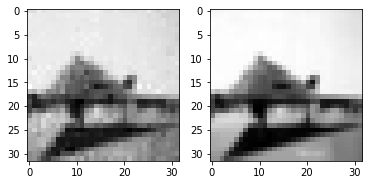

True label: 0
predicted label: 8
Time:  691.3973648548126  seconds
Initial fitness: 
 [-0.5956112797434132, -0.5956673328486592, -0.5942511245789693, -0.5966313823238919, -0.5949947758630075, -0.595486806061409, -0.597261202390907, -0.5957589740324831, -0.5958909122216024, -0.594942604390238, -0.595149025690746, -0.5964890531946858, -0.596008872955414, -0.5903514654385495, -0.5912402431720931, -0.5960593629435722, -0.5974729822983446, -0.5958695764426066, -0.5952052363829647, -0.5967416387986237, -0.5953339207403598, -0.5914842879292707, -0.592577623287371, -0.5953229278898572, -0.5946138289847664, -0.5959343091792277, -0.5968142710366351, -0.5978488302101581, -0.5961218828043295, -0.5965107498751377, -0.5926039877260729, -0.5965879497737787, -0.596021124284513, -0.5954862001233148, -0.5967912170471031, -0.5959254758981909, -0.596515650566648, -0.5943323599787488, -0.5960917188108334, -0.596325543622219, -0.5959285777314374, -0.5963496435300328, -0.59140650548235, -0.5964702813035785, 

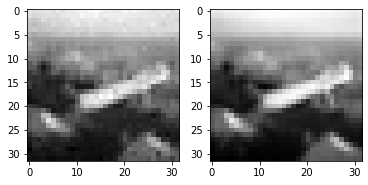

True label: 0
predicted label: 8
Time:  565.192512512207  seconds
Initial fitness: 
 [-0.5844841295389575, -0.5734362062529434, -0.5896083216153847, -0.5968914829980372, -0.5867970972440273, -0.5862929088357275, -0.5755353941805017, -0.5656771595036595, -0.5859201525848772, -0.5848743189228396, -0.5788258558824544, -0.5919191393249421, -0.5608454274273865, -0.5775204727497008, -0.5777211247400436, -0.5854876793684414, -0.5899810942736476, -0.5766738169043353, -0.5807753465091696, -0.572590038118077, -0.5782682568803139, -0.5824248775736873, -0.5782963147687126, -0.5664216521681986, -0.5774397185884226, -0.5783754233993346, -0.5768781317842486, -0.5725057488761902, -0.5825304435897884, -0.5782297055766582, -0.5750284553763922, -0.5905680200173687, -0.5785684462765404, -0.5750889947067235, -0.5740430292869724, -0.5795344429432623, -0.5701168965151262, -0.590373198357648, -0.5790684227102284, -0.5795372302277988, -0.5752669742816601, -0.587692449904381, -0.5850335570457132, -0.57587685627

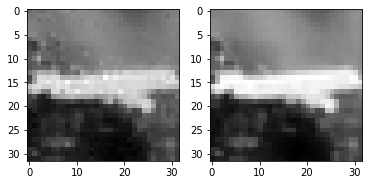

True label: 0
predicted label: 8
Time:  333.4450328350067  seconds
Initial fitness: 
 [-0.09720300853672967, 0.018565682266688865, -0.2668502093939662, -0.23953534563141476, -0.2939336580031595, -0.35323478672750663, -0.16849138722136095, -0.12702046876054673, -0.19491612733542046, -0.29020606556742945, -0.12180712834699137, -0.14637814773133054, 0.03702498409553698, -0.25855574095323863, -0.26390034969042, -0.22255692235092092, -0.31718271187365077, -0.026838317710135895, 0.00885540125106507, -0.057967336649812906, -0.13188418388643974, -0.02118318976109959, -0.20870267807788465, -0.277754017346586, -0.3251821867685625, 0.24585365335941856, -0.23340454248350578, 0.04869272526212981, -0.19964086731429026, -0.11503861961083567, -0.03232505375326564, 0.056620194269334595, 0.26004156870733686, 0.06911721589702793, -0.4040383063971794, 0.1571167174088264, -0.010358890529837461, -0.1498546323017129, -0.25386723905484027, -0.15085105570229806, -0.16875423810597137, -9.798552453282872e-05, -0

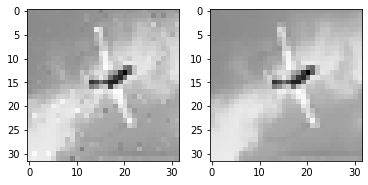

True label: 0
predicted label: 2
Time:  234.82544445991516  seconds
Initial fitness: 
 [-0.5693484717468577, -0.4660371840930114, -0.38369477761055926, -0.5755944025791352, -0.5449331472139298, -0.44007526358868043, -0.45439105326374585, -0.4212169240727286, -0.5035812478148428, -0.3768267388180989, -0.5491275641262904, -0.5727769644882875, -0.48013248921290874, -0.48770742499516906, -0.4024609370377401, -0.5160350810536184, -0.5272580474513153, -0.5599353260601233, -0.5108176988424449, -0.5018392300024966, -0.5524157436366344, -0.563118475748691, -0.48413925378898814, -0.503616786115161, -0.5336565155156243, -0.5482152007958591, -0.4866450301711668, -0.5442672623973577, -0.5528725884282899, -0.4154284663674063, -0.49707250628954347, -0.5295146756722032, -0.5414564929970891, -0.5565302243671089, -0.4948995451032715, -0.5311326360585752, -0.5359736109628496, -0.5170391888537215, -0.5505873218515143, -0.5628494910023906, -0.49444354313722705, -0.5521437932139206, -0.5155290075628164, -0.

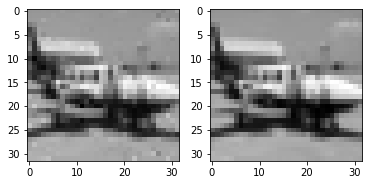

True label: 0
predicted label: 9
Time:  269.31942439079285  seconds
Initial fitness: 
 [0.6201947941553099, 0.35788858073692126, 0.439240172451947, 0.4622781373251936, 0.4238508885574116, 0.3765870972148022, 0.40797461453140416, 0.39124570993083196, 0.3904941055139255, 0.39247976603354856, 0.3847472659895211, 0.5214383780363241, 0.39401020318780944, 0.3812902691764767, 0.3609484300452246, 0.42823830598536, 0.39636283508651626, 0.4244475058745349, 0.4399141801819829, 0.4601912020107407, 0.36041910916566083, 0.4868258811173587, 0.4127097016989959, 0.40201371155059595, 0.45351409050506075, 0.4715154253925701, 0.38475796603204876, 0.37221760602833465, 0.45091087218037457, 0.39944876850028443, 0.43176787991216914, 0.37561081073718816, 0.42104710530434647, 0.4932223454765053, 0.40511265224099086, 0.568040531149003, 0.4202762409804009, 0.43567884701546244, 0.3794203594932934, 0.35623738163188196, 0.5126155066412778, 0.48726057365342756, 0.43222656452057473, 0.41396587223711867, 0.384054300733

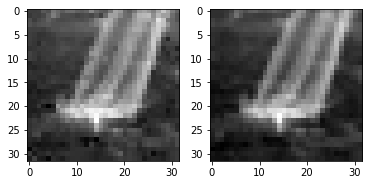

True label: 0
predicted label: 2
Time:  216.98410034179688  seconds
Initial fitness: 
 [-0.04273956476701893, -0.2918040983955167, -0.21869569988378793, -0.28563289232396594, -0.2356170516969509, 0.006233766212400155, -0.30969444961025716, -0.30769743268066363, -0.3462889525856623, -0.2450889169315954, -0.22479717889371176, -0.17875437692320098, -0.14698209475636448, -0.5010381209892414, -0.2425391606959283, -0.14184591237943328, -0.24848805869544482, -0.18735506318904582, -0.3866024310907028, -0.23230974016233075, -0.19377058373865508, -0.2481971405937829, -0.2362836956747602, -0.2919656391750905, -0.28969414808613114, -0.42943424371784855, -0.19024777413031219, -0.11608131378473088, -0.3517965968829452, -0.13417694310677658, 0.0044806818897583645, -0.2889965874409366, -0.04494651081467971, -0.2711568617559858, -0.043382191458549935, -0.09674023643787774, -0.32218709015275737, -0.28383724093570323, -0.14219064181285485, -0.42310455992872875, -0.006443738584509973, -0.0757892257697769,

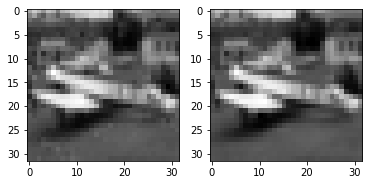

True label: 0
predicted label: 8
Time:  325.1035301685333  seconds
Initial fitness: 
 [-0.6013653625440267, -0.6011946826544301, -0.6008057863496068, -0.6008177444980367, -0.6020971276059065, -0.6033937955907105, -0.6016621568085092, -0.6026818864806376, -0.6034189745269491, -0.6000222403970737, -0.6029455063188297, -0.6022729708775167, -0.602395367445259, -0.6015618016404889, -0.6020505755715809, -0.6014398454082557, -0.603279000110076, -0.6019008319521845, -0.6028527562497128, -0.6005587747932242, -0.6010210981615485, -0.6000047872016486, -0.6028871458921894, -0.6010638040606786, -0.6011318100874766, -0.6051430490369912, -0.6036821394457486, -0.603940035178754, -0.6001317636646263, -0.6014704930059738, -0.6010561868710445, -0.6019788582832252, -0.6022868712770517, -0.6010862455847908, -0.6029332908215045, -0.6024011952572587, -0.6016554303867742, -0.603648811918057, -0.6005409698562677, -0.6014862838369363, -0.6009093798569479, -0.602090599142029, -0.6027719149400123, -0.602619870004

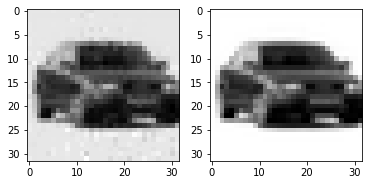

True label: 1
predicted label: 8
Time:  434.5394229888916  seconds
Initial fitness: 
 [-0.4632448899079599, -0.5574930654323713, -0.4950078897892153, -0.5585859624134932, -0.534762517178788, -0.5756675638102686, -0.4990508573504502, -0.4021382520426775, -0.5398907867024454, -0.5072215186477034, -0.527440880559482, -0.5822587745113863, -0.5615597089931386, -0.5449223923629404, -0.5270543395388589, -0.5361931525990234, -0.5394048792458259, -0.540826819419735, -0.5484536819817725, -0.3226920689807373, -0.5452724451472629, -0.5627955084540601, -0.49435202252943033, -0.5594327520446829, -0.5426466664692527, -0.5498569983767159, -0.5650946115678922, -0.5569733181414764, -0.5556704653486382, -0.5080100657936537, -0.5607993509799041, -0.5317820562262463, -0.5577616659468937, -0.5346538103150028, -0.5367256664631442, -0.5597093246126569, -0.5463945145728266, -0.49455901332044605, -0.5571393503067338, -0.5500363211054768, -0.43507898930215916, -0.552224907787224, -0.5088533299717068, -0.56973876

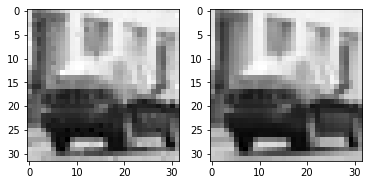

True label: 1
predicted label: 9
Time:  267.62286734580994  seconds
Initial fitness: 
 [-0.6016988797695366, -0.6015109508411716, -0.601694281145907, -0.6013206054253222, -0.6015121196287295, -0.6001406113939509, -0.6005957021130458, -0.6024633271978956, -0.6016394247926842, -0.6016442439960958, -0.6041934413467285, -0.6000955082882556, -0.6010068706646154, -0.6002775307646002, -0.6015311772245798, -0.6031982414056434, -0.6021835805567819, -0.6034741356520484, -0.6037146510775524, -0.6016962472160713, -0.6038639212881305, -0.6004840543798675, -0.6034103807443016, -0.6067171906969153, -0.6001900287063324, -0.6047839389763874, -0.6001971950403727, -0.6073257937443286, -0.6004309743940067, -0.6013255318379362, -0.6015692505629839, -0.6013827438469088, -0.6005265449238566, -0.6001378522625342, -0.6021808659655271, -0.6002439373484083, -0.600541684556049, -0.6006660248460157, -0.604952344233798, -0.6019018332625647, -0.6015134882088782, -0.6000167680019792, -0.6031627375894064, -0.602771451

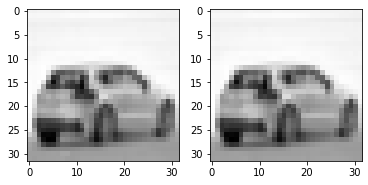

True label: 1
predicted label: 1
Time:  128.21816539764404  seconds
Initial fitness: 
 [0.6480857374069418, 0.32648486210296235, 0.053132046105636405, 0.34231734064574626, 0.5295354624184533, 0.3301967333399348, 0.0658575413890444, 0.286342130241668, 0.16772836862764712, 0.7011922736028849, 0.3292385445231495, 0.708157376835919, 0.36570455094836873, 0.37179367932800583, 0.29252441471556984, 0.17878021374977676, 0.29504244062901785, 0.37439542613785, 0.5438312923367621, 0.22846580916564357, 0.5404401048105729, 0.31880251155411893, 0.20205289417439506, 0.4777343894094578, 0.3487765905008701, 0.18124073000693228, 0.5075038923442251, 0.3469370947982754, 0.41157858049946905, 0.27425944603035673, 0.3079308853621011, 0.14784412596885316, 0.3260377425145426, 0.18325862687128341, 0.457705494201335, 0.535162012395495, 0.635359625851373, 0.3382996088151949, 0.3989015567690811, 0.4403778362819252, 0.22952031760179376, 0.2108253764648738, 0.15683748456328944, 0.38886362411834696, 0.5909455050690171

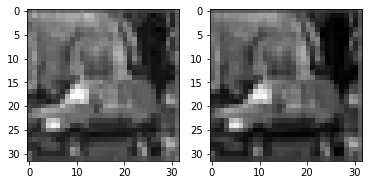

True label: 1
predicted label: 7
Time:  385.9677138328552  seconds
Initial fitness: 
 [0.44282401013237044, 0.4848164813575332, 0.4512144347793219, 0.4656976343508562, 0.5782483298043806, 0.6336979336788521, 0.5156652498531469, 0.5790922563717857, 0.5697011681415789, 0.6711848175624195, 0.48205430597272, 0.51588956895384, 0.6364180969009159, 0.4977284543129612, 0.5740391949034909, 0.588023586627999, 0.4087249744674305, 0.4504606817165192, 0.49469156632907363, 0.5009316376282463, 0.5718866943851237, 0.578389152907004, 0.7050406879417022, 0.5372971932048984, 0.5645831978696807, 0.6083238150460037, 0.5447288032156535, 0.37521482440251347, 0.46664427109803286, 0.5187955113952605, 0.46448882349847254, 0.44909964955504544, 0.48597128021724567, 0.60930370954194, 0.6557979411472002, 0.5274054642298807, 0.5948770908578064, 0.6070343116742335, 0.4959444272396434, 0.5885577242394018, 0.6072568499893033, 0.5288994596733765, 0.49617072815404173, 0.6283724637997455, 0.565945374945972, 0.597587493675

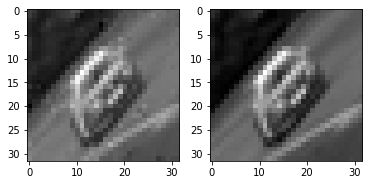

True label: 1
predicted label: 6
Time:  287.68896484375  seconds
Initial fitness: 
 [-0.5914275445689159, -0.5916235506349303, -0.5915075402124286, -0.569911367122295, -0.5940677686794482, -0.5938935704537139, -0.5865911471867024, -0.587909726216215, -0.591641044363514, -0.5814258240351613, -0.5854243972666497, -0.5846404390610727, -0.5950890621220228, -0.5878040120443249, -0.5358577054142284, -0.5942079100951039, -0.591254365206278, -0.5922410601711636, -0.5955820732452266, -0.5911806699759729, -0.5892684659950256, -0.5779252051968224, -0.5905565226769167, -0.5961437250699118, -0.5908904366581369, -0.5926695646541578, -0.589687840951844, -0.5960323706589662, -0.5948181770309953, -0.5897050295245808, -0.5925377867518915, -0.5952129606855427, -0.5931751490600197, -0.5938539438209632, -0.5873989583183276, -0.5875320730883856, -0.5967475755276059, -0.5884063809461331, -0.5898040958752261, -0.577020688084014, -0.593893974504573, -0.5588036171815389, -0.5949759487948769, -0.5801607437825194

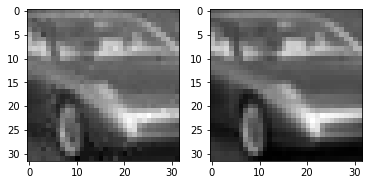

True label: 1
predicted label: 0
Time:  429.13952565193176  seconds
Initial fitness: 
 [-0.600034796236481, -0.6000104700060818, -0.6000312581299244, -0.6000306217291747, -0.60001800880484, -0.6000717007886647, -0.6000414126583453, -0.6000798749325168, -0.6000334975488865, -0.6001218304353539, -0.6000043876013355, -0.6000317851216749, -0.6000566636045975, -0.6001069937027748, -0.6000457073278435, -0.6000417373950928, -0.6000833594685635, -0.6000244942236942, -0.6000986583584075, -0.600010712055824, -0.6000597970049869, -0.600007307663604, -0.6000957591719025, -0.6000768824406777, -0.6000586858826934, -0.600007373914018, -0.6000536666802974, -0.600101148429961, -0.6000369501041425, -0.6000349404844098, -0.6000480039193303, -0.6000108555900452, -0.600104585359686, -0.6000657173588313, -0.6000269849228933, -0.6000436530751792, -0.6000261070811514, -0.6000302026445965, -0.6000703167874263, -0.6000402749838811, -0.6000201294545223, -0.6000325370536266, -0.6001133806511799, -0.60009114321702

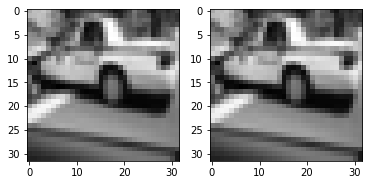

True label: 1
predicted label: 1
Time:  168.4888048171997  seconds
Initial fitness: 
 [-0.6007447608712495, -0.6004976273537312, -0.6027185339085991, -0.6014083117406783, -0.5999969382188, -0.603178965052205, -0.6013461486383342, -0.6023134427003249, -0.6004670902733225, -0.601932956394843, -0.601804011229043, -0.6000021976134176, -0.6020485909791493, -0.6000823601972414, -0.6003495476150225, -0.6010736292289856, -0.5999936425198377, -0.6001270625589339, -0.600167695710312, -0.6035525537606418, -0.6001548811529698, -0.6018174475288403, -0.6001582245624776, -0.6008529271532552, -0.6027625066257094, -0.603228709909357, -0.6008705538288387, -0.6004741424446189, -0.6023868856929926, -0.60073167117297, -0.6000724538503329, -0.6006610737293202, -0.6039960468176361, -0.6000725791391155, -0.6003534597455101, -0.600016897074363, -0.6001766327722986, -0.6001456077656913, -0.6000572226455622, -0.6004121243170482, -0.6000829588505947, -0.6016261443647424, -0.6001568707514068, -0.6010894353537602, 

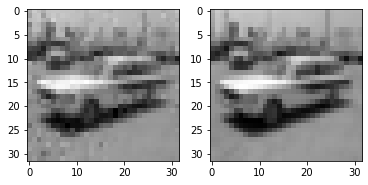

True label: 1
predicted label: 0
Time:  601.2110712528229  seconds
Initial fitness: 
 [-0.6001283070646753, -0.6000365754215703, -0.6000330448576038, -0.6000464995717779, -0.6000501457072918, -0.6001089891696639, -0.6000460846560828, -0.6000766723848623, -0.6000034227276794, -0.6000483565080688, -0.6001186051529422, -0.6000413669429252, -0.6000368790651984, -0.6000213161089613, -0.6000141556574177, -0.6000345384704434, -0.6000481926451607, -0.6000718378158792, -0.600062237758436, -0.6000167720557718, -0.6000043364243001, -0.6000286184685791, -0.6000381498951066, -0.6000148474891591, -0.6000521475024643, -0.600117495414242, -0.6000181357473333, -0.6000682095867018, -0.6000398202071361, -0.600038625965066, -0.6000640212151941, -0.6000256016787843, -0.6000391867260892, -0.6000709374658568, -0.6000211642427482, -0.6000435237829367, -0.60001531135135, -0.6000526817216459, -0.6000632971825743, -0.6001009773334114, -0.6001244318490683, -0.6000571592813297, -0.6000652921676053, -0.600067299789

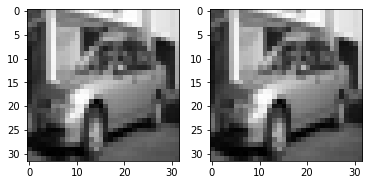

True label: 1
predicted label: 1
Time:  168.52385067939758  seconds
Initial fitness: 
 [-0.5997253164928091, -0.5993953366622677, -0.5994604860962296, -0.5999230414167926, -0.5997252695643883, -0.5996673905380704, -0.5999417012682664, -0.5996695583105379, -0.5995965014980378, -0.599494750207829, -0.5999725509884684, -0.6001346718825753, -0.5995812738333682, -0.5989516814175203, -0.599801154504006, -0.6002507735699213, -0.5994179456938613, -0.599594877004762, -0.5995226123831248, -0.5994606778350118, -0.5998966339503127, -0.5999188230953324, -0.5997156808063051, -0.60026445090799, -0.5995159370764491, -0.5994774327362951, -0.5996446388005854, -0.5994318812572819, -0.5995816774800217, -0.6002762039594511, -0.5998830447700032, -0.599810393868885, -0.6004832845823821, -0.5998557755411819, -0.5998273022789599, -0.5998586680425144, -0.5997837283191031, -0.5997553862498958, -0.5996195069105208, -0.5997919962638126, -0.5998373464201454, -0.5994149001303308, -0.6002930336295997, -0.599836834249

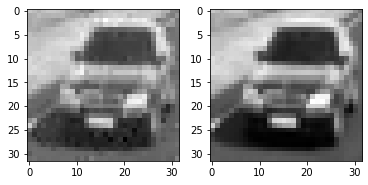

True label: 1
predicted label: 9
Time:  442.9292240142822  seconds
Initial fitness: 
 [-0.6002072673282122, -0.6001713816387317, -0.6001728683245896, -0.6003031965299046, -0.6001352963082094, -0.6001553266157531, -0.6001893566614798, -0.6003549515521107, -0.6000425935670758, -0.6000900189633869, -0.6000603804758616, -0.6003296174486472, -0.6001947586045715, -0.6001349725629593, -0.6001172045616435, -0.6000398067740416, -0.6004192683536134, -0.6000171715396097, -0.6002112584668393, -0.6001058603800364, -0.6002063762214268, -0.6004639145267442, -0.6001754081453282, -0.6003149813645143, -0.6003605813919847, -0.6001014476822112, -0.6000762553054285, -0.6001067220667673, -0.6001534907392259, -0.6003486273321956, -0.6000463163715158, -0.6000794404663138, -0.6000605131946466, -0.6001260370302224, -0.6000697222083091, -0.6001921272376365, -0.6003142158868107, -0.6001223701106382, -0.6001054396923942, -0.6002628903883342, -0.6002669325991716, -0.6000905290389376, -0.6000493602929066, -0.6001999

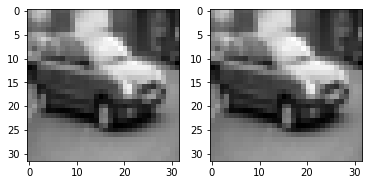

True label: 1
predicted label: 1
Time:  167.2922432422638  seconds
Initial fitness: 
 [-0.6003375000058448, -0.600308011109489, -0.6000785699471227, -0.6004747609321984, -0.6001867157330967, -0.6001848274828535, -0.6000646066285796, -0.6000345449755525, -0.6002630028449917, -0.6001188995074053, -0.6001581350454915, -0.6003838571154858, -0.6003025141608255, -0.6000802271270363, -0.6001862080539803, -0.6003917051769287, -0.6001264091401116, -0.6001091072045742, -0.6005061633808307, -0.6002422590952455, -0.6000929067626556, -0.6009300711567934, -0.6003268434034161, -0.6004111903928541, -0.6001097528830118, -0.6001841152951994, -0.6001148382574206, -0.6006180769984599, -0.6000751457622002, -0.6001183376957739, -0.6002002469509771, -0.6001312697051722, -0.6000877497432201, -0.6001495498435396, -0.6000524656719337, -0.600201113300703, -0.6002679597584596, -0.6002823142866446, -0.6001929819436749, -0.6001748953642164, -0.6000685275362447, -0.600112652947073, -0.6000882890350242, -0.6000385578

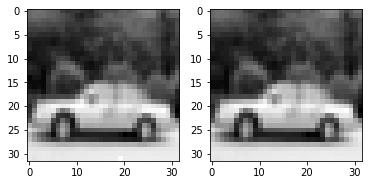

True label: 1
predicted label: 1
Time:  166.98158645629883  seconds
Initial fitness: 
 [-0.5920483576692981, -0.5856312722964901, -0.5910216390177093, -0.5962736628613157, -0.5953236550719817, -0.5886811795118878, -0.5893144718444632, -0.5902087596025088, -0.5827509846874974, -0.5934578238471271, -0.5937329391994786, -0.5929559800112838, -0.5947590391596244, -0.5945782692512463, -0.5909006330777579, -0.5939168850633821, -0.5942464235219771, -0.5937536141102153, -0.5954596262212766, -0.5925639207424647, -0.5913108465283698, -0.5894657603396161, -0.5921519505177278, -0.584724802712552, -0.5911788961225564, -0.5855031879803582, -0.5936998384220474, -0.5957418349997419, -0.5936844365655471, -0.5930245937009462, -0.593557961289206, -0.5931321235795342, -0.5932399196875578, -0.591822065907594, -0.5924592261192444, -0.5938039672025275, -0.594786553546393, -0.589601917306515, -0.5927986228491481, -0.5941272388985337, -0.5951067028483226, -0.593610634865266, -0.5961788163317049, -0.590703609365

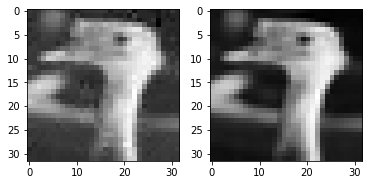

True label: 2
predicted label: 3
Time:  744.7936859130859  seconds
Initial fitness: 
 [0.740015478652411, 0.6042746134415804, 0.5208140627265657, 0.7691566106098784, 0.8169270309268768, 0.6177130699226016, 0.5123682138035501, 0.646827645915809, 0.7703564757440247, 0.6653822526492942, 0.36214821268389863, 0.6545049259065363, 0.5237566432997154, 0.7012175370050459, 0.6809868693249824, 0.6325972561951801, 0.5145440182945719, 0.7335648239770906, 0.5682794137718863, 0.5720483506969553, 0.4970490936194592, 0.6695162776149218, 0.5552806797017101, 0.6013148910154438, 0.40529750612245646, 0.6880378185708984, 0.6153145892520473, 0.58851855296028, 0.6951063664210015, 0.6662397057332219, 0.5962901681271227, 0.6287597063090461, 0.528505182845978, 0.6177152665076708, 0.3952602715614951, 0.46823389971562235, 0.6594952641453283, 0.6307635324076302, 0.6226936174884965, 0.8157339003920722, 0.610594150448744, 0.4570994559421343, 0.706892033084348, 0.5198505540825267, 0.4310769536863168, 0.580575037293289

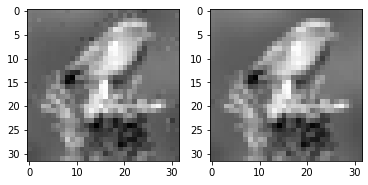

True label: 2
predicted label: 6
Time:  323.8079378604889  seconds
Initial fitness: 
 [-0.22037695396944665, -0.04640318320064657, -0.21283768422821595, -0.2702666451479977, -0.2946552423947096, -0.21563342564962446, -0.31479629699502953, -0.1523827654948872, -0.29774262940390495, -0.3756928578362837, -0.30399977598311767, -0.15835187213982846, -0.20256236302846753, -0.013264060123254845, -0.2055672443071701, -0.3088136025325918, -0.2270321705509285, -0.33381086896620304, -0.2590838178378534, -0.223457242295379, -0.21220934691964094, -0.18765642591895598, -0.2099965169951274, -0.06854633528077486, -0.14981393159997658, -0.14304595094171846, -0.30154789775980895, -0.1927751993933962, -0.17597898181329735, -0.12545466305399036, -0.3363201894479655, -0.38571401104916725, -0.2198084425665595, -0.25860305516582205, -0.06545368549861819, -0.2633502681194356, -0.32048392583416074, -0.15772995256476913, -0.22770252070621727, -0.29608453600842877, -0.34981177487820364, -0.24520196576756467, -0.

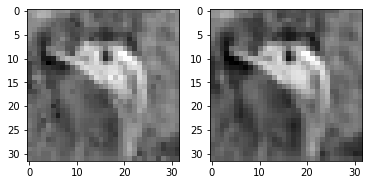

True label: 2
predicted label: 6
Time:  344.44945454597473  seconds
Initial fitness: 
 [-0.25301537852281614, -0.17803833056544005, -0.06347509889653533, -0.19108236515611735, -0.29926399635626033, -0.3689019495046284, -0.18516438675854313, -0.16535322844297962, -0.2024623315911562, -0.1780627712436842, -0.17586003206180448, -0.17385222453288862, -0.1383774059510025, -0.3403046667065649, -0.35429898053355213, -0.4091885171659385, -0.24279962214481296, -0.21711953244275292, 0.007665522005449066, -0.2184781034764357, -0.12991125216832136, -0.209145646507239, -0.41476957996613306, -0.1200338180364953, -0.38256602779869087, -0.2314029965859118, -0.4080479932743476, -0.22574606917136567, -0.19103952874386487, -0.4112532083595521, -0.3691439947666647, -0.049818474156918285, -0.18244813865643314, -0.09017097995915235, -0.36304226761303127, -0.14928821758584876, 0.017270265180950456, -0.31827916184934135, -0.20138045935785961, -0.24879383249412612, -0.2349253088536119, -0.2996582367482572, -0.

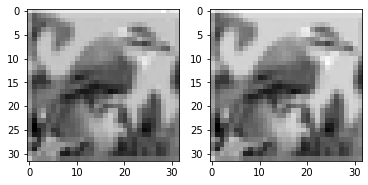

True label: 2
predicted label: 5
Time:  17.62650418281555  seconds
Initial fitness: 
 [-0.5997155628423141, -0.599794945884714, -0.5998798760272404, -0.5998033740033749, -0.6005468698154465, -0.6007069850348266, -0.6008256165744419, -0.5998731766745783, -0.6000228728484212, -0.5999196012582383, -0.600613601902866, -0.6004511518957789, -0.600099383547521, -0.5997809255856026, -0.6000281644277428, -0.6000040108540601, -0.6000282602851212, -0.5997025279061405, -0.6003109988454195, -0.5998713805742301, -0.6002009752695511, -0.6000337591444955, -0.600435210897116, -0.6000383092434515, -0.6002695186336516, -0.6004115506796638, -0.5999232134843809, -0.599861704378641, -0.6002345396284456, -0.5999182551806843, -0.6006459020725401, -0.6000525612962283, -0.6007741754208906, -0.6016075002012116, -0.6002501893430205, -0.6000017337705511, -0.6000818495187703, -0.5998296200865453, -0.5997597247291511, -0.5997635820244048, -0.5997482997382327, -0.6017254222954744, -0.5997291229116111, -0.600535587059

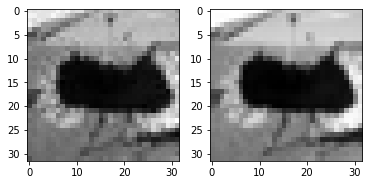

True label: 2
predicted label: 0
Time:  1156.6763889789581  seconds
Initial fitness: 
 [-0.30776884078742006, 0.015366074835412136, 0.3192237494551112, -0.1840530776256427, -0.2137830174654917, -0.03867843337345969, 0.029797866939115625, 0.13664683072071615, -0.10922943227913143, -0.21125105258465596, -0.421565479280977, -0.4430772902767818, -0.1745816165643453, 0.023591261735351754, -0.32322395401802584, -0.19599383185944064, 0.018878945196526803, -0.20948976561725413, -0.143204241745251, -0.27775830000135027, -0.4162349608450065, -0.1656299374832732, -0.04087205877038491, 0.043098272819350136, -0.12319598026685594, -0.08603495194204464, -0.10002720104247778, -0.2710065921578807, -0.44193290520544515, -0.12601874556744644, -0.15267993743022346, 0.04722390537507684, -0.17323479306698594, -0.1958731590952418, -0.017314324878327347, -0.08398540768786283, -0.2751253366217335, -0.20252071238840882, -0.06704847981256734, 0.1768392878441893, 0.04792249652750663, -0.1751827088257295, 0.103574

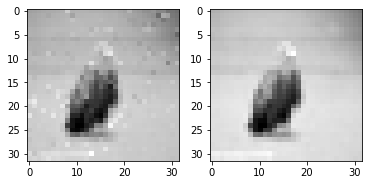

True label: 2
predicted label: 6
Time:  305.6234333515167  seconds
Initial fitness: 
 [-0.5932501079438284, -0.5949701964589871, -0.5964680459518292, -0.596891662652349, -0.5946510960600143, -0.5940100241436831, -0.5943521636987329, -0.5942035097906045, -0.5931883406449333, -0.5883256545290335, -0.5962622242748334, -0.5966134558270538, -0.592872595688976, -0.5967869559491867, -0.5938188165107481, -0.5927308072212354, -0.5949862153727561, -0.5950735645392206, -0.5972270875340999, -0.5969111373017648, -0.5955139245002494, -0.5908651265659034, -0.5978143081694338, -0.5920900338010159, -0.592672384044679, -0.5929944948508385, -0.5961767546157575, -0.5961927875984391, -0.5953883954000336, -0.5954064498654008, -0.5923026847418346, -0.5928734630027911, -0.5942943832969061, -0.593538231882405, -0.5968040310642857, -0.5958747603102006, -0.5977117888266588, -0.5954463435563931, -0.5940908528058716, -0.5951560126429729, -0.596690305591004, -0.5971370741272723, -0.5945646736899557, -0.592465934700

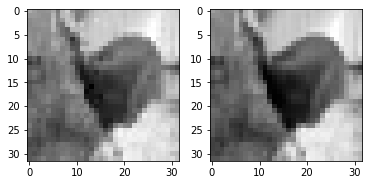

True label: 2
predicted label: 4
Time:  416.07501888275146  seconds
Initial fitness: 
 [0.0018721320734578772, 0.0622723590537351, 0.020906583560800135, -0.10976344871582783, -0.12797513657115367, -0.04344588328501933, -0.16292769996597126, -0.08123541775172621, -0.17861718104083038, -0.16936468536795526, -0.060022705889275746, -0.09377003279266125, -0.0665322214772936, -0.08825772112158259, -0.027694905237882567, -0.10161819694710153, -0.08780631316910972, -0.23037608579063643, -0.16928728535636642, -0.08743770292918107, -0.03339132822119584, -0.12611776110741524, -0.20730292897434646, 0.1770637311344611, -0.05894097640471574, -0.24377806002052763, -0.20500584538591968, -0.1933156918696169, -0.09334624867076197, -0.2471243809440581, 0.06081711566785211, -0.11306360564127782, -0.16462953458458476, -0.20956956865961232, -0.08387927698767339, -0.09376925236399505, -0.08664379925121751, 0.0027315472119356643, -0.09026509653157716, -0.030674163225196255, -0.0006951819255378022, -0.19263112

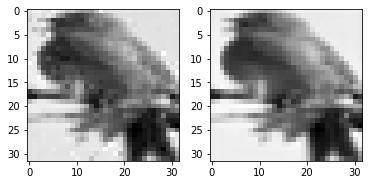

True label: 2
predicted label: 6
Time:  473.9722180366516  seconds
Initial fitness: 
 [-0.5716947136874999, -0.5802098819985331, -0.5887407443937218, -0.5762268266840236, -0.5804142874996991, -0.5894637132662883, -0.5839625751508619, -0.5824000983194084, -0.5717098217532385, -0.5811542907794655, -0.5762119904630869, -0.5857608402439987, -0.5852709967370785, -0.5670755924019624, -0.5745279408116528, -0.5794521274590417, -0.5898988506909626, -0.593349350356623, -0.5866524692530035, -0.55243431505459, -0.58595851201234, -0.5749983008741706, -0.5102658469741115, -0.5467093227777586, -0.552887900736804, -0.5748596486025649, -0.5755841276057828, -0.5859062399919226, -0.5835218285542016, -0.5827025187887275, -0.5877989109476769, -0.5882582282126505, -0.5840765459592954, -0.5832338033411851, -0.566391035883226, -0.5816142780766599, -0.5507288742389967, -0.5757195648816136, -0.5651040627331116, -0.575950407049708, -0.5791218511571198, -0.5761017069959957, -0.580733471555476, -0.5592021197385865

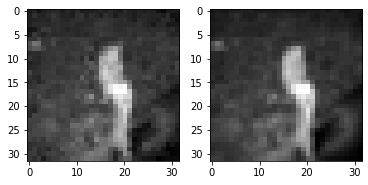

True label: 2
predicted label: 3
Time:  590.2286651134491  seconds
Initial fitness: 
 [-0.5613598628027754, -0.5641622642803118, -0.5663947852939542, -0.55601817734305, -0.5557116671779986, -0.5465974075171777, -0.5677470192236055, -0.5692359423663957, -0.5585060107917508, -0.5683613404420095, -0.5656204330291004, -0.5643318336672882, -0.5568109858660402, -0.5169128880074245, -0.5599491461331932, -0.560659614435886, -0.5653887429139033, -0.5241669780141327, -0.552406929760404, -0.5694584739260317, -0.5704573183694139, -0.5580154367845596, -0.5622735133351618, -0.5637337973383696, -0.5311520594255036, -0.5585324836292743, -0.5480728948249957, -0.5505585543453538, -0.5628569625653757, -0.564721395790458, -0.5519147189264784, -0.559144973512216, -0.5356113525623982, -0.5596325131794608, -0.5603727019224319, -0.5500327965298111, -0.5585045644423408, -0.55482048330841, -0.5586853294347396, -0.5613015961523189, -0.5597929038482622, -0.5682472334846356, -0.5620317995495268, -0.566515214541104

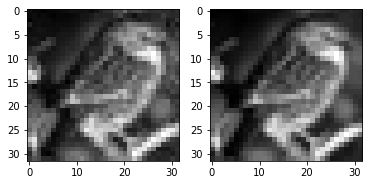

True label: 2
predicted label: 6
Time:  1039.4174513816833  seconds
Initial fitness: 
 [0.9280807882075163, 0.9329632161428626, 0.8315438081955024, 0.8782038563894646, 0.8822355523952676, 0.8353465477350087, 0.8715229598761275, 0.948661202015533, 0.8748041453047952, 0.8943963829319398, 0.9271193378044031, 0.9035494339234511, 0.8953590194397085, 0.8885245053293843, 0.8990086424302526, 0.8984980146514535, 0.9026342161374367, 0.8988515491678557, 0.9266373106304425, 0.8918724145790069, 0.8985850612218135, 0.8795402837813631, 0.9139403297781361, 0.8774272952010959, 0.8594129180232746, 0.8869844864159907, 0.8915833341230557, 0.9135968438843923, 0.9119992816726483, 0.8376549827108677, 0.9401044449902817, 0.7628425942901547, 0.8729264239612491, 0.8820740434706725, 0.8861335075687019, 0.8698836124057907, 0.8544938892749331, 0.8560232837534332, 0.8771092064154133, 0.9037622268107031, 0.8090126897182914, 0.8940235600993042, 0.9075005737018125, 0.9163631953551008, 0.8835859039864643, 0.85658663544

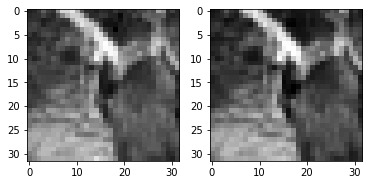

True label: 2
predicted label: 7
Time:  273.11266136169434  seconds
Initial fitness: 
 [-0.6101786025946444, -0.6096698542965304, -0.6165466362674241, -0.61082515802487, -0.6165479485718268, -0.6063202569359663, -0.6198258934386848, -0.6159398933462408, -0.6064718367226469, -0.6197110641864921, -0.6049374480925664, -0.6195314262402147, -0.6224122249726891, -0.6241593031232031, -0.6125474753431761, -0.6174046751407293, -0.617543328043503, -0.6280198462261543, -0.6300851956010427, -0.6283037617906185, -0.621562582931844, -0.614530726625614, -0.6255416242844176, -0.6329699023314334, -0.6120777946380848, -0.618902173226937, -0.6087113275165557, -0.6217073662556019, -0.6098156327431618, -0.6250385731817784, -0.6213736402326403, -0.6093586925151999, -0.626112532747129, -0.6138756336632066, -0.6107406340664812, -0.6208253047224483, -0.6132527110083147, -0.6033046813260392, -0.6062458427350987, -0.6085853342907424, -0.6164571036897725, -0.6168197296505225, -0.6208424629435058, -0.6279452705051

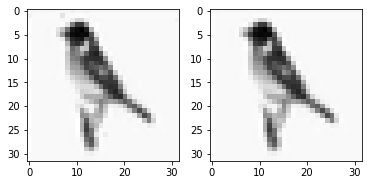

True label: 2
predicted label: 2
Time:  142.85025453567505  seconds
Initial fitness: 
 [-0.6000951008318212, -0.6002949299348035, -0.600451413804013, -0.6006026049787684, -0.6001086769580896, -0.6002778275840119, -0.6000916927915505, -0.6004414863084286, -0.6003138234798269, -0.6001227493676011, -0.6002117318836989, -0.6000759680105483, -0.600139493600709, -0.6000740206398413, -0.6004598772686147, -0.6002160496952436, -0.6001411339118394, -0.6001134486340285, -0.6003867502035447, -0.6001988932686445, -0.600205446491328, -0.6001227266902471, -0.6001357483339492, -0.6000462018220231, -0.6009046969247049, -0.6008560995875112, -0.6001652489607416, -0.6004040111607225, -0.6006151750578697, -0.6003429162677903, -0.6001654197557673, -0.6001918470540657, -0.6007041583668575, -0.6003054952719236, -0.6002090455397933, -0.6000664048964331, -0.6001647703771591, -0.6001496023426078, -0.6004458747976473, -0.600099407275328, -0.6002739107484991, -0.6002229380940667, -0.6000485386045071, -0.6001277504

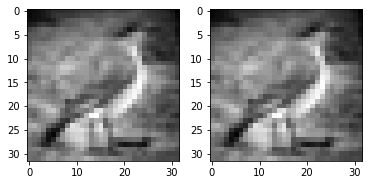

True label: 2
predicted label: 2
Time:  132.34423065185547  seconds
Initial fitness: 
 [-0.6018181242858847, -0.6020841502054782, -0.6012547043360381, -0.6016725863467511, -0.601516263684328, -0.6008108328321566, -0.602212475019433, -0.6008768013228248, -0.6003123321482069, -0.6028261968222395, -0.6017332053465932, -0.6024219901428869, -0.6016618298023346, -0.6026683999830806, -0.601323203297062, -0.6015871293289686, -0.6005934309173464, -0.6029320082228554, -0.6013862627383149, -0.601627451534718, -0.6006960100623475, -0.6008304125784146, -0.6042877081383153, -0.6026713890302239, -0.6003337568400251, -0.600881696195501, -0.6017844079769017, -0.601999752495863, -0.6039734256370977, -0.601403654398058, -0.6003620670266392, -0.6010169307651199, -0.6010608690403103, -0.6008305921354036, -0.6013514366102467, -0.6006830567694653, -0.6046713470565834, -0.6009901445710133, -0.5999666157627624, -0.6013931383588473, -0.6011223942157098, -0.602630332709513, -0.6006452013008332, -0.60070314513003

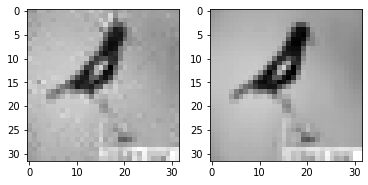

True label: 2
predicted label: 0
Time:  620.4728546142578  seconds
Initial fitness: 
 [0.9874601353587115, 0.9866061752246421, 0.9851236687303908, 0.9903522931138692, 0.9906290760973763, 0.9818300043387886, 0.9777520235367627, 0.9905787222920895, 0.9905378762399489, 0.9890476631362566, 0.9871616738742293, 0.9908918128641415, 0.9818709948490206, 0.9903894490103597, 0.9825340718075591, 0.9923479388833419, 0.9904096194300686, 0.9877657529434397, 0.983569870585443, 0.9929317656571643, 0.9938259872862598, 0.9836696581184976, 0.984003643988256, 0.9792672888567318, 0.9784551216180251, 0.9876881099567842, 0.9815442975493216, 0.9870201608238411, 0.985203255544349, 0.9876003530238892, 0.9904126478026355, 0.9874646784995653, 0.9878880109426003, 0.9900886492733578, 0.9943962868520517, 0.991063033021977, 0.9826605704280588, 0.9905923746949015, 0.9892038342503153, 0.9853591352133694, 0.9828854335997891, 0.9879976865451894, 0.9903277980683629, 0.9880619888658282, 0.9915387904983287, 0.987119406217674

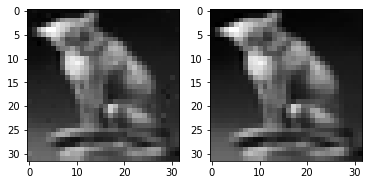

True label: 3
predicted label: 2
Time:  173.3370749950409  seconds
Initial fitness: 
 [0.45577662172081634, 0.3955762299423155, 0.06403972353173715, 0.4732236045156775, 0.2737900162469592, 0.30877458025300314, 0.3911954793727881, 0.3323169926107053, 0.3843902308590502, 0.36425113173841417, -0.1739428431778442, 0.36128329519888513, 0.3028634492757355, 0.39743990006975893, 0.27114723710363936, 0.3891286236455421, 0.38439218645202977, 0.233026361395465, 0.2000301147004529, 0.38395195517507347, 0.3344160288126186, 0.3349031836528631, 0.12737965830769402, 0.3585120766119254, 0.3072217798395189, 0.05628877419721931, 0.28840899460081154, 0.30925785338194056, 0.31313617943694905, 0.3405376985113058, 0.28330404950578925, 0.37786702382956683, 0.09147341777125352, 0.28490584585516987, 0.3351639188533639, 0.4888904539294815, 0.3044568676563756, 0.4500251363108202, 0.11379916634818624, 0.22175811522296313, 0.049961020839923764, 0.1925442449387116, 0.15097066331819414, 0.12433604797884262, 0.4153420

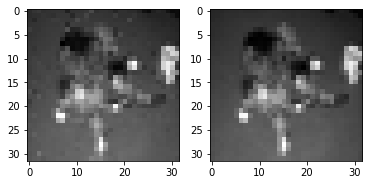

True label: 3
predicted label: 0
Time:  282.0391914844513  seconds
Initial fitness: 
 [-0.24967762278241049, -0.22248525178195877, -0.2565839381751128, -0.3165852849244427, -0.27312817527398214, -0.26842036075754605, -0.2710606952588738, -0.3131633099212332, -0.2649837849054939, -0.2897885787295421, -0.3618443887832967, -0.31806170009496837, -0.24637306326691935, -0.22660604200060921, -0.11326931414427013, -0.29807596061259584, -0.27668700646975053, -0.24114786239428418, -0.2836590065310258, -0.32503203068784625, -0.3294301425311943, -0.20760319551840448, -0.2524919713290482, -0.306902854036889, -0.3022103301586071, -0.23269714039707456, -0.32270788151844687, -0.24341255527997543, -0.1972589789430251, -0.2823276423712053, -0.3571688824155684, -0.3280854718111533, -0.3438775249288628, -0.268960488275216, -0.258809620119481, -0.3102369579862646, -0.2762420120521353, -0.2568614816274954, -0.16643230055473976, -0.29721299015676794, -0.2307928746774658, -0.3083997347543722, -0.1854377209748

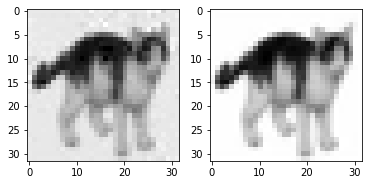

True label: 3
predicted label: 5
Time:  792.6434102058411  seconds
Initial fitness: 
 [-0.5718121427387057, -0.5760419694500936, -0.5665736319550216, -0.5561290925595375, -0.5627414902087307, -0.5597399550927948, -0.5415465025290483, -0.5467527600212302, -0.5560246770990803, -0.5668728587052886, -0.5672972979102022, -0.5481179770141574, -0.5662386994401594, -0.5577373422104214, -0.5694957871437415, -0.5655032550486018, -0.5469795735527779, -0.5783500026292517, -0.5742723296801624, -0.561383166641701, -0.5682119713777041, -0.5561119496762289, -0.5559288990141431, -0.5782306190995754, -0.5710915742518402, -0.5699378999122003, -0.5741371367513134, -0.5662232971602579, -0.5851306616309268, -0.5598657598727406, -0.5646685128494016, -0.5691335214023863, -0.5566750738160454, -0.5643115633142562, -0.5638800461205682, -0.5571494516318826, -0.5663006995297273, -0.5667497348162124, -0.5668358125899734, -0.5619895256515948, -0.56290203494088, -0.5570260129196662, -0.514850865482025, -0.54678274023

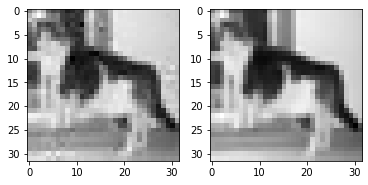

True label: 3
predicted label: 7
Time:  825.0890362262726  seconds
Initial fitness: 
 [0.663067478826163, 0.7173946734320027, 0.6463925706154637, 0.7096638959385292, 0.6071393129914141, 0.6856528032177824, 0.4822209597659525, 0.6615621349864553, 0.6797233152085866, 0.6855244376282196, 0.6747897762281418, 0.701233432168086, 0.5906335324054613, 0.6493395244224434, 0.6716700423864961, 0.7632267519366954, 0.6979408766608317, 0.6550184998889144, 0.636321498338063, 0.7272303001119487, 0.5611444778631169, 0.6159422727517267, 0.6698342168406424, 0.6404890698200024, 0.6538010741213444, 0.7173210465235589, 0.6193485856077983, 0.608790150648574, 0.6969236413509429, 0.6753436115821083, 0.6450590664366294, 0.7108965253241442, 0.673960570337755, 0.6255261084456392, 0.6536603738660738, 0.7253388702878123, 0.6896396542187724, 0.7017772620956039, 0.6065917950218203, 0.6769054100284104, 0.6581160744291732, 0.6474044515131301, 0.5162386094582384, 0.7366152488319573, 0.5131040434474214, 0.7268200829571204

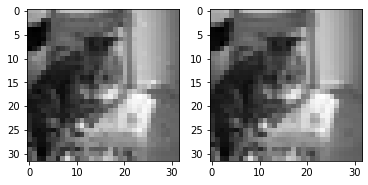

True label: 3
predicted label: 2
Time:  267.91427659988403  seconds
Initial fitness: 
 [-0.03033912334049066, -0.18937377202093586, -0.2592002112827334, -0.30715933564743914, -0.20890923461898078, -0.3266893389082337, -0.168812448799271, -0.28047374367800326, -0.170137236420123, -0.23028725807006253, -0.27515310149527955, -0.27158498968274236, -0.2565913411006613, -0.2087186471930067, -0.06490361507469317, -0.23066051408089966, -0.1603274499745092, -0.1820271345479619, -0.28525168123661604, -0.2302921159300119, -0.04692322807682214, -0.22591956776655678, -0.26178596716496905, -0.15222162702150474, -0.2821445321008432, -0.30192292583049796, -0.2544733827882608, -0.1599908788376359, -0.24932307405333845, -0.07317797906039303, -0.28615391691771325, -0.2335859927886516, -0.2830707537588927, -0.22108517706082048, -0.3197990268689763, -0.20261433732364176, -0.31247276246257016, -0.30179163887979193, -0.3422715216299794, -0.2577328851090275, -0.31351698547441587, -0.288577428570354, -0.235072

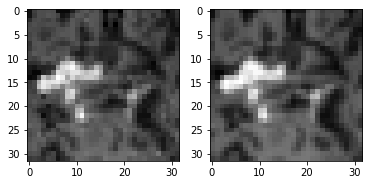

True label: 3
predicted label: 6
Time:  377.4984097480774  seconds
Initial fitness: 
 [-0.5882822816617524, -0.585357118791977, -0.5837880258788201, -0.5829995503546797, -0.5810257381896249, -0.5848162293993591, -0.5843384057859533, -0.575055868731922, -0.5845497666635928, -0.5800840226649636, -0.5842014715877527, -0.5820544436445255, -0.5881420202637435, -0.5716674630318392, -0.5776448598550535, -0.5849166432207944, -0.5864161538633869, -0.5856167134240402, -0.5888595868370377, -0.58263046156365, -0.5882357811444356, -0.5803433299379062, -0.5833424866059361, -0.5823020250401798, -0.5918439776796969, -0.5919435644148351, -0.5855648201224892, -0.5841180531051189, -0.5856641227723519, -0.5824903905941644, -0.5820617526986456, -0.5846267123180382, -0.5845074744560962, -0.5892354575172334, -0.576429888987057, -0.5855508168114589, -0.579912646050276, -0.5824791043234356, -0.5793722616180816, -0.5857029235591974, -0.5897802576233929, -0.5863524910012758, -0.5816015874879324, -0.5785838203559

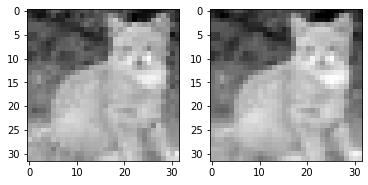

True label: 3
predicted label: 5
Time:  477.67230105400085  seconds
Initial fitness: 
 [-0.12935964823286894, -0.2997783070317623, -0.30544050626498703, -0.029248726240955314, -0.40111012732452234, -0.295784047285801, -0.3457059719948282, -0.3707090480672255, -0.38605481040646494, -0.3963091724645132, -0.1703371537043796, -0.3556450231947104, -0.37690712957886663, -0.11661394378676718, -0.38286992935413466, -0.41791388817766184, -0.327649175804501, -0.435626766764576, -0.43100335856901717, -0.39544484640004185, -0.4359222512925922, -0.2871996531612525, -0.16804442560309252, -0.23544855649132435, -0.30157444036842407, -0.37816345277434815, -0.305725642189848, -0.3805203021505865, -0.4020311180456547, -0.3482210785478506, -0.35959917320956697, -0.32134250269152453, -0.38679605499335656, -0.4236656260602583, -0.3856939157873569, -0.35868851332009233, -0.428865712759555, -0.3743205229206624, -0.3941260079372422, -0.28445891443422877, -0.21773445659112806, -0.46809035064988236, -0.096013212

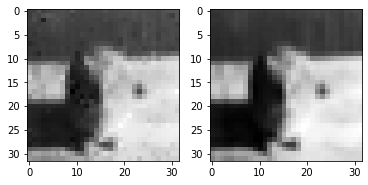

True label: 3
predicted label: 7
Time:  286.8593349456787  seconds
Initial fitness: 
 [-0.5887986893366494, -0.5715050315080334, -0.5850593427384313, -0.5851431418210125, -0.5656087576821537, -0.5745594612376281, -0.5661789058980512, -0.5796515633886833, -0.5811940819228057, -0.5832046160513888, -0.5781647779352194, -0.5900135220531035, -0.5806681704088359, -0.577770262901788, -0.5824928209725793, -0.5832304698267443, -0.5708444285185986, -0.5900852399140618, -0.5802724352492035, -0.5832745417772671, -0.5984982402954528, -0.5046541355180303, -0.5845415650954504, -0.5775056807897198, -0.5809451155723864, -0.5875690360245522, -0.5739941792412113, -0.5809089213568643, -0.5860208881923098, -0.5779816624623257, -0.5827039406443083, -0.5799987904834406, -0.5788454284464276, -0.5758257262304766, -0.5825389853351308, -0.5917662653942437, -0.5736242590817637, -0.5822758729378597, -0.5921682920117398, -0.5555602973697815, -0.5780518363525908, -0.5750332549137664, -0.5818341073436855, -0.58914304

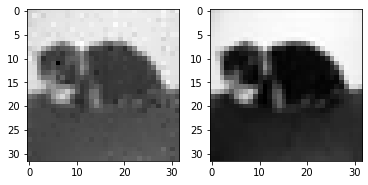

True label: 3
predicted label: 5
Time:  352.729496717453  seconds
Initial fitness: 
 [-0.5457671599268208, -0.5090089303195477, -0.5597245226295191, -0.5472407478324948, -0.5608573147915373, -0.5592904532789889, -0.5159686133225537, -0.5134380817189288, -0.5307116403836647, -0.5521670025973211, -0.5514786929423358, -0.5463061384762352, -0.5517545081505781, -0.5599711960242296, -0.5475698353363768, -0.5615711032348408, -0.5470887616174779, -0.553209948164461, -0.5519024437552261, -0.5377522695258693, -0.5453400220676852, -0.5533674395239152, -0.5759272169620845, -0.5367959354040192, -0.4969610839894474, -0.5311911694660745, -0.5278205741663755, -0.5256372761385651, -0.5311750516182934, -0.5409981318087871, -0.5460714884799777, -0.5396089444149473, -0.5672193246478533, -0.5522658852126934, -0.5668260518105888, -0.4912453485576024, -0.5550886042259282, -0.5487411397482598, -0.5016085780212032, -0.5520409322785339, -0.567521443656112, -0.5568251781158063, -0.5527985071120105, -0.5516137271

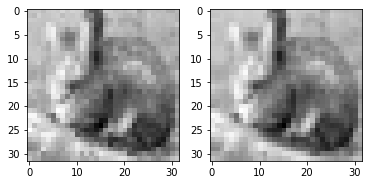

True label: 3
predicted label: 2
Time:  442.9051797389984  seconds
Initial fitness: 
 [-0.4936868421497599, -0.5338634126985027, -0.49516495497091184, -0.5342263120471241, -0.5181351579220388, -0.5305378230112014, -0.5141595672285999, -0.504225101390753, -0.5111366069467196, -0.536491792556778, -0.4797746362374773, -0.5169727170372935, -0.5246695604937253, -0.5045911757109766, -0.4729970377887357, -0.5000781490383585, -0.469373692440086, -0.4769273821072253, -0.5119398042278801, -0.5055344580762058, -0.5116199745327354, -0.5002546418338527, -0.5106634139964163, -0.48653521184135, -0.5322576801254212, -0.5207291047753295, -0.5301105733090652, -0.5288019219843978, -0.5097561249003294, -0.5039190932375212, -0.5050931407388249, -0.511500329950466, -0.4921789540303808, -0.510636866257727, -0.47520026711488217, -0.5065753881981555, -0.5478851592372631, -0.5158215940852637, -0.5344554021299873, -0.5058337073851488, -0.5418668434586845, -0.49463228593781783, -0.5110578406378002, -0.43186133810

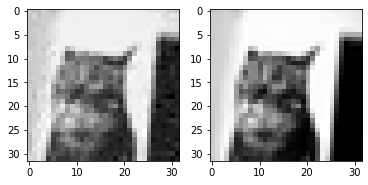

True label: 3
predicted label: 2
Time:  779.1490261554718  seconds
Initial fitness: 
 [0.6668744241253693, 0.6218606436806826, 0.6470696235040325, 0.6541790460015774, 0.7817875933627217, 0.5650036032053545, 0.6913302430958983, 0.7100495232097874, 0.6133799398555644, 0.7701680309416161, 0.684775716767833, 0.5717430705410252, 0.6697757794285376, 0.7119925037957631, 0.6691573450594395, 0.6486149084458165, 0.6287425818092884, 0.6391639255541226, 0.6619360085579724, 0.563645963998852, 0.774978740136892, 0.6625690552380523, 0.7842721453851109, 0.6173522409851384, 0.7882081720884146, 0.6276875470622042, 0.5861361851938509, 0.6741402659603807, 0.620500001706259, 0.7214640844830714, 0.6378606982353341, 0.6837672751494217, 0.5527866464022122, 0.6105108843380486, 0.684491020045503, 0.6312758023039898, 0.7824587837001905, 0.6706807017400144, 0.7386482119315625, 0.6094537035030063, 0.6919856576250443, 0.635849083248128, 0.6348740202239577, 0.7218002159311852, 0.6504691358167187, 0.690662818387616, 

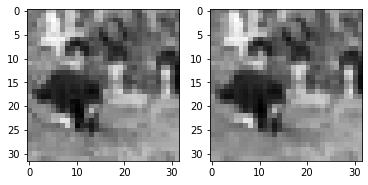

True label: 3
predicted label: 2
Time:  257.46295261383057  seconds
Initial fitness: 
 [0.5021928789609829, 0.5591095843698521, 0.42174709110315134, 0.21283839490539713, 0.4307728128643987, 0.3717330261510011, 0.35004087156859665, 0.23959859003465972, 0.36430716770525473, 0.2943682861410957, 0.3286295648521115, 0.12241026147826974, 0.3259430125939123, 0.21488790478558656, 0.4133706040106595, 0.26988108935539573, 0.3929565070771851, 0.29282349238417205, 0.21196692595692562, 0.34137937107401695, 0.09773425685902373, 0.33466411312974886, 0.5256267303435795, 0.18553772260426482, 0.24387224462320062, 0.26267856105543474, 0.296354028349905, 0.3595159168402556, 0.45885715919248615, 0.4014927642704016, 0.39187310217803795, 0.36411285219328093, 0.28364791800024464, 0.3281859282790599, 0.39580980315462444, 0.2766866114813876, 0.2795338526769682, 0.26625634093888373, 0.20259561915872695, 0.29696727392751476, 0.3064758465254992, 0.1731099729383982, 0.43861619028773685, 0.30988301511039934, 0.30086

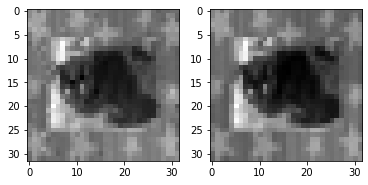

True label: 3
predicted label: 5
Time:  271.1596953868866  seconds
Initial fitness: 
 [-0.600064443315621, -0.6000359800088322, -0.6000803285843336, -0.6002999165710216, -0.6000551064190818, -0.6002758367601821, -0.6001112661644404, -0.6000872437082589, -0.6000331860993464, -0.600048839492523, -0.6001951867086595, -0.6001218610121908, -0.600034772681032, -0.6001952333579469, -0.6003935102200192, -0.6001364781921302, -0.6008735216090555, -0.6001404182584074, -0.6001058869772584, -0.5999887987456601, -0.600013604921775, -0.600084280520479, -0.6000513475796497, -0.600168386855029, -0.6001479574132866, -0.600188720475616, -0.6001816220351547, -0.6001834466311947, -0.6001092131442852, -0.6001537016366498, -0.600218636923905, -0.6000146874467793, -0.6002903872909936, -0.600022691680858, -0.6000458356655791, -0.6001202868522647, -0.6000738929616021, -0.6001035493488207, -0.6000064683729248, -0.6002057082472839, -0.6000812404046107, -0.6000624704445923, -0.6002409402380603, -0.600317650314455,

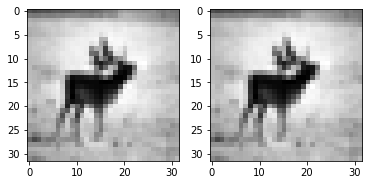

True label: 4
predicted label: 4
Time:  119.80050992965698  seconds
Initial fitness: 
 [0.7207115948984781, 0.6097534746495887, 0.6705052367083097, 0.37501846238491754, 0.6516057747109175, 0.5295799691197256, 0.7144448646319052, 0.3846512038003524, 0.640053364509882, 0.7522593519236436, 0.5553698895264821, 0.6596617479929605, 0.6347435728591264, 0.7550928160548751, 0.6606235332111275, 0.6317665445760132, 0.5435553853851133, 0.6101329780911278, 0.6864033908551911, 0.6653860505080499, 0.6485750872638515, 0.6838591746191782, 0.66930212980456, 0.7352237178892486, 0.6368173482949588, 0.779799236173877, 0.6538552346770137, 0.7064383707923756, 0.721430478656828, 0.729635589736197, 0.5852542443054052, 0.6657245926283435, 0.5708687368042389, 0.5775714091734051, 0.6495819685260013, 0.5169366686550676, 0.6925244030373243, 0.6836314689615783, 0.7675206774865131, 0.6600096167731901, 0.6081370576586849, 0.5705286800186788, 0.5235905902149938, 0.6752587241102832, 0.6571171156627875, 0.610797759801267

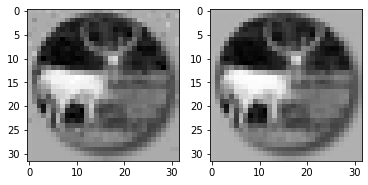

True label: 4
predicted label: 1
Time:  256.3243646621704  seconds
Initial fitness: 
 [-0.47523775230876375, -0.45349909301976543, -0.45308533904810355, -0.4138845288689765, -0.4683915571318656, -0.4519502715066054, -0.37053092477821614, -0.5098518086601602, -0.4673873264542451, -0.46291889385994767, -0.4500351138363796, -0.47886103547957937, -0.3949115662839698, -0.465158782456353, -0.4217855869225239, -0.5236956434800366, -0.49618472291534094, -0.4936118601230871, -0.42574315718396083, -0.42183405295266174, -0.37025192101730786, -0.49485456658401406, -0.4294586881430369, -0.3864196864393635, -0.3981834928642624, -0.4075246075247918, -0.46316959958444764, -0.4125122438831227, -0.5274044331036145, -0.30886673601341436, -0.4855177216112968, -0.4996264925633577, -0.35184181685156357, -0.44189008614990033, -0.45876174880863085, -0.388223558737985, -0.4542798458827332, -0.5272073996441133, -0.3944890288791917, -0.3060034138923724, -0.4067039666706387, -0.38553611954380274, -0.4425678351736

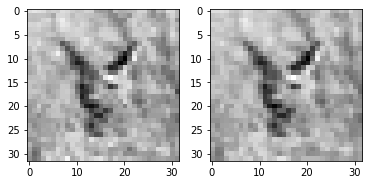

True label: 4
predicted label: 2
Time:  310.93069434165955  seconds
Initial fitness: 
 [-0.5895648248797533, -0.5952000486477824, -0.5934390824029023, -0.5945982281347646, -0.58994482249693, -0.5944903480988997, -0.5960277392144765, -0.5934262638110206, -0.5887784535996322, -0.593836117968322, -0.592809063625094, -0.5925891060810923, -0.5920709584495057, -0.5953193230244229, -0.5919475655708142, -0.592469136936845, -0.592162751240785, -0.5952955184329469, -0.5953550775965035, -0.5945274866888426, -0.5930052387794449, -0.5950638692168854, -0.5938235158631164, -0.5965602326911627, -0.595293848880297, -0.5934923564028477, -0.5916564339949022, -0.5954341316076097, -0.5931083819433938, -0.5940436321696254, -0.5928016134086029, -0.5961952995598219, -0.5951189819556255, -0.5909020368912177, -0.5935221800670991, -0.5925003432177678, -0.5857204743277197, -0.5947991468638583, -0.5941647416303384, -0.5878728777778639, -0.5929617578756297, -0.5923922414960736, -0.5958316392894657, -0.5966488051264

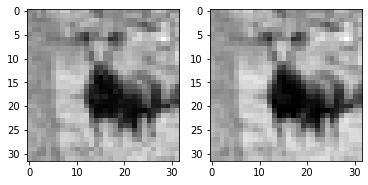

True label: 4
predicted label: 7
Time:  461.82251501083374  seconds
Initial fitness: 
 [-0.5527315750159331, -0.48096445408736543, -0.5119679212837223, -0.5148989481016959, -0.5326186787334795, -0.4258690940642642, -0.5440493669564636, -0.543263456653622, -0.5103752760519741, -0.4342038305320949, -0.5723843955226721, -0.5310117615830612, -0.5470743206761106, -0.4454144592513649, -0.4476234019468113, -0.49628344220879206, -0.5130403915439019, -0.480142693608974, -0.5455535230443129, -0.5527994406345407, -0.5335330633274464, -0.5934979112732222, -0.42707688448560527, -0.5330226963180873, -0.5034862353869474, -0.5774787000756492, -0.1555035684486395, -0.5571807424348436, -0.563194411673515, -0.535119072065783, -0.5207381791216815, -0.38098808878213375, -0.5504551395789211, -0.5543342378360727, -0.46730068141524583, -0.49726296650737756, -0.5200657827691756, -0.4452615686328507, -0.5297140229616644, -0.48454605473753304, -0.5318400381244979, -0.5356065708075495, -0.37735622721351614, -0.40

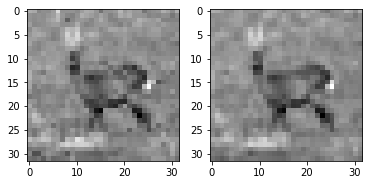

True label: 4
predicted label: 2
Time:  214.48333311080933  seconds
Initial fitness: 
 [-0.5973372660399501, -0.5941335630729319, -0.5962559888293307, -0.5951056633090166, -0.596118218871024, -0.5955522577307508, -0.5971195660559072, -0.5963233888445195, -0.5927033154957366, -0.5918357825110514, -0.5962032045634835, -0.5913187214680012, -0.591764743052735, -0.5952142347178931, -0.5966318533484168, -0.5860032306009066, -0.5965792216456169, -0.5936722072365928, -0.5914131985124358, -0.5920373725200964, -0.587941055670735, -0.5881639284700798, -0.5960842459154627, -0.5961646640189284, -0.5950329281182077, -0.5955140344962427, -0.591883031927924, -0.5942340795340331, -0.5885125548373239, -0.5947462632656986, -0.5943566378875962, -0.5909212701653357, -0.5963763441646696, -0.5969960665248953, -0.5951044148095044, -0.5975214643746196, -0.5923319095633264, -0.589584584368527, -0.5943815691841559, -0.5935268284445365, -0.59166659038042, -0.595814453994187, -0.5929490738730966, -0.58996326400777

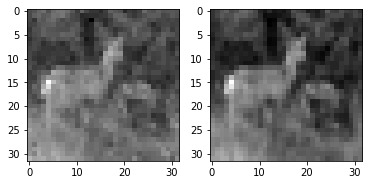

True label: 4
predicted label: 2
Time:  326.70887207984924  seconds
Initial fitness: 
 [0.2713474223280033, 0.12432352240818867, 0.49921696362700413, 0.26167830634185263, 0.3412137724420813, 0.2925372286959963, 0.10504377994730726, 0.49267462620441305, 0.25537291294386094, 0.16999734104586894, 0.4307829614864228, 0.1929679771441904, 0.4100537847338843, 0.5273138194686253, -0.1664334018615119, 0.23229585391730664, 0.23456048832068702, 0.4891824507693755, 0.27636619418111324, 0.5454187363575995, -0.06299239932911829, 0.13314215913170221, 0.17550945003959206, 0.30887066297773863, 0.21122825787462404, 0.2855383864221649, 0.5844510032867047, 0.43671577605720485, 0.4123886313320294, 0.3835861747672063, 0.26210725526961104, 0.3058820790157888, 0.379201263175727, 0.35388591090590193, 0.3220817608696919, 0.4722689147390092, 0.29028509798511787, 0.34691207191960605, 0.27405076040792037, 0.2354956839772951, 0.31007079037741003, 0.23936589678101228, 0.410169870914609, 0.5419139719810895, 0.5122705

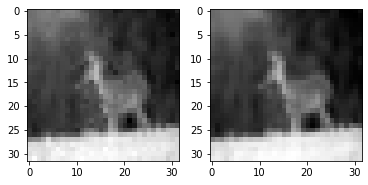

True label: 4
predicted label: 6
Time:  267.17681550979614  seconds
Initial fitness: 
 [0.9949669112771181, 0.9950923261061559, 0.9948868292327013, 0.995676306177389, 0.9970161727927693, 0.993390362912846, 0.9965952044763473, 0.9950308494823162, 0.9938801085780867, 0.973291335710378, 0.9963189641616943, 0.9949208562763948, 0.9960535212899231, 0.9958305437628289, 0.9958706968633888, 0.9966698687952443, 0.9941009255620418, 0.9934087882752802, 0.9958640458729653, 0.9956463445018529, 0.997556283262525, 0.995006460734292, 0.9974424017343708, 0.994663232577591, 0.9969479443042483, 0.9957548999550874, 0.9926813711543776, 0.9918192818955472, 0.9970096839149751, 0.9957511196598652, 0.9943319247255019, 0.9952030686300746, 0.9964992848326045, 0.9942386114653158, 0.9878338397665568, 0.9951576589486502, 0.9950019072696781, 0.9894146192742894, 0.9958936470822674, 0.9960576201247662, 0.9970310575105013, 0.9892115135671051, 0.9962526254791115, 0.9950409182136299, 0.9969091564071788, 0.9932206827532384

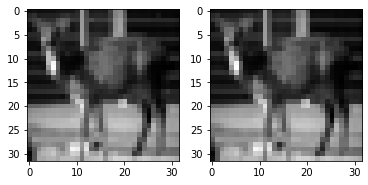

True label: 4
predicted label: 7
Time:  4.608410120010376  seconds
Initial fitness: 
 [-0.5612572220127675, -0.5708419980913577, -0.5673516439123054, -0.5809531435527009, -0.5902840576501645, -0.559542321167745, -0.5781130050457501, -0.5543631872108195, -0.5664672097514895, -0.5632561445207339, -0.5703030301318722, -0.569117268861644, -0.5571852728253857, -0.5670000700850945, -0.5652688865313629, -0.5495613512591266, -0.5652520879120442, -0.5708035607691904, -0.5692367383802835, -0.5729755088808547, -0.5733460712752296, -0.5726129212431353, -0.5705356178050278, -0.5631147248730568, -0.5756273538280904, -0.5658681422079782, -0.5691257127444177, -0.5640641807767591, -0.560382129988708, -0.5394870531019123, -0.5624516915284336, -0.573523570205039, -0.5605279165138396, -0.5522458627450704, -0.5466102668090003, -0.5756236863411489, -0.5684440138019917, -0.5720374282422266, -0.5657843590308889, -0.559481105295384, -0.5575595717505808, -0.5630487782119274, -0.5685142165655654, -0.566950385231

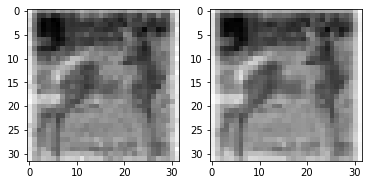

True label: 4
predicted label: 2
Time:  440.18209981918335  seconds
Initial fitness: 
 [-0.5931420329876255, -0.5935697941554858, -0.5920725342567773, -0.5939986961528998, -0.5922706771788416, -0.5943326071828168, -0.5943891383855392, -0.590604148975841, -0.5917840840061921, -0.5934069546599922, -0.5971990351882082, -0.5953182018740832, -0.5940113114685347, -0.5941691539025842, -0.5926686654623725, -0.593766351337727, -0.5923847640909897, -0.5934678216692932, -0.5943794250083088, -0.5926516539372166, -0.5930923795386491, -0.5876007971174437, -0.5911887033627827, -0.5826255139323788, -0.5952073981199721, -0.593836468951037, -0.5948857977329409, -0.5963074910403543, -0.5896531447789483, -0.5924837923092047, -0.592902116857421, -0.5919742958157098, -0.5945491621773602, -0.5938263113337154, -0.59641971909332, -0.5937222172965224, -0.5921953072039537, -0.5922082818129211, -0.5951009129745557, -0.591937424200985, -0.5921618319837298, -0.5930604786046163, -0.5971366084620573, -0.5934198647984

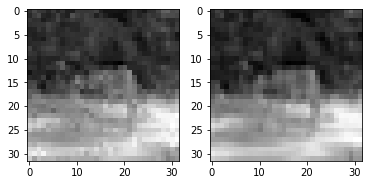

True label: 4
predicted label: 2
Time:  478.297212600708  seconds
Initial fitness: 
 [-0.077385433311765, -0.1562901050448847, 0.000782792970637658, 0.3568785027902526, -0.19230372463788103, 0.2274720868026102, -0.14013127606367834, -0.3552264097843024, 0.0038692630157819985, -0.005632671101017062, -0.04706757117549901, 0.004442944174055913, -0.09113072441877343, -0.053751316014097744, -0.09112066144643624, -0.08008757879513151, -0.20885641326781135, -0.014462944401516825, -0.1075535218372834, -0.053100004208305324, -0.17683689863344162, -0.2811516671161232, -0.19531817678857746, -0.2110918378266346, -0.05176494044976093, -0.05411856090725636, -0.054542562746894674, 0.043761147309270054, -0.15910130772864572, -0.19030032096924002, -0.3947090417213005, -0.023187882971455825, 0.00803167429934204, -0.330756733667807, -0.10001698863877484, -0.06434211359056552, -0.06526232359830086, -0.13208286369831274, -0.15764151756165046, -0.0630322024283684, -0.07304171041897373, 0.14168760788289803, 

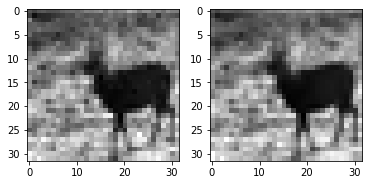

True label: 4
predicted label: 2
Time:  611.7482237815857  seconds
Initial fitness: 
 [-0.5960942815480075, -0.5917503331404576, -0.5944616868306544, -0.594597418088074, -0.5970301929992934, -0.595581980024519, -0.5984846158679311, -0.5929614654606559, -0.5960693944412518, -0.5958116008293942, -0.5950228160994184, -0.5948788648814674, -0.5975668053063599, -0.5961131517450491, -0.5945393929726476, -0.5938780995640537, -0.5931417842734124, -0.5963681425370528, -0.5965389425191807, -0.5935711971571944, -0.5970328000620859, -0.5919957606395829, -0.5953611785991488, -0.596612675630335, -0.5911374759269798, -0.5970384242599097, -0.5968380818704708, -0.593206296425471, -0.5932559221356672, -0.5969157011780123, -0.5971456012509052, -0.5935136629463502, -0.5963345744100461, -0.5976060076965424, -0.5976167199378437, -0.595609387803633, -0.5967129537272177, -0.5912461165902886, -0.5948170986814971, -0.5960087988166282, -0.5955975010626525, -0.5918414528149136, -0.596748848219995, -0.5950409305931

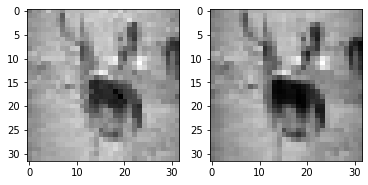

True label: 4
predicted label: 2
Time:  589.5271422863007  seconds
Initial fitness: 
 [0.4085444083232803, 0.20751242237800174, 0.48018811421265445, 0.45842093649056725, 0.42450400731390253, 0.3878407643227435, 0.4820691021158948, 0.3702531702929258, 0.39727230570150235, 0.38307994770194603, 0.49435494687231724, 0.3826415901120775, 0.4217834186188697, 0.4379381039493778, 0.36751125154777675, 0.5411985986488053, 0.41963368150620567, 0.4725797721132155, 0.37264348851240203, 0.36602014960630624, 0.38077336075267043, 0.4070584733876643, 0.44557620777773543, 0.3536156678235898, 0.3879410625597586, 0.35637553734623284, 0.426621707917042, 0.3401585288296659, 0.3904399944581488, 0.3075482076174167, 0.3505963786360928, 0.25204648964553455, 0.3612321262305176, 0.37558416137556505, 0.39114863232712904, 0.47939383766179317, 0.22640429355484412, 0.4594664080323436, 0.3823687482982654, 0.6125695545407446, 0.3566372221839189, 0.42083489128383844, 0.41511935719914095, 0.31011172213578875, 0.3873342346

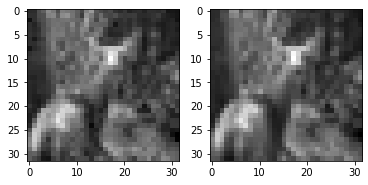

True label: 4
predicted label: 3
Time:  640.2363908290863  seconds
Initial fitness: 
 [-0.1374789038862954, -0.08785885789543146, -0.49012792153610396, -0.26105225976216107, -0.12241621822803808, -0.12017692930340032, -0.22054536982953565, -0.4153689714789571, -0.32791465470790365, -0.4370074168193462, -0.14985513741639292, -0.14453505032214853, -0.10851520796065522, -0.3052534168383605, -0.43709125969655643, -0.22669924124174037, -0.25060816871107283, 0.3575148327715182, -0.3197432332085387, -0.22641079057166724, -0.14458852194512692, -0.4355666190088699, -0.11084021445968678, -0.2985750435797506, -0.21390604174127614, 0.1114665238824133, -0.1664872950780703, 0.12902041336629028, -0.2389278121802424, 0.09940014141190036, -0.3800737646622304, -0.10931229172206186, -0.2944853763354731, -0.23750078774161532, -0.2348873572013025, -0.11415314205295835, -0.2230975933933566, -0.33498990079001734, -0.2928033718880393, -0.2801085848941758, -0.14070236230436997, -0.11679652644464567, -0.2773083

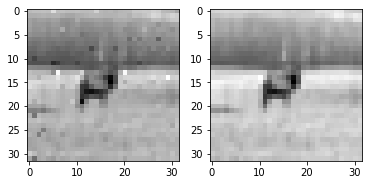

True label: 4
predicted label: 0
Time:  277.01844120025635  seconds
Initial fitness: 
 [-0.305571892715099, -0.15668855402879975, -0.2869811511465293, 0.05881923311974138, 0.12509194049768113, -0.05353811643687567, -0.0976468020083644, -0.17611976135831842, 0.3918437324640692, -0.031998104803981464, -0.26305199881233565, -0.2664880722686511, -0.12894030099271134, -0.196797220836523, 0.26350072968360483, 0.09853952317080461, -0.21097077543606158, -0.07309502756041697, -0.19477884138277923, -0.3223008637464492, -0.11443986473205292, 0.04964459392331447, -0.07090054908113222, -0.06185720886289964, -0.12585390797631543, -0.18878174161453976, -0.16153751052050294, -0.08632131341184335, -0.1498026172069783, -0.07189982606717221, -0.14875163972110245, -0.08911912730600377, -0.05672085438191132, -0.10907820102724197, -0.18417317662085247, -0.0016737027361201917, -0.3940899166939823, -0.14895028861225287, -0.16742571532384137, -0.19409539887596433, -0.02279660123925495, -0.10390805613146217, -0

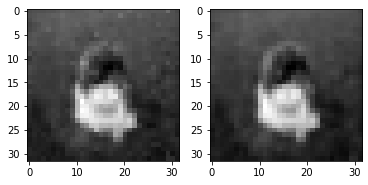

True label: 5
predicted label: 3
Time:  332.8576521873474  seconds
Initial fitness: 
 [-0.5819070697911208, -0.5843272823433089, -0.5886681868085413, -0.5833536479587472, -0.5852327685209376, -0.5841948469923733, -0.5855509189135725, -0.5885140350133409, -0.5823597567353458, -0.5780054035028376, -0.5887833211219883, -0.5831013692989624, -0.5883255101027062, -0.5899136652846731, -0.586456982280295, -0.5859449344176753, -0.5838372313057172, -0.5865602949992716, -0.58768962325926, -0.5846862248121293, -0.5774508287849679, -0.5868040549534528, -0.5852810581785152, -0.5792222073772342, -0.585234144528517, -0.5815843360062205, -0.5919875067577838, -0.5920076457968777, -0.5897556371390013, -0.5472980644763612, -0.5850057727251189, -0.5817713339999664, -0.5844999203894476, -0.5808733085626706, -0.5851713769567732, -0.5850079823091531, -0.5841221508165705, -0.5915249088489128, -0.5841266819953949, -0.5858859777552303, -0.5863287368994818, -0.5858881874520098, -0.5764089407359215, -0.58508660365

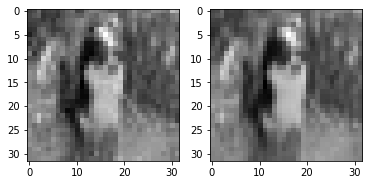

True label: 5
predicted label: 2
Time:  929.7245757579803  seconds
Initial fitness: 
 [-0.4128985344184719, -0.45345579217160525, -0.48897047938171806, -0.42335155903177524, -0.24064129487717728, -0.45917352235844067, -0.38703697093380274, -0.4712516946706801, -0.41440373069902603, -0.43641120591130944, -0.4429698283499992, -0.47688780798877733, -0.4525352481251581, -0.4248639479201459, -0.24512768952846783, -0.3560565672955607, -0.39936864368169556, -0.4740745351615526, -0.41915236274500023, -0.47796771960623674, -0.4856120377087837, -0.5110618627270237, -0.4455597717802997, -0.4585929762121177, -0.3576232734901158, -0.26047559176600915, -0.28110555154700567, -0.4730900306034401, -0.46468703848843884, -0.4815559963042907, -0.21711004306238213, -0.4453035909363138, -0.42397735968110983, -0.3583106616786116, -0.3114045849512541, -0.4289116664293277, -0.38989389642042754, -0.4152160887308307, -0.35851575001662817, -0.4305974967414492, -0.44812627343516964, -0.47446706571545283, -0.429767

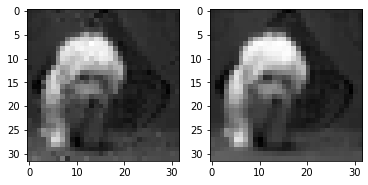

True label: 5
predicted label: 2
Time:  369.32949662208557  seconds
Initial fitness: 
 [-0.5505973205272362, -0.5803181157324743, -0.5833171982613009, -0.5706719588992244, -0.5820862123456744, -0.5808299360127522, -0.5848914391268298, -0.5843282052620826, -0.5780508741686973, -0.5828701641669946, -0.5845323026095568, -0.5837511797692985, -0.5836877716039719, -0.5766662319788477, -0.5820492806391819, -0.5787378728550755, -0.5860227867713343, -0.5864069338099381, -0.5843086696276996, -0.5793179765867585, -0.5917981762567508, -0.5846509682984894, -0.58092408349924, -0.5890292610159735, -0.5704725507461985, -0.594805720697799, -0.5830759170252012, -0.5788521777292784, -0.5764524690060325, -0.5861447680660309, -0.5801763326922397, -0.5822040299678288, -0.5837130627530869, -0.5765924074354154, -0.5818632768765494, -0.5837114745772697, -0.5838094930251156, -0.5862594195081443, -0.5850635745847331, -0.5897106492489785, -0.5748088205359372, -0.5817144305041463, -0.5835261526989766, -0.568049194

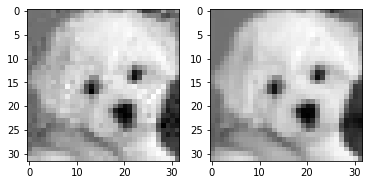

True label: 5
predicted label: 3
Time:  870.9477231502533  seconds
Initial fitness: 
 [0.17726553930815048, 0.13929380732951713, -0.1515928833988539, 0.14111492327786937, 0.1942896291523512, 0.5960931353465067, 0.13613800090843461, -0.03868203442626797, 0.31629414326985694, 0.4964933890693731, 0.1696340752833308, 0.032686641903466596, 0.01676475171437672, 0.12084227465593718, -0.12075231897025837, 0.2780076255336273, 0.10240488987016301, -0.07765762204209192, 0.0621913257887029, 0.21503245824294842, -0.048057761970207086, 0.09269547040993094, 0.10291487525485071, 0.013772354043207619, 0.2270007723111634, 0.23817600976043185, -0.01806287460515002, 0.08313608797016576, 0.10795968029276692, 0.10734039533293419, 0.03399018960535369, 0.32643447284279814, -0.030123609243153632, 0.12025454495999535, -0.07892690247140041, 0.030963461833700606, 0.05072298287888652, 0.0870126374091288, 0.09361159044058626, 0.1399346959745723, 0.116171235720123, -0.0522322895016645, 0.11676041827617935, 0.1208532

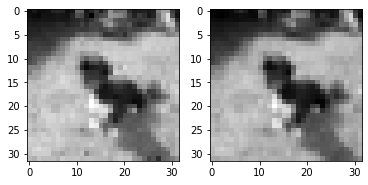

True label: 5
predicted label: 2
Time:  299.48096466064453  seconds
Initial fitness: 
 [0.30336980876032626, -0.16685885940524575, -0.16467907605339188, 0.0055346528162324715, -0.1349196177626666, -0.11969085304264418, -0.12090233268453898, -0.12849828212380995, -0.02215251891006173, -0.0600403356871817, -0.0027430606018592207, -0.16335216724808552, 0.184778786365854, -0.11205875048997158, -0.13857802926265908, -0.1887537865442091, -0.15032051014750386, 0.12705229994481837, -0.23085380546541043, -0.013451978343808985, -0.09759509347451562, 0.11762606832022776, -0.12369864593158067, -0.192731657646172, -0.17166131785932887, -0.15562833610990334, -0.07007720961476172, -0.2238567342335519, -0.14910508194292654, -0.06823308240614745, 0.13579586523541565, -0.11527195298413576, -0.09092720836373913, -0.049369381787116556, 0.12143956332215122, -0.05754123345274109, 0.02204064959750418, 0.0450570602222809, -0.15566412870663, -0.13951308526147635, 0.019328417171807083, -0.07834896914492487, -0.

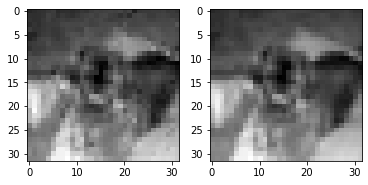

True label: 5
predicted label: 6
Time:  307.2243673801422  seconds
Initial fitness: 
 [-0.598379790151072, -0.5983368367855554, -0.5985432286138385, -0.6004711343284536, -0.5989183980907645, -0.6031020036119585, -0.6022264191503794, -0.5994720052068739, -0.5981880785616388, -0.5983026488977908, -0.598867237423375, -0.5980940965252042, -0.5984949247420354, -0.5995207839031815, -0.5997752389268722, -0.6015545675255825, -0.5993160742625203, -0.5984794872206862, -0.598573440487704, -0.599132910292903, -0.5987736967683098, -0.5997339616586076, -0.5985840023511427, -0.6002514458806874, -0.601555501554757, -0.598780023747511, -0.5995048102235631, -0.598686850206193, -0.5988040267058539, -0.5991347926318624, -0.5997211715031867, -0.5989832278692502, -0.6005917494837967, -0.5985141231579623, -0.5981453506262756, -0.5993809388867205, -0.5975805733333858, -0.5986571109829285, -0.5994139992602505, -0.5995612237289681, -0.5985337730693479, -0.598218891375739, -0.5987361523838514, -0.601236674149378

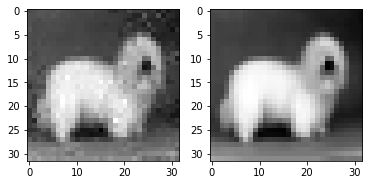

True label: 5
predicted label: 3
Time:  669.112847328186  seconds
Initial fitness: 
 [0.7054271560609248, 0.699876033902531, 0.7092324005582252, 0.8071835460913424, 0.725659739419608, 0.6839110756167963, 0.7244159724291628, 0.6622285642130625, 0.726449651710493, 0.732721213828752, 0.692902621311102, 0.7267051027648297, 0.7501698065477481, 0.7426023714133808, 0.7173956612050789, 0.7446735637917743, 0.7149974262995211, 0.7248992178608855, 0.8036259128931095, 0.706365318282086, 0.7101132612075908, 0.7252625113970456, 0.6974761051581156, 0.7256306772686195, 0.7010397343622443, 0.719493522807672, 0.7708263300142754, 0.713980954009458, 0.7445959206935535, 0.6605640470000161, 0.7482420274342992, 0.7616757536867667, 0.7283648795500559, 0.7701151710258778, 0.7012814895170314, 0.6829668589985465, 0.7112172680503521, 0.7860570422057543, 0.7250963038225601, 0.6664881752317009, 0.7526281168393822, 0.7829991870003983, 0.6952169688558825, 0.6307725808607422, 0.6951957245394309, 0.7205312533795388, 0.

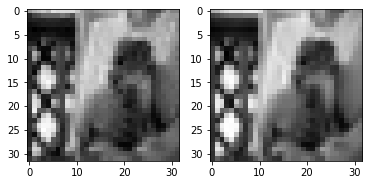

True label: 5
predicted label: 3
Time:  710.5100722312927  seconds
Initial fitness: 
 [-0.35137145450921936, -0.4069363695277346, -0.38797129759059734, -0.3475253862638149, -0.3786545011689713, -0.31135787111082336, -0.3681355300704806, -0.29978772115664526, -0.3672967227362539, -0.3941410151878963, -0.3169371048196858, -0.32809778308386844, -0.39170678983985674, -0.41809460536015985, -0.33544211204941476, -0.4875856099284832, -0.3875217289399929, -0.4227401064643417, -0.37609353741280427, -0.3381590149068655, -0.332392067693871, -0.26461629141780646, -0.3359060268904689, -0.37833631832313797, -0.3118499778670961, -0.3469045686546105, -0.35171796201346267, -0.33788777282892984, -0.3606722379103459, -0.36172187555798996, -0.29994804112626994, -0.3204081538689937, -0.40111467010888757, -0.2837839356692243, -0.35430703761899995, -0.3009090246933229, -0.3459316110760595, -0.3966708192347609, -0.3457176699579161, -0.31891933898167, -0.33585515426696755, -0.3341065596451286, -0.3197409738734

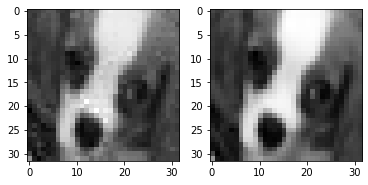

True label: 5
predicted label: 3
Time:  598.722377538681  seconds
Initial fitness: 
 [0.23026437811160225, 0.11360998308235444, 0.16680674957127148, 0.06868292758167119, 0.19009134649949053, 0.13716780961976166, 0.24744508585121133, 0.14617090356822066, 0.1663126717508287, 0.22133753378730853, 0.1015994440596985, 0.20298692814166933, 0.15097538731922966, 0.26364760281943045, 0.21428899971228008, 0.29425298151029444, 0.22448344694530986, 0.17524264696648592, 0.14200476385220592, 0.23041096826761057, 0.20313131980777863, 0.28861015870009954, 0.3121963070068268, 0.3106707228193192, 0.13836764494839537, 0.2574880937941789, 0.26953284136950123, 0.13220688501939096, 0.08590416084221841, 0.0849260232090873, 0.1978627389787554, 0.19354146202869185, 0.1736296004700235, 0.1439174844733545, 0.12482080485292854, 0.1891005517288635, 0.16057670050090075, 0.37693962582151125, 0.22521714338353224, 0.12838031168953778, 0.04216489178394392, 0.2306836786635033, 0.21208586415263758, 0.2453301818636149, 0.

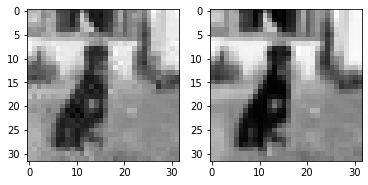

True label: 5
predicted label: 3
Time:  463.69195008277893  seconds
Initial fitness: 
 [0.5702909580337681, 0.5629810324682021, 0.6369911203064258, 0.6375134273574821, 0.6038261284690005, 0.4571566571862338, 0.5454847416209692, 0.6332211270550921, 0.5068708597507401, 0.5274945501038443, 0.6007616734255236, 0.6048073943769053, 0.554657411821113, 0.621126987794292, 0.6086616046566578, 0.5557431827365867, 0.5690201843847924, 0.6428205690954605, 0.5068737856493417, 0.5836960231850059, 0.47839433569535267, 0.4827766750532342, 0.5734990675743049, 0.5326200130508019, 0.5401250974189815, 0.5617477877541586, 0.5991891575322028, 0.5701662291648124, 0.7277383983473145, 0.5628602392352218, 0.48858681537580234, 0.45005279649423463, 0.5528468482380441, 0.5539112360035352, 0.6182899135371069, 0.6070771308095403, 0.6061720888386153, 0.5322214239035397, 0.557806816397082, 0.5213702901021532, 0.7395798541866404, 0.6108844617878348, 0.5631231641408829, 0.5075599985219416, 0.3807624727618519, 0.4812841362

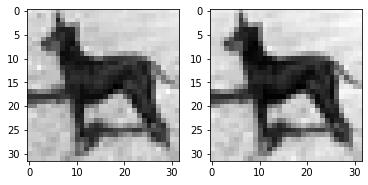

True label: 5
predicted label: 7
Time:  359.94940876960754  seconds
Initial fitness: 
 [-0.6000697865374786, -0.6000077775690081, -0.6002404500714736, -0.6005275249697635, -0.6000957574080854, -0.6000152356209358, -0.6000945132393032, -0.6000312875425344, -0.6003948616554863, -0.6003911572239019, -0.600271025103626, -0.6003828890340228, -0.6001699135580758, -0.600241477287442, -0.6003821143454703, -0.6001915556619735, -0.6001495093899947, -0.6001778612594144, -0.600102048936891, -0.6002106042784155, -0.6001378416605514, -0.6004239214796023, -0.6007628455888409, -0.6007510228935361, -0.6000501825109014, -0.6000057767136016, -0.6000915230616348, -0.600169735126691, -0.6005806396149694, -0.6001430514905459, -0.6000625867325927, -0.6002151594895789, -0.6002991603998901, -0.6006169034742405, -0.6001042159536383, -0.6000474541270401, -0.6001307333689274, -0.6001967485367391, -0.6000614923999357, -0.6003405266962861, -0.6001689956899213, -0.6002276304364711, -0.600075830013333, -0.60017159116

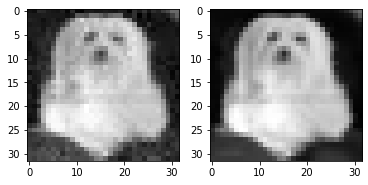

True label: 5
predicted label: 3
Time:  649.0035693645477  seconds
Initial fitness: 
 [0.3188901234763504, 0.2525651760685561, 0.3309570707992262, 0.3242442881655287, 0.31997196703732617, 0.1434228946212282, 0.3855955891838827, 0.2509865092704683, 0.49984943398378945, 0.2881405689705909, 0.34342188780568583, 0.39558155927151595, 0.3060853479407615, 0.2944765263297987, 0.3165000730268114, 0.3659522129972842, 0.3105200699022942, 0.2970035667331424, 0.3004933339721235, 0.27588831288004473, 0.15442875480674273, 0.32177436462680675, 0.4173606157396995, 0.2732529244200105, 0.2999184219866812, 0.3626821677565548, 0.26694478319348464, 0.41676265928822176, 0.3079791707224687, 0.20147786578347204, 0.28160274695735993, 0.33745663541810267, 0.34877001756258996, 0.3510498486170478, 0.23167316462846926, 0.18970617029378894, 0.26032236160233524, 0.29146495838297365, 0.16769318603562972, 0.5110202553580189, 0.2250734393168653, 0.424452550890152, 0.12161600925205866, 0.29546551304266044, 0.292986981491

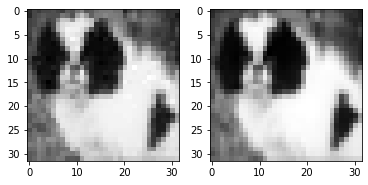

True label: 5
predicted label: 3
Time:  472.95675110816956  seconds
Initial fitness: 
 [0.4209519764704884, 0.623837071766149, 0.4448950204241634, 0.5823115005441011, 0.3887498820568108, 0.3983431645023131, 0.4931885325047065, 0.49615398428016866, 0.33624265095169903, 0.28758143304063644, 0.369530357746519, 0.5277973182110252, 0.5512524853163678, 0.5084542040772984, 0.38416704961473996, 0.4627223206106964, 0.4241075994163864, 0.5275880630368195, 0.32516875477232954, 0.4668148950639564, 0.5102524952039624, 0.27367620980259144, 0.48386834894033437, 0.22730694010170138, 0.3919071761897476, 0.11603992177657975, 0.8198374947782113, 0.4506974533572321, 0.7515239527041835, 0.3219767588273212, 0.28891594521443364, 0.5506123750528493, 0.3810931599990669, 0.3666482816120282, 0.2706413852140957, 0.5962917111260562, 0.4707153928224097, 0.5541109302872437, 0.3887863728520458, 0.42876329571119987, 0.37871058498569465, 0.36524085127984274, 0.35513641980115085, 0.5664063383257201, 0.44996281623165135,

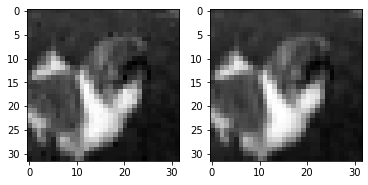

True label: 5
predicted label: 3
Time:  222.24124002456665  seconds
Initial fitness: 
 [-0.6003342345345442, -0.600033251108669, -0.6008987921536436, -0.6008463322862414, -0.6001835093677327, -0.6001546797585213, -0.6001318241829522, -0.6001384790753417, -0.6002125549466086, -0.6001879468694605, -0.601173744753644, -0.6003108416644886, -0.6000564990041214, -0.6002230978716026, -0.6002627282216406, -0.6000531519579929, -0.600404588679496, -0.6002059978417542, -0.6000853284737452, -0.6002069468356872, -0.6003292407400224, -0.6000842263140801, -0.6006419732884809, -0.6001654031031864, -0.6006734963978463, -0.6003509319440523, -0.600508264310881, -0.6003985274518612, -0.6003346368548462, -0.6001336313793031, -0.600133261666798, -0.6001464938222869, -0.6001761754678336, -0.6001413418148471, -0.6003986454127448, -0.6000051086725734, -0.6004545739974746, -0.6000805748614187, -0.6001464272034868, -0.6004689560775358, -0.6001074801734121, -0.6001281406712163, -0.6003075666928184, -0.60047957673

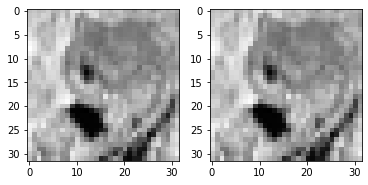

True label: 6
predicted label: 6
Time:  120.99843907356262  seconds
Initial fitness: 
 [-0.5531501355093063, -0.5321609091139062, -0.5388564764929527, -0.5330536864379857, -0.5689074156879651, -0.5536432431427453, -0.5505113979089058, -0.548451346760242, -0.5412483611368293, -0.5370612011369051, -0.5297190589894474, -0.5445353104569828, -0.552015802057046, -0.5609558688010132, -0.5443920013756522, -0.5404099306461813, -0.5614170750096413, -0.541586196037069, -0.5524650843077727, -0.5493242285835345, -0.5775658585063151, -0.5555384188095651, -0.5582652527818743, -0.5347159860906417, -0.5661085208743358, -0.5603535963819685, -0.5486978974747294, -0.5487977147888581, -0.5459153319491901, -0.5584760502127062, -0.5488031876835624, -0.5219343698010652, -0.5618180921440603, -0.53566320949876, -0.5502563735546604, -0.5504259528266103, -0.5449102234087885, -0.5582875549250071, -0.5586770970987932, -0.533984166785741, -0.5547805122463327, -0.5507679117049255, -0.5341826091913671, -0.576003715869

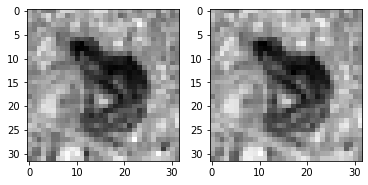

True label: 6
predicted label: 2
Time:  458.473201751709  seconds
Initial fitness: 
 [0.5733756251547657, 0.5742264353305827, 0.498431230313758, 0.3784909229648573, 0.50237743440292, 0.42854416469898426, 0.5951899994586033, 0.5979058134080042, 0.6901528346248159, 0.5355041899496289, 0.6036096245319499, 0.792943868434411, 0.5746798578168568, 0.5624819689096695, 0.5239034307848813, 0.5833815115552088, 0.4689438647917794, 0.6300880532027875, 0.5621528837888645, 0.5869820328163297, 0.5459922675977463, 0.5005346270220521, 0.5302499895037134, 0.514801350299251, 0.5075795355393381, 0.5112299868335703, 0.5521186141041766, 0.49475333578366687, 0.536394398447815, 0.5566820351466678, 0.5110743450220425, 0.526348681630103, 0.5702569418057779, 0.5813507368921145, 0.581980523406407, 0.5317464751996962, 0.5302067849314095, 0.5288877590759321, 0.5812942461144506, 0.5968217337119589, 0.5274103431794718, 0.5268423496688726, 0.5482754591364158, 0.5762894178700155, 0.4446738535541513, 0.5104163883154383, 

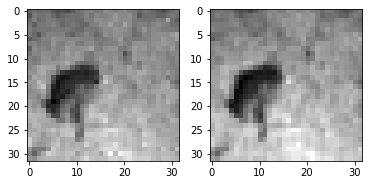

True label: 6
predicted label: 2
Time:  208.70101189613342  seconds
Initial fitness: 
 [-0.5995154673883869, -0.5994950078630938, -0.5997355734734869, -0.5995257627060878, -0.5995114552136741, -0.5993994504232398, -0.5999634482851275, -0.5994039382999978, -0.5995558989362292, -0.5996024771009032, -0.5995970970618655, -0.5994120679594837, -0.5997950486737144, -0.5996472023067475, -0.5997042796820344, -0.5997365904543384, -0.5999281683820286, -0.5992281257287397, -0.599454371016092, -0.5992727725814349, -0.5996446357040388, -0.5995426474093584, -0.599498074866012, -0.5997200462052772, -0.5993459771993574, -0.5995479567607088, -0.5998654275082653, -0.5998131832108909, -0.5995132860957213, -0.5996631093742534, -0.5995562200571946, -0.5996146838643857, -0.5995635659173941, -0.599625609290048, -0.5993746823914945, -0.5993566583931763, -0.5994427145773347, -0.5996793895260752, -0.5997749512201467, -0.5995267283512182, -0.6000043173174409, -0.5995705428575329, -0.5996577611363888, -0.599744128

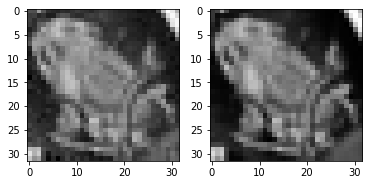

True label: 6
predicted label: 2
Time:  1105.718645811081  seconds
Initial fitness: 
 [-0.6003130233813241, -0.6045626419182962, -0.6032503294008598, -0.6029270021789469, -0.6008104348606276, -0.601349870438136, -0.604447634331122, -0.6035853744071393, -0.6055346711475863, -0.6043933308537104, -0.6040492230097434, -0.6094418577584121, -0.6005002657238332, -0.6026490907004877, -0.6038931473488296, -0.5992796056880094, -0.6034187719183992, -0.6077640915940743, -0.6012365644494544, -0.6048549349639334, -0.6044247017524613, -0.5963069170483078, -0.6019374519460532, -0.6022284572338092, -0.6018137230391333, -0.5969874134496402, -0.606549180682648, -0.6036613393568104, -0.6019001002014297, -0.6004838500382035, -0.6075595817262474, -0.5984162119373448, -0.6047928986641414, -0.6063099384689303, -0.6023518724295336, -0.5966002145016583, -0.6059960590358063, -0.5963200973577774, -0.5982305321510083, -0.6103810455318275, -0.6076327589724715, -0.5969595185032007, -0.6037939158748019, -0.5982383756

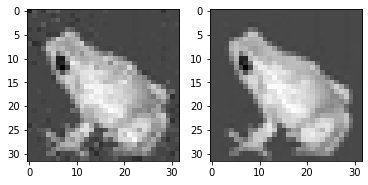

True label: 6
predicted label: 2
Time:  328.6760971546173  seconds
Initial fitness: 
 [-0.4587839574854975, -0.4738675661246081, -0.44760308952193617, -0.5048006123077075, -0.2821360208509317, -0.541588668734888, -0.5464502504699954, -0.45720367757406644, -0.5086679478727594, -0.49411416618219317, -0.516821530853296, -0.547573917047132, -0.4468920502903578, -0.503193458226542, -0.507548580992417, -0.5738517427876844, -0.485838758212246, -0.4219454509639037, -0.47638170960466, -0.4915060858453725, -0.48848508835804405, -0.47846310150810895, -0.4865784965651081, -0.5121029687306868, -0.4973930649238162, -0.44132855477968236, -0.5333672203295932, -0.5025043993099126, -0.49403331642376347, -0.5287408079615312, -0.4905746632637246, -0.45428243134578394, -0.49333083621311313, -0.4887492175843592, -0.535235991171747, -0.4853014704281027, -0.45722311674461613, -0.5012476987084628, -0.5000980070772367, -0.4830802466462467, -0.5424663630172086, -0.48130053513079996, -0.4749930787922464, -0.51642

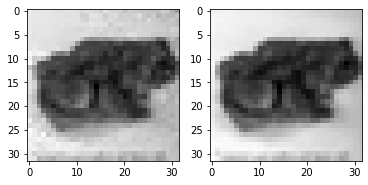

True label: 6
predicted label: 3
Time:  657.1872851848602  seconds
Initial fitness: 
 [-0.5991687264371869, -0.5987938735321631, -0.599435280578787, -0.599568159483731, -0.599502545928816, -0.5991820493934279, -0.5990255433078523, -0.5994383167918593, -0.5991669199310413, -0.5992031459195426, -0.5987623759751375, -0.5994387752819168, -0.5998750913386928, -0.5999916030411956, -0.599600109961951, -0.5990378463274234, -0.5989301721946121, -0.5986524718532813, -0.5988906931508431, -0.5996386185223017, -0.5990026883170105, -0.5993006304691564, -0.6003904899771823, -0.5998308703335284, -0.5996008578479037, -0.599559308259533, -0.5989810851049794, -0.5994854748667457, -0.5992018648906037, -0.5988106720137091, -0.5988932665295656, -0.5991296871478744, -0.6001543661578617, -0.599417982351411, -0.5984423102386404, -0.5997554404043639, -0.5994574374974762, -0.5989527215613286, -0.5993647828195275, -0.5986443199458646, -0.5989328428137348, -0.5990918869660428, -0.5990697130418262, -0.5994907354884

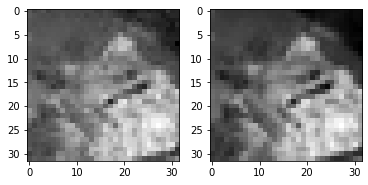

True label: 6
predicted label: 2
Time:  667.5848803520203  seconds
Initial fitness: 
 [-0.10621805563860778, -0.04476337237895647, -0.13301339347500157, -0.04978409261150238, 0.14203899529620134, -0.13171471810339783, -0.19318290569793728, -0.14622949433113064, -0.3056274158669042, -0.2594008165190265, -0.23784046845170426, -0.07600896269045665, -0.11816105900765433, -0.17617039045615762, -0.1758303106108554, -0.20757907908558798, -0.35614566317238966, -0.2238652351251676, -0.016302153335492925, -0.15951792863121184, -0.05575109417403207, -0.1266717273589959, -0.3415555585214939, -0.14582108134906735, -0.05148423805827107, 0.021938071360773886, -0.26589071733790626, -0.09111396623934603, -0.01687398095752335, -0.207601866004271, -0.09811971267405636, -0.040075332894239035, -0.31671060241605153, -0.15157338386093913, -0.18746087198985203, -0.21879736225489418, -0.14688447069670327, -0.03892394406151983, -0.20414731813964923, -0.12241466033153367, -0.06963733214842108, -0.202123615324803

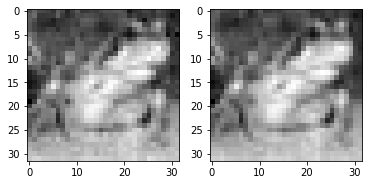

True label: 6
predicted label: 4
Time:  272.4406135082245  seconds
Initial fitness: 
 [-0.5997495269849553, -0.5996991076560598, -0.5998878859610537, -0.5998157484624995, -0.5998046785439478, -0.5997388971622115, -0.599871668943916, -0.5999323583016608, -0.5997665897379195, -0.5998578028104526, -0.599849525471897, -0.5997879328532469, -0.600183777007155, -0.5998903569108346, -0.6001379475920885, -0.6002963852841784, -0.5998996334853666, -0.5997670459929202, -0.6001885406312291, -0.5998131834429348, -0.5997347182462028, -0.599980196536458, -0.5999030109099003, -0.5999815903657333, -0.599759145921035, -0.5999240326980471, -0.6002865749180928, -0.6000065406877348, -0.5999873023217165, -0.5998848049118543, -0.5998998353694153, -0.5998583771681185, -0.5998538616947301, -0.5999115725066585, -0.6003385050122906, -0.5998255345701142, -0.5997151098601621, -0.5999796580563496, -0.5997683452865454, -0.5998286014203936, -0.5997240121926498, -0.5998674685870886, -0.5998391919321593, -0.599869670673

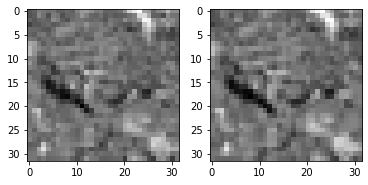

True label: 6
predicted label: 2
Time:  648.0129194259644  seconds
Initial fitness: 
 [-0.5912638349527334, -0.5880116190725022, -0.5968207786667183, -0.5862151527707609, -0.5886069986368074, -0.5931559926978568, -0.5939064815448847, -0.5889570363609079, -0.5811639901646486, -0.5883569591655583, -0.595872065708417, -0.585146248081426, -0.5928222897229747, -0.586381353696191, -0.591182231393325, -0.5887347981328196, -0.5811229389328437, -0.589979198884925, -0.5953206807622682, -0.5845235030952505, -0.5855634230300197, -0.5870786508267206, -0.5857415240283146, -0.5900138449285373, -0.5935102413005459, -0.5920677598786968, -0.5977542224290056, -0.5952639401321347, -0.5897195079030305, -0.5887947448842629, -0.5865034390753243, -0.5896299792016076, -0.5920832565471259, -0.5892057763801489, -0.588453000775843, -0.5906319996575347, -0.5798215444740692, -0.5874814987469867, -0.5941025017994169, -0.5896653115998138, -0.5940059366497372, -0.5812385774089709, -0.5867447473843852, -0.5922253779143

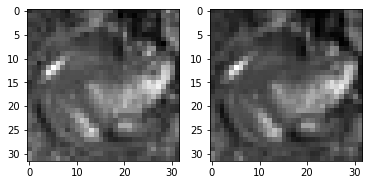

True label: 6
predicted label: 3
Time:  471.89686703681946  seconds
Initial fitness: 
 [-0.5983997734487433, -0.5985393180453732, -0.5986845091673298, -0.5970233261012805, -0.5980131385272056, -0.5980660084820978, -0.5976437754425439, -0.5988893875949006, -0.5974577335115355, -0.5978192155855927, -0.597928623072018, -0.5984564805390931, -0.5982546443412338, -0.5972863778136257, -0.5975213859362548, -0.5979576334320448, -0.5981564401638029, -0.5981528170960873, -0.5981947996258189, -0.59800234162614, -0.5974748227482006, -0.5980009972512342, -0.5989272542868997, -0.5978113617834714, -0.597786261635656, -0.5978072438255683, -0.5972955281743324, -0.598351440543907, -0.5975923116697535, -0.5975271108077197, -0.5977414011550581, -0.5981621517138018, -0.5970406135281252, -0.5980888262260455, -0.598732911387882, -0.5980650156463962, -0.5982470275937591, -0.5975983798741671, -0.5976513184256701, -0.5977564526200397, -0.5963250447353003, -0.5978071582714021, -0.5981745652447933, -0.597706251062

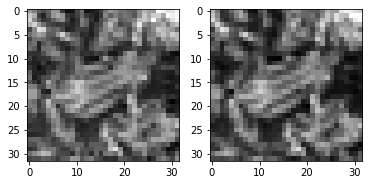

True label: 6
predicted label: 2
Time:  739.6039741039276  seconds
Initial fitness: 
 [-0.5936538853350691, -0.5945162216277435, -0.5953972406093804, -0.598682855726818, -0.5953572725335823, -0.5971241798808724, -0.5964659489039744, -0.5962000659054622, -0.5977059705520321, -0.594040524389114, -0.599529966084278, -0.5959851116062357, -0.5969728788003185, -0.5922031797290028, -0.5920879245150393, -0.5941181813598744, -0.5923559201508279, -0.5953958797804502, -0.5972413603963258, -0.5973594846597178, -0.5920215575916555, -0.5970489641095985, -0.5959766640586471, -0.5991914907920941, -0.5934480427249189, -0.5986662250342358, -0.59545353059443, -0.5969676699648292, -0.5989945392908728, -0.5942311168833929, -0.5969194394416744, -0.5971053463789321, -0.5978878073556266, -0.5924598704822395, -0.5978608571760261, -0.5941615954133828, -0.594781149559281, -0.5991222791582801, -0.5974394188985317, -0.5958331566555032, -0.5983279841000277, -0.5990856348168309, -0.5978897377886025, -0.5948027596165

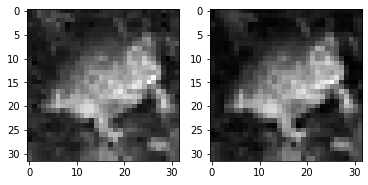

True label: 6
predicted label: 2
Time:  312.0255970954895  seconds
Initial fitness: 
 [-0.5990839945409289, -0.5980654530524052, -0.596596161438571, -0.5993662512840934, -0.5982406860827445, -0.5990035588452924, -0.5978266499076939, -0.5982969143509702, -0.5972418570889484, -0.598498118426124, -0.597815616800996, -0.5978362697436668, -0.5983949074846744, -0.5980719243647606, -0.5983202628240598, -0.597907385488265, -0.5993023744040915, -0.5975773967815482, -0.5976023955815414, -0.5970630514291402, -0.5980870622985441, -0.598769467560087, -0.5986890290054159, -0.5976059619332522, -0.5971333485425004, -0.5987164585730879, -0.5980638039521213, -0.5976856934729077, -0.5976507519029859, -0.5987687542952498, -0.5981077972425394, -0.5982445416442936, -0.5977316321356982, -0.5979620919492001, -0.5962454378216274, -0.5962233312254461, -0.598534371577646, -0.5987085981945222, -0.5981573491609876, -0.5990770422264686, -0.5981424511394069, -0.5989356365182176, -0.5989992448459844, -0.5984765389329

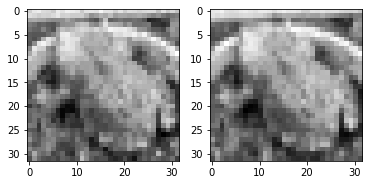

True label: 6
predicted label: 2
Time:  613.27774477005  seconds
Initial fitness: 
 [-0.6014577100375484, -0.5998089564782387, -0.6004390698164799, -0.6005285629695435, -0.6014670483668579, -0.5997883711975717, -0.5993376637472013, -0.6003364727122689, -0.6008133628269605, -0.6008088783445655, -0.6008860491832693, -0.6021424883104699, -0.6000971088878463, -0.6004170333005002, -0.6000738551570551, -0.6024255530170535, -0.5990108789627335, -0.5993391008164981, -0.5996322304941104, -0.6005695404776283, -0.5992082075936644, -0.6002546073108446, -0.6004222902202798, -0.6015913529220451, -0.6007420204055665, -0.599560598777994, -0.5998362770785136, -0.6005497155709075, -0.6017365742670722, -0.6001190795473852, -0.5994363365323592, -0.6006257917678206, -0.6022230295557693, -0.6013008667606354, -0.5988452971663851, -0.5997816426193591, -0.5990667415183841, -0.600954597075791, -0.6003873618064283, -0.6025676745933575, -0.5992988288279751, -0.6019083168866031, -0.601056580400616, -0.601194434881

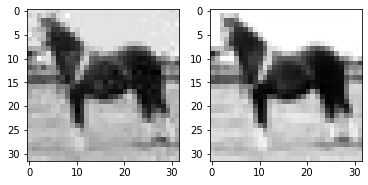

True label: 7
predicted label: 5
Time:  567.7568175792694  seconds
Initial fitness: 
 [-0.6074349558460626, -0.6007892001014963, -0.601087517571688, -0.5990760524362322, -0.6093311607266054, -0.5999527629484397, -0.6022223856267817, -0.6000828178612879, -0.602605835677485, -0.6014966526217795, -0.6042039383345346, -0.5988910867104936, -0.599359467340946, -0.6014482549274207, -0.6030738485128557, -0.6034402132853349, -0.5986963359382779, -0.6043293901417504, -0.6073263188797315, -0.6017770010036199, -0.6034169863900273, -0.5998097947418801, -0.604837920658222, -0.6025183526842552, -0.6095870170216059, -0.5988901113589349, -0.6010970557714795, -0.6050176195318382, -0.5996000064159337, -0.6001530085323821, -0.6004346258337057, -0.5991923675473683, -0.6017158155934585, -0.599380761098586, -0.5994267529692894, -0.5994322065953721, -0.5990839197429153, -0.6028270791783042, -0.6029626479424425, -0.599111647384273, -0.5992304445663906, -0.5990290785510624, -0.6001791645549972, -0.6057460656348

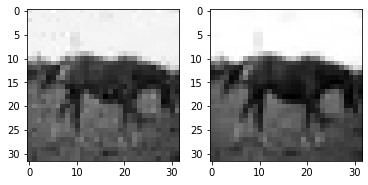

True label: 7
predicted label: 4
Time:  291.12758231163025  seconds
Initial fitness: 
 [-0.6003680946715548, -0.6009442060569761, -0.600361615656876, -0.600358048049235, -0.5999020851270707, -0.599635713027628, -0.5995561279553373, -0.6000282788971709, -0.599728660447625, -0.5998430725574022, -0.5997945830600787, -0.5995123334519561, -0.5997087283215988, -0.6002660386296659, -0.5996473840230963, -0.6002338546683227, -0.6008072895285232, -0.5998279344782058, -0.5997721235816644, -0.5998875345327037, -0.5995760855937562, -0.5997032497726519, -0.5997333505423237, -0.5998317842250777, -0.6000530698959932, -0.5997694911613124, -0.6005519102986305, -0.5999433717938099, -0.5997910788027435, -0.6001166419081572, -0.5997372497015843, -0.5999658119943798, -0.6003238243953376, -0.600103014623275, -0.6000306449780626, -0.5996839310331809, -0.600348207701993, -0.5999597808137241, -0.6000040113819913, -0.5994775587541478, -0.5998306599863759, -0.6010860830102945, -0.5998575322339548, -0.600964877842

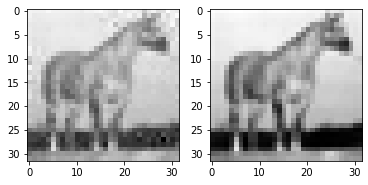

True label: 7
predicted label: 3
Time:  1122.9550321102142  seconds
Initial fitness: 
 [-0.5144880488004389, -0.4960726651538341, -0.542832515096537, -0.5320601827069303, -0.5755458649520464, -0.5280128044435057, -0.47835262072928453, -0.44343894611997803, -0.47782321721373994, -0.5185771258605655, -0.5066419800518722, -0.503830003294728, -0.5233230203901683, -0.45331198473072176, -0.5288352144091985, -0.49313276267001105, -0.49639358655396815, -0.5287021962161568, -0.4948543221155448, -0.5179922104033018, -0.5395262060324082, -0.4774956534831122, -0.5274538412465627, -0.5022851501104828, -0.5152597621432725, -0.5667527490686504, -0.44493220855682447, -0.5252465127983716, -0.4883430683773333, -0.5246444666043849, -0.5470897578467646, -0.49498643307077816, -0.4909693411313466, -0.5067780442766286, -0.539726601239419, -0.5116890781535319, -0.5462827022255607, -0.5043823141487649, -0.45176617916955913, -0.5492173253675574, -0.45687194288803024, -0.5621993227750137, -0.5454812184632747, -0

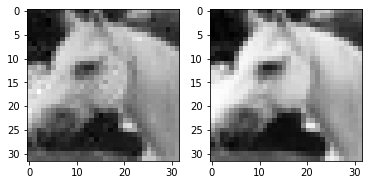

True label: 7
predicted label: 3
Time:  312.08488154411316  seconds
Initial fitness: 
 [-0.4274783189946706, -0.49512309468476645, -0.44028618192677893, -0.4985928955797364, -0.4984381904459973, -0.5025554070743686, -0.30147911580398523, -0.5451397225647231, -0.4599055402473061, -0.5069191868551144, -0.5272999834011064, -0.4226491189550814, -0.47203624542433964, -0.23650593274530507, -0.46763622935391963, -0.49866560879832855, -0.41811621133312854, -0.4416546297634407, -0.44411257913276425, -0.4791334720519479, -0.49570229504109, -0.4980286035174951, -0.5064187441560557, -0.23616345868296687, -0.4888288898302878, -0.48563877849022036, -0.4453578076686424, -0.3864066090001834, -0.5270761036274857, -0.4331646078857797, -0.4887441383471728, -0.4446419013899521, -0.5121631023473296, -0.48504039434000523, -0.482093551931542, -0.4373915022055641, -0.41832252273243575, -0.49398998914617687, -0.5084317669793903, -0.3912339254766085, -0.4914980808878534, -0.5246413121466668, -0.4445511296444916

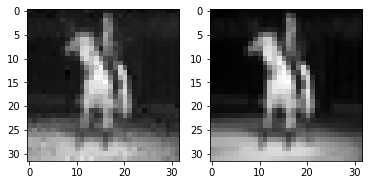

True label: 7
predicted label: 5
Time:  358.7510039806366  seconds
Initial fitness: 
 [-0.6002326404343727, -0.600272668573445, -0.6023267879145994, -0.6002005016740476, -0.6004762342578813, -0.600511188456563, -0.6003558931003563, -0.6004550668760748, -0.6013575918550788, -0.6004858776660716, -0.6006119064648671, -0.6001071193116554, -0.6003716796056449, -0.6002681118529698, -0.6003289153538887, -0.6004622156304271, -0.6002652754144524, -0.6011662219079252, -0.6005295489354322, -0.6005775878632407, -0.6002250171755483, -0.6002115460600361, -0.6000024837283187, -0.6000783870720164, -0.6000858122159951, -0.6001833031711499, -0.6013005726949514, -0.6003104087218352, -0.6004244813255151, -0.6007161553074365, -0.6004716941371588, -0.600140550953107, -0.6002660276100852, -0.6000574445955535, -0.6005353681028824, -0.6003656809280948, -0.6000348190226965, -0.6000831500348821, -0.6001110595031712, -0.6004793694692815, -0.600305940143183, -0.600099095201844, -0.6020002571405254, -0.601173419562

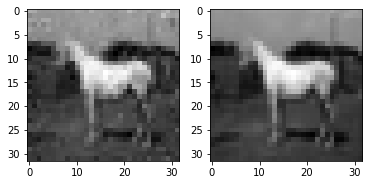

True label: 7
predicted label: 5
Time:  655.8026020526886  seconds
Initial fitness: 
 [0.5291379133280323, 0.6070136868119952, 0.599650825818736, 0.4930492110680551, 0.6065669080598937, 0.5915372093250381, 0.5758259948507943, 0.5253018124848614, 0.5900226400638277, 0.5299127886917655, 0.6565772900895773, 0.5688121912367748, 0.5247437579188785, 0.5711999723943906, 0.6568478971883699, 0.5627484000802416, 0.6259157459490406, 0.5977155834287617, 0.575673149812475, 0.5408403944369025, 0.5743670540436137, 0.6535616684129664, 0.5718614623316653, 0.6159038619363705, 0.5669606100089285, 0.5444815126966237, 0.6370570078200453, 0.589658697236056, 0.6146378324837731, 0.645738123148712, 0.5193599853720166, 0.5642680442395558, 0.5531460835356155, 0.5648075773928982, 0.5747722601110692, 0.612623873641627, 0.5648567274000497, 0.6455037031062982, 0.5461360248241449, 0.6684582391262031, 0.5085617256803783, 0.5641131732894737, 0.7149490940369789, 0.605654419222591, 0.5949687971157326, 0.5971260391302708,

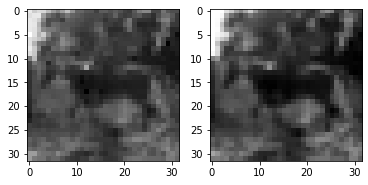

True label: 7
predicted label: 4
Time:  353.57920479774475  seconds
Initial fitness: 
 [0.3997824432921217, 0.20988479042493252, 0.24659991301968825, 0.5306436140169306, 0.31714686999991354, 0.18176428287614257, 0.35608882363414474, 0.38392105285638395, 0.2913697381915601, 0.4068625977245686, 0.3901696150700888, 0.3911590547308516, 0.44871852863788353, 0.3512925239169229, 0.3035525962609107, 0.36830884041842316, 0.2675281137359016, 0.2882494910346979, 0.27092067971987344, 0.2756324920283768, 0.3333414460278541, 0.31422194451558927, 0.25052265774901616, 0.2557992093180618, 0.27586193965716777, 0.541421015772374, 0.36755244257546005, 0.6360164660630884, 0.35510335188808545, 0.3594885672041302, 0.27689314904628626, 0.29246545735585616, 0.41247917430982317, 0.30359004894312913, 0.31033381410508043, 0.3694943057865512, 0.3811300972935593, 0.30809965810723794, 0.3423774995177504, 0.31498424822382315, 0.40398823829119657, 0.324799279983149, 0.13371494982788967, 0.3535234209584736, 0.393531018

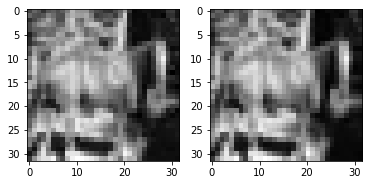

True label: 7
predicted label: 9
Time:  379.7371349334717  seconds
Initial fitness: 
 [0.24971002402406192, 0.262198216569674, 0.40933750451773676, 0.17265407408719052, 0.3436881724514154, 0.22516558239856604, 0.435607990453393, 0.21125820857045177, 0.2745709151205044, 0.1705708830269073, 0.2444099261872538, 0.2183202784323512, 0.1386517131961809, 0.5890205000634111, 0.33808637334803465, 0.19164102235875494, 0.2951580927686652, 0.28491772677178756, 0.18367530766768744, 0.28124972896892625, 0.31888557916443294, 0.43440390815820706, 0.3354873085434388, 0.11472726125268115, 0.2272002483478405, 0.19249496415593606, 0.41530518919496995, 0.29799567271077043, 0.19703125093244225, 0.2136543021901121, 0.24886018431292342, 0.12516688647196095, 0.22970085967777595, 0.09227931377604279, 0.2556669372154336, 0.18375032089136448, 0.23470800818162924, 0.4666002607828017, 0.31028365219269893, 0.49089481988562234, 0.41766475179881957, 0.34058783993850655, 0.5124303927620144, 0.218924086142403, 0.3096659

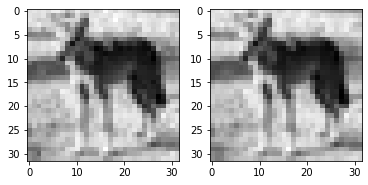

True label: 7
predicted label: 4
Time:  237.31002402305603  seconds
Initial fitness: 
 [-0.5807296903287349, -0.5748954002168851, -0.5388082796987104, -0.567867935016662, -0.5794727214869504, -0.5876424754319346, -0.5786386318564851, -0.5719157932923731, -0.5796391604318094, -0.5762274175228422, -0.5714999660723608, -0.5734968493276023, -0.57903278677547, -0.5800758571769864, -0.564435457175924, -0.5723030558934392, -0.572586725040241, -0.5714686360449914, -0.5802018731976604, -0.5778277902609245, -0.5805455236380541, -0.5821187435074529, -0.5846714864831841, -0.5819852210356684, -0.5788984636007966, -0.5894387926128116, -0.5667978956660398, -0.5806501707191796, -0.5856465985780422, -0.5755856596417765, -0.5527363333705801, -0.5887768808636895, -0.5445815373173859, -0.5805158544523932, -0.5789155340944265, -0.5796799058637667, -0.5849514014159006, -0.5732998582054788, -0.5801720405764692, -0.5810550071555499, -0.5746855524362506, -0.5776121233342507, -0.5846009963709509, -0.57555382958

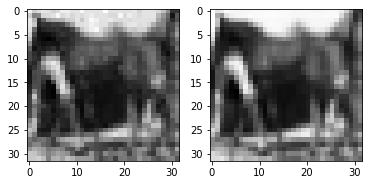

True label: 7
predicted label: 6
Time:  491.10070848464966  seconds
Initial fitness: 
 [-0.5955773580777698, -0.5970559252557882, -0.5941466171082177, -0.5974928621753254, -0.5924587841113375, -0.5974548081790167, -0.5968278460512186, -0.5960709603761093, -0.596030452712546, -0.5968051218274861, -0.5942654588894111, -0.5972039417209005, -0.5973109508755079, -0.597024206102884, -0.596337432685285, -0.5961609082073265, -0.5973118585682531, -0.5923102857692613, -0.5975458022887498, -0.5924376950428247, -0.5967320919757049, -0.5969477076130368, -0.596236921020092, -0.5969396157148052, -0.5972256309864721, -0.5970037085668984, -0.5972014305190962, -0.5973102258256178, -0.5970373423850175, -0.5964691999354161, -0.5965005635734408, -0.5967246528170574, -0.5979367967420722, -0.5970991057755981, -0.5966581842850016, -0.5961712076243094, -0.5969937178173788, -0.5898099217847407, -0.5950725958250254, -0.5972624341464641, -0.5979271614336092, -0.5979284104107969, -0.5952231844352125, -0.5967126129

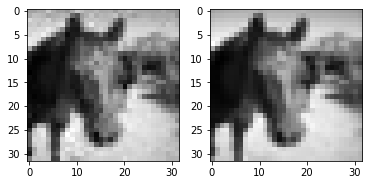

True label: 7
predicted label: 3
Time:  626.6404519081116  seconds
Initial fitness: 
 [-0.5882800391382861, -0.5897833232253744, -0.5901122871795693, -0.5868678116360551, -0.5940074766131962, -0.5900490811591744, -0.5828966307021981, -0.5902888512685017, -0.5906189019504118, -0.5895478650074798, -0.5891017839047421, -0.5762654924515559, -0.5882859327479074, -0.5959686549164666, -0.5888805243136982, -0.5904395478158521, -0.5894965858588489, -0.5880444637412036, -0.5897946242629584, -0.5887499777899187, -0.5847198666733786, -0.5890780332498612, -0.5926183833463728, -0.5919838815011542, -0.5879932331256771, -0.586418593150653, -0.5870715959619023, -0.5895707217623769, -0.5919943892174504, -0.5866078802702137, -0.5891975607542511, -0.5892566836683257, -0.5908899628418514, -0.5871148939921865, -0.5804190462734471, -0.5912379503861747, -0.5909699203174517, -0.5872869513289064, -0.5903461959438026, -0.589207241074479, -0.5892431012979913, -0.5905704006268782, -0.5866083885773615, -0.586309085

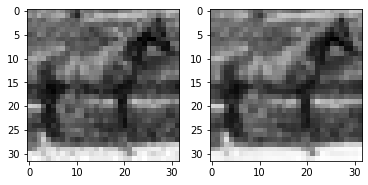

True label: 7
predicted label: 4
Time:  525.6460702419281  seconds
Initial fitness: 
 [-0.17650050254171845, -0.23416359906351553, -0.2712740933603426, -0.29713688833224855, -0.2955712240959311, -0.29368745377433897, -0.25963401929612595, -0.2965678721587779, -0.3406712649490494, -0.2836548386755845, -0.27478474703256867, -0.33159686995038734, -0.21875358674330125, -0.33862033965715777, -0.18963068840319572, -0.3007970862470484, -0.4172828012032568, -0.42394613528562625, -0.34193716245460437, -0.2817702525023693, -0.21283004023421026, -0.21341030220799012, -0.3627944565377173, -0.2750097133629546, -0.2510644097377885, -0.1549167402496869, -0.23769330442778747, -0.21858361593530437, -0.10033194644655863, -0.2774705602983629, -0.2712979253621379, -0.2881659663220793, -0.27067409943284176, -0.24421609943760875, -0.23085033327870152, -0.27285884712874553, -0.2024776262804734, -0.24579382805133174, -0.2979335906626917, -0.2021922105425933, -0.36407710948421945, -0.22588028870066457, -0.3715

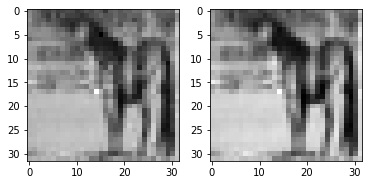

True label: 7
predicted label: 4
Time:  282.8400082588196  seconds
Initial fitness: 
 [-0.5998545717288551, -0.6017080194753811, -0.5999746495204095, -0.6005583071364158, -0.6005753084577354, -0.599584858228837, -0.5993629660577957, -0.5992796059384825, -0.600179586577099, -0.5979477919447393, -0.5996532448656777, -0.5991675111096426, -0.5993536562269617, -0.5996606323103296, -0.5994702356918207, -0.599970156042122, -0.6009593664830575, -0.5988826559679676, -0.5991329684395599, -0.5993469447005937, -0.6015212305370166, -0.6008583177412471, -0.5992712296233242, -0.5990812391422217, -0.6012400136450458, -0.600160634869617, -0.5999963586541127, -0.5990793836922553, -0.6006820500851638, -0.599433331906521, -0.5993036407576525, -0.5993787755524246, -0.5990050621382268, -0.600086954139988, -0.5993559997515128, -0.5993291484425511, -0.5997158616011519, -0.5999721532627171, -0.5998381758434185, -0.5997362572654374, -0.599642862068833, -0.6001203096425319, -0.6001052275389659, -0.60055020241565

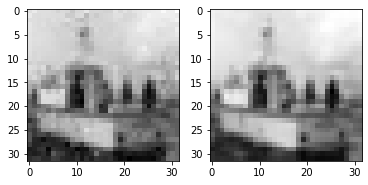

True label: 8
predicted label: 9
Time:  444.26717591285706  seconds
Initial fitness: 
 [-0.5733787341351616, -0.5736395172690436, -0.5738633903816384, -0.563066175166114, -0.5768982192764068, -0.5763750958002953, -0.5689830228885371, -0.5657165340186181, -0.5805243227368793, -0.5568487079284485, -0.567460474280204, -0.5632099604219929, -0.5706323459848714, -0.5804533649456023, -0.571510142312816, -0.5749164536365787, -0.5612325744864568, -0.5589345542805151, -0.5740021533527259, -0.5678919917592821, -0.5726234888775221, -0.5752314076767595, -0.5787176421240403, -0.5724962311181022, -0.5714628251216416, -0.5549938331025142, -0.5754547541188934, -0.5428093332046006, -0.5485857943621948, -0.5759515585391946, -0.561337512691892, -0.5658974542429163, -0.5680089512485853, -0.5707983666739869, -0.5752552213412679, -0.5662654503922419, -0.5735089155630337, -0.5803634304585275, -0.5501924832500598, -0.572091759309593, -0.5730210180870122, -0.5677247172447952, -0.5745751046872978, -0.57497069191

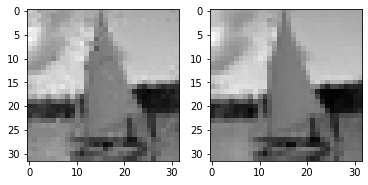

True label: 8
predicted label: 4
Time:  367.92458963394165  seconds
Initial fitness: 
 [-0.3329452778052874, -0.30159899091429443, -0.0836350766064935, -0.4267914735547869, -0.22331026762459422, -0.15887047183501204, -0.21473604887024328, -0.34659363625290807, -0.3752630259595477, -0.2355001303235997, -0.11992461477750785, -0.4136589405928693, 0.003707935883399044, -0.2678347976140767, -0.35931818786526326, -0.16215944923499503, -0.4491664741147091, -0.34959222194583284, -0.3103014113969099, -0.4049663912457121, -0.22341338288105556, 0.07935010103465025, -0.26415985970094563, -0.4421480585258847, -0.25200742331192455, -0.18883705502961323, -0.361846024171273, -0.42313017256555857, -0.2542375377011607, -0.46798187265528063, -0.3099925800688609, -0.31328820775242827, -0.166592773385055, -0.2556870995049122, -0.38288870895116156, -0.3214907253191275, -0.4029504683081542, -0.4324385402792147, -0.2777273058782672, -0.33644070299333717, -0.35368360722032477, -0.2495844067811395, -0.359919396

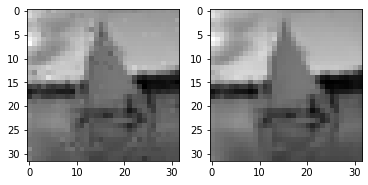

True label: 8
predicted label: 7
Time:  280.2381386756897  seconds
Initial fitness: 
 [-0.6037464287053355, -0.5998277042169177, -0.6018555970351008, -0.6020135534352409, -0.6105403232072648, -0.601292281240247, -0.6049351314467517, -0.603968431214237, -0.60178534879804, -0.6004515416932905, -0.6046079487859024, -0.6014082273944088, -0.6025433440076857, -0.6084008717986329, -0.6038179256823951, -0.600954832181455, -0.6040694199117749, -0.6099025529255044, -0.6053398186732206, -0.6012658006347615, -0.6085268015116082, -0.6030783260913563, -0.6102529587641685, -0.6010284780292885, -0.601864835703366, -0.6025623596280871, -0.6093874750772299, -0.6007695566953855, -0.605113201269307, -0.6032200715368801, -0.6052434184599147, -0.6066107751012904, -0.5999820548575278, -0.6013165370200892, -0.5999363714759097, -0.6013692639785582, -0.6008609275487373, -0.6020455210211983, -0.6005103151613955, -0.6003245822955444, -0.6007110587414335, -0.6001208443995276, -0.6077565052357651, -0.60682038039421

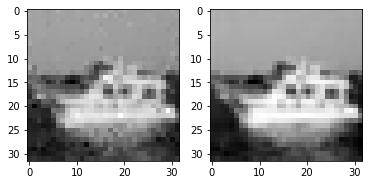

True label: 8
predicted label: 0
Time:  391.33685302734375  seconds
Initial fitness: 
 [-0.5994627269355116, -0.5994324658135048, -0.599618974518827, -0.5994478646350061, -0.5996864700442457, -0.5996745658085503, -0.5994940933766724, -0.5996211899603978, -0.599489367372191, -0.5996685947749758, -0.5997974311858685, -0.599089445641114, -0.599508735371968, -0.599468056521362, -0.5992992262007195, -0.5993030352943716, -0.5997940898732559, -0.599742131392819, -0.5996868687040997, -0.5995034334294398, -0.5997462624251461, -0.5993498738848189, -0.599279319274237, -0.5996723414459604, -0.5994490508751269, -0.5995689626698959, -0.5989467359989704, -0.5993482863427307, -0.5991304956785699, -0.5995714977774601, -0.5997226537762012, -0.5995460772962766, -0.5997661629488436, -0.5995163990489987, -0.5995481111542988, -0.5997031465482403, -0.5999955062007649, -0.5992277368575062, -0.5993849451565942, -0.5997713421420725, -0.5995079649406707, -0.5997484485280548, -0.5997215114555055, -0.5992040175002

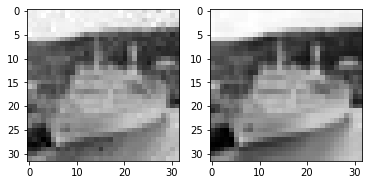

True label: 8
predicted label: 6
Time:  546.5156817436218  seconds
Initial fitness: 
 [-0.5911565207556483, -0.5867883619518022, -0.5931589967114177, -0.5902428018384718, -0.589430501277439, -0.5859476997223344, -0.5888230212372475, -0.5903537019198478, -0.5919958561381355, -0.5870511167689273, -0.5853014438001669, -0.5868883228286306, -0.5940725140252658, -0.5941452295624248, -0.5916340050381674, -0.5900837634735878, -0.5947821482990403, -0.5867106225760538, -0.5936583749067706, -0.5922818840786784, -0.5870055098694557, -0.5900072230409992, -0.5903910876975331, -0.5933017755536408, -0.5918968337367272, -0.5908708309857704, -0.5919683031018969, -0.5930739576323338, -0.5897404886194881, -0.5948790941742468, -0.5929269620067875, -0.5804624393983603, -0.5933272939306384, -0.5837076064161486, -0.5887477616886725, -0.5768003100468313, -0.5952787294734271, -0.5966931931767352, -0.5898176622828742, -0.5904800668522439, -0.5852656575390778, -0.5885665027173832, -0.5944002643369402, -0.59460997

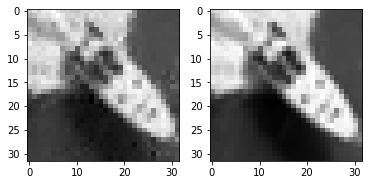

True label: 8
predicted label: 0
Time:  666.406142950058  seconds
Initial fitness: 
 [-0.6014995783677614, -0.6006419202381774, -0.6041264748567403, -0.6060036994670784, -0.6008082347221853, -0.6002834131093558, -0.6022613570439584, -0.6018858047925686, -0.6006746794462076, -0.6059476765462255, -0.6014804102529839, -0.6017305172392181, -0.6021733555428872, -0.6002211652114584, -0.6030548010021819, -0.6031863767811302, -0.6004853801880606, -0.6016872683964676, -0.6021865438387104, -0.6013455003750495, -0.6018388206629186, -0.6010513014738762, -0.603658525439198, -0.6009127491733172, -0.6006793166120857, -0.6002313770133952, -0.6025833819404519, -0.6012818463975408, -0.6047821210952506, -0.601118970359912, -0.6040156173528961, -0.6004705047738969, -0.6009491249996741, -0.6014811775890853, -0.6010462815654097, -0.6058243636715271, -0.600887879243355, -0.6000321159753581, -0.6025759090955545, -0.6006804289264799, -0.6012803954844803, -0.6003450379472984, -0.6014110767038408, -0.60179666198

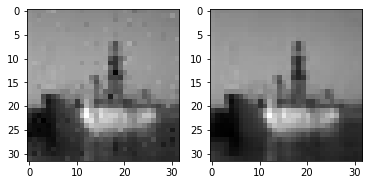

True label: 8
predicted label: 4
Time:  239.1803321838379  seconds
Initial fitness: 
 [-0.599975365437941, -0.5996668204389979, -0.599698622180221, -0.5999083374240721, -0.599673338688419, -0.5995619652530552, -0.5997598835053551, -0.5996647601683529, -0.5991171288449716, -0.5997009788513247, -0.5991456896321419, -0.5995092732464082, -0.5998910303933688, -0.5996127676957793, -0.5998311134172427, -0.5994770374343918, -0.5998065773900384, -0.5997789703323833, -0.5997979075668535, -0.5999437993812817, -0.5998053971190805, -0.5996694863439942, -0.5995069299195835, -0.5997746324906315, -0.5997959874348799, -0.5990624631822989, -0.5998278138573746, -0.5996267223362416, -0.5996089415574752, -0.5997087650285393, -0.5999558602589706, -0.6002905894397874, -0.5998596898074179, -0.5997715882818543, -0.600104615074899, -0.5995780276759779, -0.5998769707241121, -0.5997133263411694, -0.599539067317723, -0.5999945526642498, -0.5998114741111638, -0.5997454378760918, -0.5996347661927882, -0.599759862639

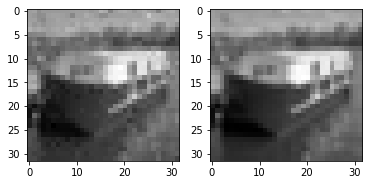

True label: 8
predicted label: 6
Time:  351.9790916442871  seconds
Initial fitness: 
 [-0.45051042059894525, -0.4284005578411987, -0.30850149300200047, -0.18330835748053992, -0.4444732130605549, -0.26361021108685645, -0.35955474348277894, -0.2903020530739342, -0.09320810379486785, -0.18441740072093377, -0.21239078524891605, -0.3771465391090688, -0.5035794889985178, -0.2376030000129766, -0.3625085541174715, -0.3764749129827806, -0.3326668260370476, -0.3531209576551575, -0.5366452081748251, -0.46031990091275976, -0.4412892920668299, -0.37505526201161876, -0.3583753668391426, -0.1860099525277906, -0.38168087636723064, -0.42608365966317696, -0.3779200701136894, -0.4391347520055624, -0.43972666307882946, -0.4452509829111043, -0.31731967279594164, -0.376072719016569, -0.43030319844727494, -0.3302483447658031, -0.2811995356210264, -0.37524518281522434, -0.33373052919798085, -0.21067004976411108, -0.19815297452673605, -0.30595114170690685, -0.22230303915175934, -0.35175938948574403, -0.3424819

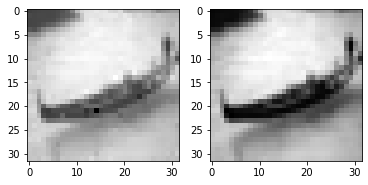

True label: 8
predicted label: 0
Time:  237.9690203666687  seconds
Initial fitness: 
 [-0.6019589002735477, -0.6006331151881733, -0.6014472124987859, -0.6017643225482954, -0.6012000226574155, -0.6004286175645056, -0.5995091098445245, -0.602225032507241, -0.6077110607633752, -0.6007294836907514, -0.601712617073151, -0.5996328276404559, -0.6001053153595821, -0.5995482930410813, -0.6025477950565502, -0.6014272706629396, -0.6032133058711628, -0.6004894373721068, -0.6031802265212066, -0.6008415495499866, -0.6010096396794373, -0.6046445384593073, -0.6015242055537536, -0.6049217349129903, -0.6042559892059424, -0.6036728239337552, -0.6083574978384987, -0.6021642434481218, -0.601603311358801, -0.6036309195497047, -0.6055324469022382, -0.6010431599252064, -0.6014814832914858, -0.599309402933449, -0.6004122389783149, -0.6007481460047241, -0.6014962939062539, -0.5999412179843973, -0.5998816595275482, -0.6028302624418876, -0.6002444342103541, -0.6022028141344635, -0.6032564040530479, -0.59997695400

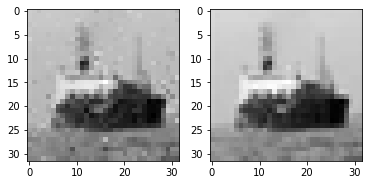

True label: 8
predicted label: 6
Time:  256.08458399772644  seconds
Initial fitness: 
 [-0.6001396669024617, -0.6002727273472892, -0.6009133355684577, -0.6012499703719857, -0.6000568760514068, -0.6003911107237897, -0.6002116994628955, -0.6002794115386109, -0.6004666156483729, -0.6004353356493692, -0.6007031640959243, -0.6007051517312079, -0.6004035111357069, -0.6002372849660271, -0.6002308251299234, -0.6003444505292593, -0.6001160683069495, -0.6004264661282273, -0.6003641619227248, -0.6005388019326483, -0.6006307891844681, -0.6000811266112723, -0.6000674971133386, -0.6001381287516534, -0.6003194136036873, -0.6002816064691711, -0.6001901217000845, -0.6004489864385483, -0.6002860301761191, -0.6002210110475565, -0.6006499228925078, -0.6003959459609673, -0.6001974358078963, -0.6001511897455577, -0.600101985511926, -0.6006912029840263, -0.600179591942006, -0.6005628491998573, -0.6002571051659896, -0.600775584231414, -0.6001756487423221, -0.6002603387623235, -0.6000603016942058, -0.600160754

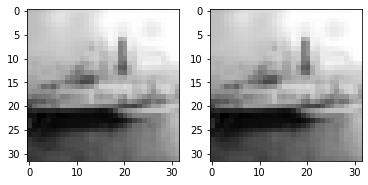

True label: 8
predicted label: 8
Time:  95.87087345123291  seconds
Initial fitness: 
 [-0.5995603317531772, -0.5996610564818212, -0.599580007703484, -0.5991693965953133, -0.5991387197661382, -0.5997168115124674, -0.599567975371943, -0.599680734598996, -0.5997543760472762, -0.6000123943378107, -0.5997742262289893, -0.5991910460705355, -0.5992576797482786, -0.5998833835937641, -0.5996082740769986, -0.5995236263049684, -0.5995507307987079, -0.5996387715461291, -0.5998151879747946, -0.5994444099395894, -0.5994631340890293, -0.5998382008184621, -0.5995224612534968, -0.5995995386794457, -0.5993033311532026, -0.5995668322385501, -0.5993387300194508, -0.5995623144221931, -0.5996198377496151, -0.599347525760525, -0.5991019993399086, -0.5996767639942684, -0.5996302079954734, -0.599510586553221, -0.5995296066508412, -0.5992340233708084, -0.5994885491159319, -0.5995297742914969, -0.5994715589662192, -0.5995825912431183, -0.5998954979270058, -0.5980926952199286, -0.5997726111673125, -0.599572031742

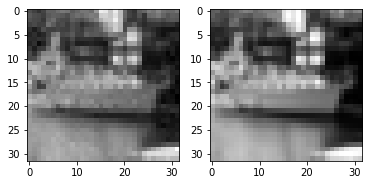

True label: 8
predicted label: 3
Time:  437.15791296958923  seconds
Initial fitness: 
 [-0.6006482361588406, -0.6024246383112322, -0.6045122819937333, -0.6014733605402677, -0.6059144953557988, -0.601124092410875, -0.6019721549647584, -0.6018127575820926, -0.6008835331044473, -0.6002159197061985, -0.6062514875594991, -0.6014309819256578, -0.6041094993629763, -0.6026771951663814, -0.6020415118547529, -0.6027561182537062, -0.6045011284492428, -0.6013632558605182, -0.602618765167725, -0.6006190267176166, -0.605607313721418, -0.6030985089212643, -0.6006509733632317, -0.6073405749911627, -0.6019965587657969, -0.6023975636016515, -0.6017899576935205, -0.6018703255363769, -0.6043059107146537, -0.6048616389864384, -0.6019886402148744, -0.6023366485770706, -0.6066946360266849, -0.6020062349897835, -0.601414480626389, -0.6029367894317365, -0.6028481196306951, -0.6047863158811801, -0.601830886106316, -0.6012347033690453, -0.6027423796499735, -0.601936788835392, -0.6003700039112824, -0.603223545532

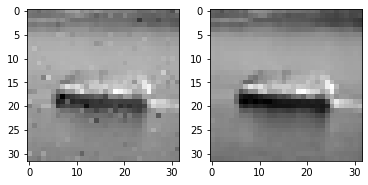

True label: 8
predicted label: 0
Time:  175.5661599636078  seconds
Initial fitness: 
 [-0.5999219175845588, -0.6000737784570404, -0.5999192025823006, -0.5999160156094172, -0.600016545449177, -0.6001624062695531, -0.5998805441678202, -0.5999774538531016, -0.5999165326964282, -0.6000366446886883, -0.5998974697286812, -0.5999384795794966, -0.5999974758674248, -0.6000034195287877, -0.5999826448359308, -0.6000689152046913, -0.6000203854138816, -0.5999269535602731, -0.5999811874881258, -0.5999542850695788, -0.5998880603060813, -0.6000009267455819, -0.6000005434088206, -0.5999742713747331, -0.6000130032999106, -0.5999553502294845, -0.5999356844882728, -0.5999737343492698, -0.5999472515625132, -0.5999422520611255, -0.5999134605239458, -0.5999091210007136, -0.5998220751921262, -0.5999381463091678, -0.5999081715708467, -0.5999217081352907, -0.5999487985271845, -0.5999738319011051, -0.5999990603118384, -0.6000441638892493, -0.6000106093561538, -0.5999686730354681, -0.5999258579996161, -0.59988796

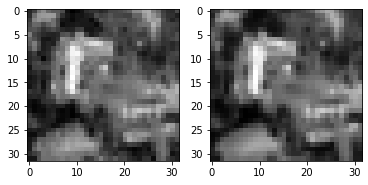

True label: 9
predicted label: 4
Time:  753.087557554245  seconds
Initial fitness: 
 [-0.23244229586821236, 0.029184093639996217, -0.16012861617832524, -0.23546248762210803, -0.31780969585848273, -0.23796006602023634, -0.3144634934223601, -0.18067824241209068, -0.11296496862783184, -0.19981509783111845, -0.13295167161258964, -0.17897862169242118, -0.30556782580230446, -0.24673023729706028, -0.07047955159502306, -0.23825828925417042, -0.22261299388293507, -0.16260780544943448, -0.3154609156169592, -0.022658359983524112, -0.12300120401617856, -0.08514990408352852, -0.35492759541500113, -0.021015823670991696, -0.2635187247313183, -0.26200490074506044, -0.1898539116327857, -0.394926965544535, -0.32267481636903506, -0.10300166210734127, -0.2599355825900813, -0.2636028880699789, -0.2448698310327883, -0.27359292834219584, -0.352291712346475, -0.22425294279366645, -0.2316831619365508, -0.37066582401395176, -0.23502115443671304, -0.1272200518204349, -0.1662403982266071, -0.29868234500638347, -0

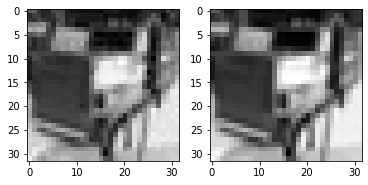

True label: 9
predicted label: 1
Time:  522.586546421051  seconds
Initial fitness: 
 [-0.5978202630415812, -0.5980223399703088, -0.5981724003950292, -0.5980366885896357, -0.5979233902278476, -0.5984468273254884, -0.5981855275648875, -0.598291822444531, -0.5975268111999446, -0.597440124993608, -0.5983953739658897, -0.5986521571960377, -0.5983764260587292, -0.5984539913181065, -0.5985093527483619, -0.5974545757268543, -0.5981532270936399, -0.5973838665146147, -0.5981980828124921, -0.597860428816928, -0.597469456860714, -0.5983907836317491, -0.5980306481134939, -0.5968502965922524, -0.5983486062012184, -0.5982784367268732, -0.5979811927725387, -0.598501387531946, -0.5990507235698809, -0.5986279579553339, -0.598024683433638, -0.5987190222381498, -0.5970701793544531, -0.598763468433834, -0.5994917706437131, -0.5975140567014057, -0.5972235993963395, -0.5978691596246615, -0.5967020416902261, -0.5984785678699365, -0.5976434857341896, -0.5982723302723323, -0.5975589181750244, -0.599260876397553

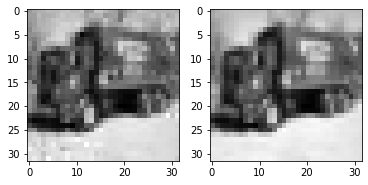

True label: 9
predicted label: 1
Time:  445.67823910713196  seconds
Initial fitness: 
 [-0.6010668331241543, -0.6044376952645213, -0.6013656917041538, -0.6013691463879337, -0.6006904898389567, -0.6001184130809704, -0.6042396307743788, -0.6003668728596454, -0.601563923822528, -0.6025785144594443, -0.6003940785457174, -0.6014705480156367, -0.6006427899062108, -0.5999817666850213, -0.6008413745186074, -0.6022000094233206, -0.6082272275639233, -0.6002969032202559, -0.60368550171858, -0.600021855280145, -0.599929733049695, -0.6005464308425128, -0.600675665949565, -0.6012274974217854, -0.6003813067455601, -0.6006057942404179, -0.6002272347589153, -0.6011658667095391, -0.5999709430411716, -0.6017982237290244, -0.600024763608457, -0.6032775034962301, -0.6024554403678127, -0.6000182333721887, -0.6007098856079919, -0.6004320973359235, -0.6006780868530068, -0.5999824672092049, -0.603856651060839, -0.6027855340216726, -0.6028168352387078, -0.6009003300104299, -0.6021201901530907, -0.60004918954602

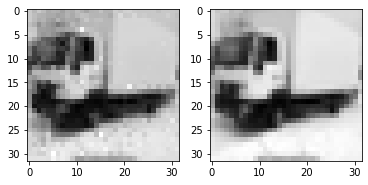

True label: 9
predicted label: 8
Time:  220.17974638938904  seconds
Initial fitness: 
 [-0.5998686334378601, -0.6019065800236968, -0.599590034222694, -0.6004224998631114, -0.5993796934906366, -0.6016943569180773, -0.6036739550312122, -0.6022846253390324, -0.6004504139242504, -0.6053748788647505, -0.6046358487202974, -0.6011652002858314, -0.6011390141027976, -0.6005872550863313, -0.5999085197260192, -0.6019222086471089, -0.6024813579988799, -0.6025755593018869, -0.5998769077366719, -0.6009010869033413, -0.6019457792421664, -0.6000111746284292, -0.5999316404951199, -0.6024114612814595, -0.6008716899315242, -0.5999731963012724, -0.6007785684367142, -0.6020067333556999, -0.6004897789541668, -0.6010419358604373, -0.6046726184935953, -0.6013550149548565, -0.6009622634590674, -0.600060141219249, -0.6003277450125727, -0.6002148144286302, -0.6028909837030758, -0.6019985061441568, -0.5999720586792815, -0.6022683555896926, -0.60176504581275, -0.5997532903707451, -0.6034279253412165, -0.6039624949

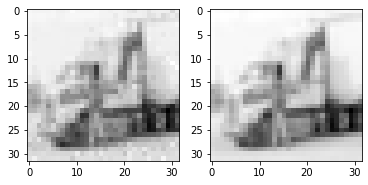

True label: 9
predicted label: 8
Time:  235.4977171421051  seconds
Initial fitness: 
 [-0.6002721619422026, -0.6002105906576343, -0.6000197683309015, -0.6000547834974298, -0.6002132305026444, -0.6000543746775617, -0.6000806821375999, -0.6001544511489973, -0.6000475162861212, -0.600169511371321, -0.6000374020482129, -0.6000581653672363, -0.6001296953348323, -0.6000676467185595, -0.6000948196355268, -0.6001452271862178, -0.6000236753471362, -0.6002340957639416, -0.6000899465706709, -0.6000292431233245, -0.6000219013844122, -0.6000880146077627, -0.6007606644755511, -0.6003952883279497, -0.600169325210614, -0.6001054384396448, -0.6001233381235552, -0.6001075719983328, -0.6001720915946981, -0.6000483982228925, -0.6000344138008149, -0.6000615487165194, -0.6002598105273291, -0.6002804237646104, -0.6001006798397643, -0.6001016194849607, -0.6000475903406469, -0.600226114626091, -0.600115166636652, -0.6000143622941044, -0.6000408869368101, -0.6002265542432186, -0.6003760552435162, -0.60018338738

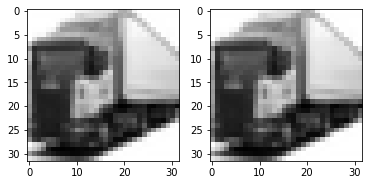

True label: 9
predicted label: 9
Time:  95.26050853729248  seconds
Initial fitness: 
 [-0.4831466799379488, -0.3801408609604338, -0.4884219076976847, -0.40659377786633055, -0.49901601918319477, -0.4763243319756555, -0.3202094527851034, -0.4984340408249392, -0.4522399510150601, -0.4889099363696533, -0.44211752439357416, -0.47534052526669524, -0.5179926298902523, -0.5278935401038004, -0.4936012434915651, -0.5089731083516824, -0.5001027525578825, -0.48868586458849916, -0.4913211305872036, -0.5030610790147889, -0.4322164004845167, -0.4939191580793975, -0.499166597542531, -0.48399845403576264, -0.46612241090078244, -0.5362591768742688, -0.46873261372038855, -0.4680712391514579, -0.4857846061730049, -0.45867172782111315, -0.49038670354743696, -0.51664232768388, -0.47702717268291384, -0.38651306581256023, -0.45279455470023805, -0.3281725348445527, -0.5160461332207971, -0.47151724844712983, -0.45173555980377467, -0.4785846230985059, -0.45834650405646576, -0.4920761209601409, -0.436672490461200

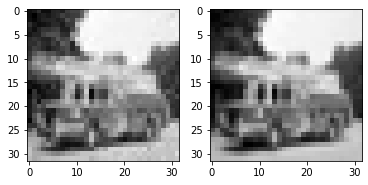

True label: 9
predicted label: 1
Time:  484.008563041687  seconds
Initial fitness: 
 [-0.5997686905423609, -0.59987005696896, -0.5998515122189287, -0.5998683385809072, -0.5998692712304948, -0.6001068586680927, -0.5997285490467701, -0.599986905219922, -0.5999383995296866, -0.599847942109245, -0.5998137795645575, -0.5998104462197471, -0.6000101432104546, -0.5998270186610218, -0.5998175163811748, -0.5998344025629384, -0.5999262981139524, -0.5997720574427383, -0.5999249514886221, -0.599763852098739, -0.5998849739422332, -0.5999134924058448, -0.5998342093153878, -0.5997955654176321, -0.5998186093518381, -0.5997573937691558, -0.5998538960361279, -0.5997758539330242, -0.5999456749100799, -0.5999161152116861, -0.5998210508136566, -0.5998592961946644, -0.5997073493203632, -0.5997412634375079, -0.6000376870791655, -0.5997725234845107, -0.5997520061532889, -0.5999698949916215, -0.5998785096554818, -0.5997861928852153, -0.5998939876874436, -0.5997878173337164, -0.599919951191034, -0.60008218705309

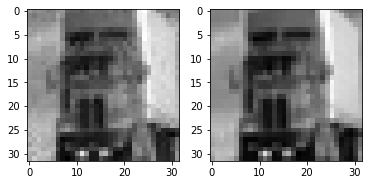

True label: 9
predicted label: 1
Time:  441.10553193092346  seconds
Initial fitness: 
 [-0.5124871631362381, -0.533752839866935, -0.4991980224002901, -0.5201177981500726, -0.5589918908328518, -0.5156651264512346, -0.5247405480206024, -0.4901903344886932, -0.49724035790175736, -0.4817256102717238, -0.5114276233010842, -0.5100890024962086, -0.528463427329995, -0.5397735146168268, -0.5417417168128014, -0.5210424895155936, -0.5187778998580491, -0.5166590815953848, -0.5132970880527146, -0.5211758483164226, -0.515869575326407, -0.5367482091073352, -0.530317623801738, -0.527852971052054, -0.49933962756394823, -0.5234387242930323, -0.5264241197305122, -0.5179804673958925, -0.5158282161162804, -0.48562314404676266, -0.5172187764246851, -0.5339284223929281, -0.5111078831105669, -0.5251423355377849, -0.5179824811704843, -0.5190179609770783, -0.5106822238225746, -0.5083301502349084, -0.479780309892173, -0.5368113803467754, -0.47581294911326044, -0.48723331595167074, -0.5120934477099115, -0.5246583

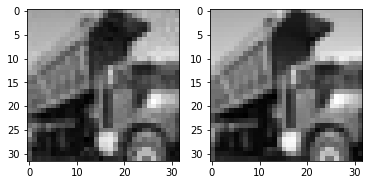

True label: 9
predicted label: 2
Time:  345.5963535308838  seconds
Initial fitness: 
 [-0.5980366248233631, -0.5989214695123829, -0.5982048025690283, -0.5974203402798781, -0.5979664490087523, -0.5975694769677042, -0.5983108023244061, -0.5993754332721939, -0.5982971175230366, -0.5972627775258412, -0.5992447937404035, -0.5977767550701124, -0.597835488385302, -0.5973654762434669, -0.5974407936544995, -0.597583999170566, -0.5991445416226736, -0.5984559130928038, -0.5976672821018543, -0.5994983463103655, -0.5986465819806311, -0.5980706310423884, -0.5979385308241889, -0.5973734083541078, -0.5981015348654601, -0.5987038214313141, -0.597793398291939, -0.5975522818393894, -0.5979818246212307, -0.5983770519684088, -0.5969393229113795, -0.5976226585500158, -0.5966727079857457, -0.5989469538489143, -0.5984561975254078, -0.5980796529131105, -0.5985343404743306, -0.5981621915390727, -0.5988921561063135, -0.5974452145395691, -0.5985201762655217, -0.5978078425714249, -0.5948235586419114, -0.5987231938

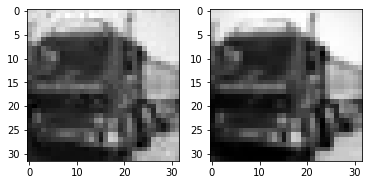

True label: 9
predicted label: 1
Time:  393.9813280105591  seconds
Initial fitness: 
 [0.16951328269320498, 0.13093768635615827, 0.18446149687701185, -0.10313837570899981, 0.10195034814801905, 0.21150618766615448, 0.2246838297431727, 0.19876768861379662, 0.2591571240433615, 0.031620156144500616, 0.1326076658475343, 0.0012354705878604988, 0.025468700884695966, 0.2286021393742526, -0.03680967083876455, 0.2805019783033892, 0.1409147728246093, 0.1527030851020033, 0.1784962427909462, -0.02343600212566871, 0.2503946102479931, 0.19426856013317323, 0.06394321990748672, 0.16573593342769155, 0.2283973179688621, 0.11507053882260232, 0.034796670320920736, 0.21482213367581057, 0.043607297760397595, 0.27305110545015376, 0.0003770452417063974, 0.06923429163108624, 0.23581655904533042, -0.006228982270926692, -0.04665510268236672, 0.2676695639853327, 0.14515076660315973, 0.12329981077809478, 0.07831727153767863, 0.07479691753118323, 0.18521836665554375, 0.01278225585261078, 0.2250193406408121, -0.06428

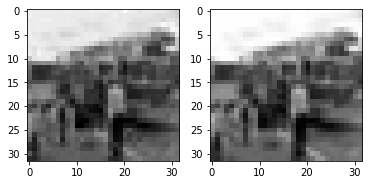

True label: 9
predicted label: 7
Time:  158.12476921081543  seconds
Initial fitness: 
 [-0.6002290897341238, -0.6003109856732939, -0.6003536095786277, -0.6003242817288658, -0.6005622760162233, -0.6004178965700586, -0.6000304504544381, -0.6002277478704664, -0.6000186490311333, -0.6006527366381129, -0.6005122661464743, -0.601130609016044, -0.6002897521463548, -0.6000244219743873, -0.6000577957927598, -0.6010986821934878, -0.6003968310233441, -0.6003944808570284, -0.6017589174610809, -0.6008553073837701, -0.6016235595799382, -0.6001527395688149, -0.6013189839911111, -0.6000012066581384, -0.6005738564720151, -0.6000574210197192, -0.6003513888986396, -0.5999806394099085, -0.6003772075672749, -0.6001891189227883, -0.6001454185051931, -0.6009226137386563, -0.601348744540333, -0.600159740904013, -0.6003609706939507, -0.6015808960205489, -0.6010723285945252, -0.6002673137658358, -0.6006705687668255, -0.6001272832206629, -0.6001003156079396, -0.600392219784573, -0.601514789683142, -0.60116902960

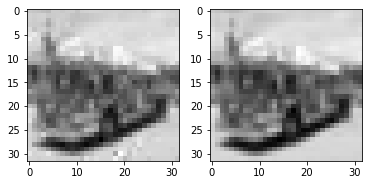

True label: 9
predicted label: 6
Time:  128.85795331001282  seconds
Initial fitness: 
 [-0.6002922682284773, -0.6000671246544592, -0.6000406129050204, -0.6001348524284305, -0.6001345117395098, -0.6000967465794889, -0.6000645718609173, -0.6001787472332791, -0.6000141548316593, -0.6001118349937017, -0.6001226364485541, -0.6004073280629729, -0.6000548910988011, -0.6001329951372473, -0.6001606403103521, -0.6001044650055739, -0.6002996406257203, -0.6003963449964083, -0.6000961419711462, -0.6000512997727069, -0.6001581843869619, -0.6000348654787402, -0.6003628675496546, -0.6000687660416764, -0.6003637093167422, -0.600143669617605, -0.600038343278217, -0.6006457873027784, -0.6005600404561796, -0.6000434951445174, -0.6006739662667681, -0.6007121981902843, -0.6001519433771244, -0.6002384853644381, -0.6003107204358578, -0.6000312620538196, -0.6000762476986392, -0.6004391704930117, -0.6000347780138272, -0.60024003449509, -0.6001124958051567, -0.6001667747276335, -0.6000744943289634, -0.6004267346

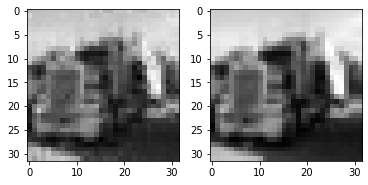

True label: 9
predicted label: 8
Time:  297.4260034561157  seconds
Initial fitness: 
 [0.20440829636395844, 0.22302005699731253, 0.47355518800726304, 0.3537255797844915, 0.3759725483539346, 0.37422569403770445, 0.19962301674986038, 0.27140734746151607, 0.2753707578691736, 0.3565854096860155, 0.3182032799060154, 0.3804958742810354, 0.3533922311868345, 0.40337157699444987, 0.3793666878122961, 0.2175676565466381, 0.34391519164311857, 0.36503945606352395, 0.45237007013765995, 0.3695875297514627, 0.2846380464496514, 0.40630990215405666, 0.40785965610592223, 0.4367635675206285, 0.4432365172354754, 0.11163361250942849, 0.2571625827060272, 0.05003620742736925, 0.1343744532760258, 0.282609248343838, 0.4249339713301634, 0.4510676072573623, -0.1916407946116483, 0.4530036773662354, 0.3222613614809925, 0.4775035838379708, 0.2957585878287695, 0.04695657866267233, 0.013923234364777215, 0.44646411243969897, 0.41655342441220494, 0.40106938221656485, 0.28575831700666676, 0.42300432181550507, 0.356634079

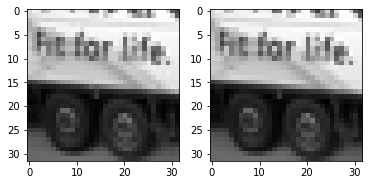

True label: 9
predicted label: 1
Time:  1.9638023376464844  seconds


In [15]:
# for each image and label in adversarial
n=50
import time
# these are the examples that are found as adversarialwe will save these at the end in a file
evolved_examples= []
# fitness of the adversarials
fitness_of_evolved=[]
# time necessary to evolve the adversarial
times=[]
# the distance between the original image and the adversarial
ssim_values=[]
# number of round necessary to produce adversarial 
number_of_rounds=[]
# this will serve to see if the fitness changes or not 
best_fitness = 0


numb_of_found_after30=0
numb_of_adv_found=0

#dictionary to keep the best individual to check if the fitness is improving or not 


predicted_class= []
for img,label in zip(adversarial,adversarial_y):
  winner_of_gen = {"image":[],"label": None, "fitness": None}
  #temporary variable to check generations:
  fitness_no_change = 0
  start = time.time()
  label=label[0]
  #intialize population from the image and with the given label
  population = init_pop_from_sample(n,img,label)
  # calculate fitness of these individuals
  fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),label)
  print(f"Initial fitness: \n {fitness}")
  #retun the best one from the population
  best,fit_max = return_best_individual(population,fitness)
  #check if adversarial
  check_adv = check_adv_termination(best,label,img, model)
  #define max generation
  max_gen=0
  winner_of_gen.update(image= best)
  winner_of_gen.update(label= label)
  winner_of_gen.update(fitness= fit_max)
  while (len(check_adv)==0 or max_gen<10000):
      new_pop=[]
      for i in range(50):
        parent1= tournament(population, model, img, label) 
        parent2 = tournament(population, model, img, label)
        if 0.8 > np.random.uniform(0.0, 1.0):
          child1, child2 = multi_crossover(parent1, parent2,img) # crossover
          new_pop.append(add_noise(choose_better_child(child1, child2,img,label,model)))
        else:
          new_pop.append(add_noise(choose_better_child(parent1, parent2,img,label,model)))

      # to reshape into an array 
      population= np.array(new_pop)
      #check fitness of the generation
      fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),label) 
      #find the highest fitness
      best,fit_max1 = return_best_individual(population,fitness)
      # check adversarial - check if pred != target, distance < 0.001 or fitness didn't improve 0.001 after 30 generations(this is in else condition)
      check_adv = check_adv_termination(best,label,img,model)

      #check if the first termination true 
      if(len(check_adv) != 0):
        print("Adversarial example image: \n")
        evolved_examples.append(check_adv) #add evolved example
        ssim_values.append(1-compare_ssim(check_adv.reshape(CIFAR_IMG,CIFAR_IMG),img.reshape(CIFAR_IMG,CIFAR_IMG))) #add the distance
        end=time.time()
        times.append(end-start) #add the time 
        fitness_of_evolved.append(calculate_fitness(model,check_adv,img,label)) #add the fitness value of adversarial
        number_of_rounds.append(max_gen)
        pred_l=np.argmax(model.predict(check_adv.reshape(1,CIFAR_IMG,CIFAR_IMG,1)/255.0))
        predicted_class.append(pred_l)
        print("Left: adversarial \t Right: ground truth")
        fd, idx = plt.subplots(1,2)
        idx[0].imshow(check_adv.reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        idx[1].imshow(img.reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        plt.show()
        print(f"True label: {label}")
        print(f"predicted label: {pred_l}") 
        print("Time: ",end-start ," seconds")
        numb_of_adv_found+=1
        break
      #check the second termination 
      else:
          #check if fitness increases, if not , add +1 to temporary var
        if fit_max1>fit_max:
          fit_max=fit_max1
          winner_of_gen.update(image= best)
          winner_of_gen.update(label= label)
          winner_of_gen.update(fitness= fit_max1)
          fitness_no_change=0
        else:
          fitness_no_change+=1
      
      #print after every 10 generations to see the progress
      if (max_gen % 10 == 0):
        print(f"Generation {max_gen}")
        print(f"Max fitness value {fit_max}")
      max_gen+=1

      # if fitness did not improve for 30 generations, save the image that was best , saved it in a dicitonary
      if fitness_no_change==30:
        print("FITNESS DID NOT IMPROVE FOR 30 GENERATIONS")
        print("Best adversarial image we could find: \n")
        evolved_examples.append(winner_of_gen["image"])
        ssim_values.append(1-compare_ssim(np.array(winner_of_gen["image"]).reshape(CIFAR_IMG,CIFAR_IMG),img.reshape(CIFAR_IMG,CIFAR_IMG)))
        number_of_rounds.append(max_gen)
        end=time.time()
        times.append(end-start)
        fitness_of_evolved.append(winner_of_gen["fitness"])
        pred_l=np.argmax(model.predict(np.array(winner_of_gen["image"]).reshape(1,CIFAR_IMG,CIFAR_IMG,1)/255.0))
        predicted_class.append(pred_l)
        print("Left: adversarial \t Right: ground truth")
        fd, idx = plt.subplots(1,2)
        idx[0].imshow(np.array(winner_of_gen["image"]).reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        idx[1].imshow(img.reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        plt.show()
        print(f"True label: {label}")
        print(f"predicted label: {pred_l}")
        print("Time: ",end-start ," seconds")
        numb_of_found_after30 +=1
        break




# Save files


In [16]:
import pickle
file_ = open('GA_adv_cifar_multicrossover_seed1', 'wb')
pickle.dump(evolved_examples, file_)
pickle.dump(times, file_)
pickle.dump(ssim_values, file_)
pickle.dump(fitness_of_evolved , file_)
pickle.dump(predicted_class, file_)
pickle.dump(number_of_rounds, file_)
file_.close()

print(f"Max time: {np.max(times)}")
print(f"Min time: {np.min(times)}")
print(f"Mean time: {np.mean(times)}")
print(f"Std time: {np.std(times)}\n")

print(f"Max fitness evolved: {np.max(fitness_of_evolved)}")
print(f"Min fitness evolved:: {np.min(fitness_of_evolved)}")
print(f"Mean fitness evolved: {np.mean(fitness_of_evolved)}")
print(f"Std fitness evolved:: {np.std(fitness_of_evolved)}\n")

print(f"Max ssim: {np.max(ssim_values)}")
print(f"Min ssim: {np.min(ssim_values)}")
print(f"Mean ssim: {np.mean(ssim_values)}")
print(f"Std ssim: {np.std(ssim_values)}\n")

print(f"Max rounds: {np.max(number_of_rounds)}")
print(f"Min rounds: {np.min(number_of_rounds)}")
print(f"Mean rounds: {np.mean(number_of_rounds)}")
print(f"Std rounds: {np.std(number_of_rounds)}\n")




print(f"Percentage of adversarial founds sucessfully : {numb_of_adv_found/len(adversarial_y)} %")
print(f"Percentage of adversarial founds after fitness not improving for 30 generations: {numb_of_found_after30/len(adversarial_y)} %")


Max time: 1156.6763889789581
Min time: 1.9638023376464844
Mean time: 417.7622298244247
Std time: 229.2042221482553

Max fitness evolved: 0.998783635723865
Min fitness evolved:: -0.6022439641919571
Mean fitness evolved: 0.8545252948084725
Std fitness evolved:: 0.4410646831327256

Max ssim: 0.265159994831463
Min ssim: 1.7113638396515363e-05
Mean ssim: 0.027153931511297455
Std ssim: 0.032421658245761396

Max rounds: 280
Min rounds: 0
Mean rounds: 100.23308270676692
Std rounds: 54.66052268430095

Percentage of adversarial founds sucessfully : 0.022556390977443608 %
Percentage of adversarial founds after fitness not improving for 30 generations: 0.9774436090225563 %


Open adversarial

In [17]:
with open('GA_adv_cifar_multicrossover_seed1', 'rb') as f:
    evolved_examples = pickle.load(f)
    times= pickle.load(f)
    ssim_values = pickle.load(f)
    fitness_of_evolved = pickle.load(f)
    predicted_class = pickle.load(f)
    number_of_rounds = pickle.load(f)

In [18]:
#Correction of ssim values
new_ssim=[]
for s in ssim_values:
    new_ssim.append(1-s)
    
print(f"Max ssim: {np.max(new_ssim)}")
print(f"Min ssim: {np.min(new_ssim)}")
print(f"Mean ssim: {np.mean(new_ssim)}")
print(f"Std ssim: {np.std(new_ssim)}\n")

Max ssim: 0.9999828863616035
Min ssim: 0.734840005168537
Mean ssim: 0.9728460684887026
Std ssim: 0.032421658245761396



In [19]:
#Correctionf of rounds  (replacing 0 with 1)
number_of_rounds = np.where(np.array(number_of_rounds)==0, 1, number_of_rounds) 

In [20]:
number_of_rounds

array([118,  87,  77, 151,  71,  57, 163, 138,  83,  54,  61,  53,  78,
       104,  62,  31,  94,  61,  76,  30, 108,  30,  80,  30,  30, 134,
        58,  62,   2, 208,  55,  75,  85, 125, 254,  64,  31,  30, 147,
        42,  66, 142, 147,  61,  92, 115,  70,  88, 112, 196,  63,  68,
        30,  64,  78, 116,  54,  82,  67,   1, 106,  86, 109, 103, 111,
        48,  59, 166,  66, 158,  66,  72, 155, 162, 137, 113,  91, 164,
       119,  56,  30, 115,  52, 275,  82, 164, 167,  68, 162, 118, 185,
        78, 154, 142,  73, 280,  77,  89, 162,  88,  95,  59, 119, 157,
       132,  71, 111,  92,  70,  98, 137, 167,  60,  87,  59,  73,  30,
       137,  55, 237, 164, 140,  69,  74,  30, 152, 194, 195, 221,  89,
        72, 167,   1])

In [21]:
print(f"Max rounds: {np.max(number_of_rounds)}")
print(f"Min rounds: {np.min(number_of_rounds)}")
print(f"Mean rounds: {np.mean(number_of_rounds)}")
print(f"Std rounds: {np.std(number_of_rounds)}\n")

Max rounds: 280
Min rounds: 1
Mean rounds: 100.24812030075188
Std rounds: 54.6330762705389



# Examples of what functions do

In [22]:
population = init_pop_from_sample(50,adversarial[15],adversarial_y[15][0])
fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),adversarial_y[15][0])
print(fitness)

[-0.7985892726591407, -0.7986649463807212, -0.7985705252188005, -0.7986603324640114, -0.7986640443846431, -0.7983015319368282, -0.798545200422354, -0.7983238295714443, -0.7986448602525132, -0.7986523954988857, -0.7985887420905552, -0.7985393478998531, -0.7989564462911779, -0.7988277150040406, -0.7989882228910968, -0.7986940212720168, -0.7988727765084926, -0.7987316295436042, -0.7984438426216252, -0.7990896847279569, -0.7988467516858758, -0.7984860210372816, -0.7986454906217331, -0.7986385435250732, -0.7987805617963863, -0.7986695314192882, -0.7987035827823399, -0.7987494380575793, -0.7989881134607149, -0.798920478946215, -0.7986249369840608, -0.7985955019172958, -0.7982727963182844, -0.7987309617863311, -0.7986727631087088, -0.7987490886114068, -0.7987777222228992, -0.7989488590725383, -0.7987275123124932, -0.7984690902712791, -0.7985118906684375, -0.7987075963889337, -0.7986641486373497, -0.7986463555893116, -0.7985731207770441, -0.7987383184102791, -0.7986167203393824, -0.79887122742

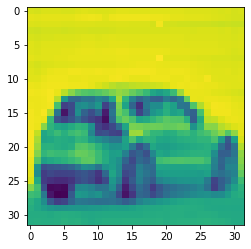

Class for this 1
[[2.3925936e-10 1.0000000e+00 5.6845797e-14 4.3043689e-12 4.4440273e-13
  1.9210852e-13 1.0372402e-12 5.7237066e-13 2.6933677e-13 5.6719582e-08]]


In [23]:
plt.imshow(population[0].reshape(CIFAR_IMG,CIFAR_IMG))
plt.show()
print(f"Class for this {adversarial_y[15][0]}")
print(model.predict(population[0].reshape(1,CIFAR_IMG,CIFAR_IMG,1) /255.0))

In [24]:
parent1 = tournament(population, model, adversarial[15], adversarial_y[15]) 
parent2 = tournament(population, model, adversarial[15], adversarial_y[15])

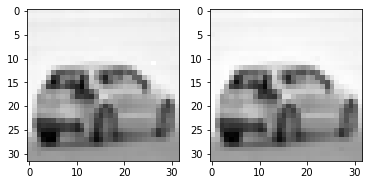

In [25]:
fd, idx =  plt.subplots(1,2)
idx[0].imshow(parent1.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")
idx[1].imshow(parent2.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")

In [26]:
child1, child2 = multi_crossover(parent1, parent2,adversarial[15]) # crossover 
#child1, child2 = add_noise(child1), add_noise(child2) # apply mutation to pixels 

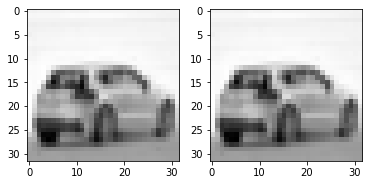

In [27]:
fd, idx =  plt.subplots(1,2)
idx[0].imshow(child1.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")
idx[1].imshow(child2.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")


In [28]:
print(f"diff between children {np.unique(child1-child2)}")
print(f"diff between parents {np.unique(parent1-parent2)}")
print(f"diff between p1 and c1 {np.unique(parent1-child1)}")
print(f"diff between p1 and c2 {np.unique(parent1-child2)}")
print(f"diff between p2 and c1 {np.unique(parent2-child1)}")
print(f"diff between p2 and c2 {np.unique(parent2-child2)}")

diff between children [-5.633789  -4.149948  -3.062912   0.         5.7095413  9.564171 ]
diff between parents [-16.72924    -9.685455   -9.564171   -8.706863   -5.7095413  -4.29274
  -3.8920288  -2.7790756  -1.6091766   0.          1.1050491   2.2260437
   3.0292664   3.062912    4.149948    4.1768646   5.633789    6.016098
   6.0724335  10.647095   17.198486   21.725456 ]
diff between p1 and c1 [-16.72924    -9.685455   -9.564171   -5.7095413  -4.29274    -3.8920288
  -2.7790756  -1.6091766   0.          1.1050491   2.2260437   3.0292664
   3.062912    4.149948    4.1768646   5.633789    6.016098    6.0724335
  10.647095   17.198486   21.725456 ]
diff between p1 and c2 [-16.72924    -9.685455   -4.29274    -3.8920288  -2.7790756  -1.6091766
   0.          1.1050491   2.2260437   3.0292664   4.1768646   6.016098
   6.0724335  10.647095   17.198486   21.725456 ]
diff between p2 and c1 [0.       8.706863]
diff between p2 and c2 [-5.633789  -4.149948  -3.062912   0.         5.7095413  8.

In [29]:
bb = choose_better_child(child1, child2,adversarial[15],adversarial_y[15][0],model)

In [30]:
fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),label) 
print(fitness)

[0.8014106319734277, 0.8013349582518472, 0.8014293794137679, 0.8013389999639673, 0.801335669513062, 0.8016970375516973, 0.8014547042102144, 0.8016758843262608, 0.8013547582777604, 0.801347223031388, 0.8014111625420132, 0.8014605567327152, 0.8010434583413905, 0.8011719988936645, 0.8010114910066083, 0.8013058833605515, 0.8011271281240757, 0.8012682750889641, 0.8015560620109432, 0.8009099338023167, 0.8011529622118293, 0.8015138835952867, 0.8013537464388139, 0.8013613611074951, 0.8012191521013188, 0.8013303732132802, 0.8012963218502285, 0.8012501804726944, 0.8010117911718535, 0.8010794256863534, 0.8013749676485076, 0.8014044027152726, 0.801727108314284, 0.801269038213669, 0.8013271415238595, 0.8012508160211615, 0.8012221824096691, 0.80105104556003, 0.801272201585212, 0.8015308143612893, 0.8014880139641308, 0.8012923082436346, 0.8013355652603554, 0.8013535490432567, 0.8014264977532295, 0.8012615862222893, 0.801383184293186, 0.8011283911010407, 0.8012473973832913, 0.8010615354084115]
